# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from shapely.geometry import Point, LineString, shape, Polygon
import pandas as pd
import math
#!pip install geopandas
#import geopandas as gpd
#from geopandas import GeoDataFrame

!pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip
import scipy
import tslearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 3.0 MB 2.4 MB/s 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tslearn: filename=tslearn-0.5.3.2-py3-none-any.whl size=358145 sha256=88216adcb27d7f4539a7c4199f1fc7e65c7676f436c7a34edf91217fbba11b57
  Stored in directory: /tmp/pip-ephem-wheel-cache-a51oehoh/wheels/20/be/90/d5ba35cd1bbd00cee29a66fdf9dff12824168fec697cf06643
Successfully built tslearn


In [ ]:
#!unzip /content/gdrive/MyDrive/Files/CSVs.zip -d /content/gdrive/MyDrive/Files/

In [ ]:
!cp "/content/gdrive/MyDrive/Files/CSVs.zip" "data"

In [ ]:
!unzip -uq "data" -d "dataunzi"
dataUnzip="/content/dataunzi/CSVs/"

In [ ]:
extra = "/content/gdrive/My Drive/Files/Extra/"

In [ ]:
modeldrone = pd.read_csv(extra + "flight_to_drone.csv")

In [ ]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir(dataUnzip) if isfile(join(dataUnzip, f))]

fileName = []
for name in files:
    if name[:3] == 'Fli':
      fileName.append(name.replace('FlightPlan_','').replace('.csv',''))

len(fileName)

72

# Data visualization and processing

In [ ]:
#dataset0 = pd.DataFrame({'ID': fileName})
#dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
#print(dataset0.loc[dataset0['maxError']>=15])

In [ ]:
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_B_UTAH_1565_DELV_02.csv")
flightPlan.head(2)


Unnamed: 0     WPname     FPLlat    FPLlon  FPLalt  FPLvel  FPLturn  \
0           0  Waypoint1  41.265035  1.996407    27.0     3.0     54.0   
1           1  Waypoint2  41.264055  1.996406    67.0     5.0     14.0   

            FPLwpt  
0  CurvaturePassed  
1  CurvaturePassed

In [ ]:
usp = pd.read_csv(dataUnzip + "UsPrediction_B_UTAH_1565_DELV_02.csv")
usp.head(4)

Unnamed: 0.1  Unnamed: 0       lon        lat  alt  secs
0             0           0  1.996407  41.265035   30     0
1             1           1  1.996406  41.264055   70    37
2             2           2  1.996405  41.263785   70    43
3             3           3  1.993994  41.263787   70    64

In [ ]:
'''
pf=planFix('B_OMAHA_965_DELV_04')
pf['U-Space time']=usp['secs'].diff().values
pf.loc[0,'U-Space time']=0
pf['time diff']=pf['timeSeg'].values-pf['U-Space time'].values
pf['time diff']=pf['time diff'].round(3)
pf
'''

In [ ]:
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

p0= [flightPlan.loc[0,'FPLlat'], flightPlan.loc[0,'FPLlon'], flightPlan.loc[0,'FPLalt']]
p1= [flightPlan.loc[1,'FPLlat'], flightPlan.loc[1,'FPLlon'], flightPlan.loc[1,'FPLalt']]
p0=[41.26524176,1.97890135,26]
p1=[41.26406284600235,1.9789006061137058,36]
from geopy import distance
distance_2d= distance.distance(p0[:2], p1[:2]).m
#2D geodesic distance in meters
print(distance_2d)
# 3D euclidean distance
distance_3d = np.sqrt(distance_2d**2 + (p1[2] - p0[2])**2)
print(distance_3d)


130.92905620770946
131.3103870965338


In [ ]:
#!pip install haversine
#import haversine as hs
#hs.haversine(p0[:2], p1[:2])*1000

Text(0.5, 1.0, 'Distribution of drone models')

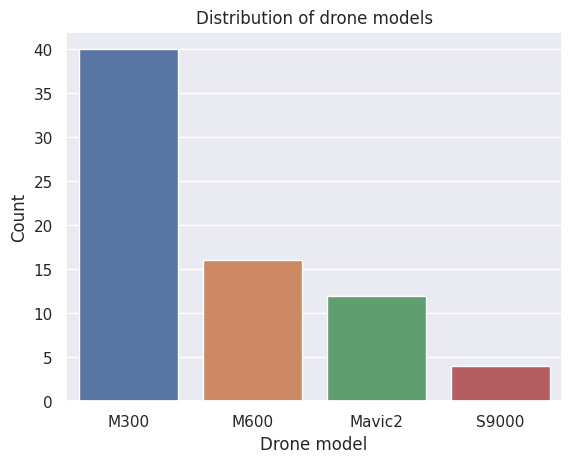

In [ ]:
import seaborn as sns
modeldrone0=modeldrone
for i,row in modeldrone0.iterrows():
  if (row['id']) not in fileName:
    modeldrone0 = modeldrone0.drop([i])
modeldrone0.reset_index(drop=True)

categories = modeldrone0
juno = categories[categories['id'].str.contains('JU')].index # All JUNO flights
categories.loc[juno, 'id'] = 'JUNO'
utah = categories[categories['id'].str.contains('UT')].index
categories.loc[utah, 'id'] = 'UTAH'
omaha = categories[categories['id'].str.contains('OM')].index
categories.loc[omaha, 'id'] = 'OMAHA'
sword = categories[categories['id'].str.contains('SW')].index
categories.loc[sword, 'id'] = 'SWORD'

#df=categories.groupby(['id','drone']).size()
#df=df.unstack()
#df.plot(kind='bar')

sns.set(style="darkgrid")
ax = sns.countplot(x="drone", data=modeldrone0)
ax.set(xlabel='Drone model', ylabel='Count')
plt.title("Distribution of drone models")

Text(0.5, 1.0, 'Number of flights from each operator')

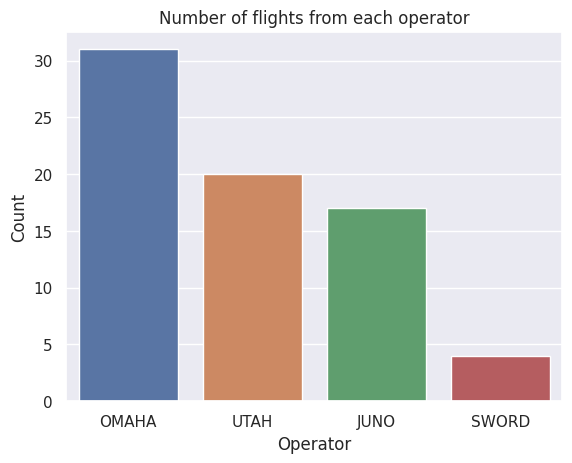

In [ ]:
ids = pd.DataFrame(fileName, columns=['id'])
ids[ids['id'].str.contains('JU')] = 'JUNO' # All JUNO flights
ids[ids['id'].str.contains('UT')] = 'UTAH'
ids[ids['id'].str.contains('OM')] = 'OMAHA'
ids[ids['id'].str.contains('SW')] = 'SWORD'
ids = ids.groupby(["id"], as_index=False).agg(count=("id", "count"))
ids = ids.sort_values(by = 'count', ascending=False).reset_index(drop=True)

sns.set(style="darkgrid")
ax = sns.barplot(x=ids["id"], y=ids['count'])
ax.set(xlabel='Operator', ylabel='Count')
plt.title("Number of flights from each operator")

Text(0.5, 1.0, 'Operator drone models')

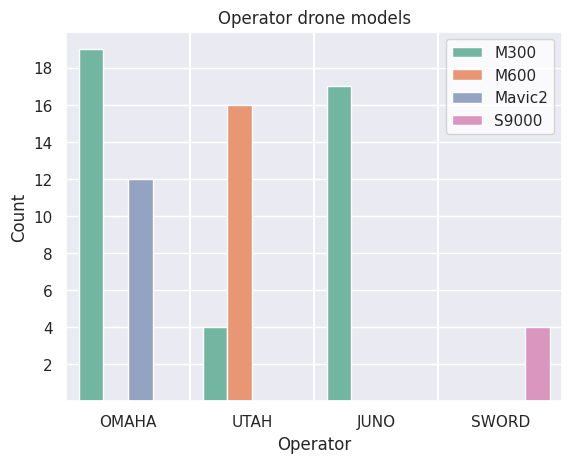

In [ ]:
order = ids

sns.set_style('darkgrid', {'legend.frameon':True})
order=categories['id'].value_counts().index

ax = sns.countplot(x='id', hue='drone', data=categories,palette=sns.color_palette('Set2',8),order=order)
plt.axvline([0.5], color='white')
plt.axvline([1.5], color='white')
plt.axvline([2.5], color='white')

legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.yticks([2, 4, 6,8,10,12,14,16,18])

ax.set(xlabel='Operator', ylabel='Count')
plt.title("Operator drone models")

In [ ]:
def plot_plan(name):
  ### plots the 3D view of the FlightPlan, providing the string name | lat, lon, alt
  ### (lon: x, lat: y, alt: z)

  ## read files
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" +name + ".csv")

  ## create figure
  fig=plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')

  ## set white background
  ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

  ## plotting (lat, lon, alt)
  plt.plot(flightPlan['FPLlat'], flightPlan['FPLlon'], flightPlan['FPLalt'], linewidth = 2, linestyle = "-", marker="o", color = "green", label='Flight Plan')

  ## start, end and hover points
  ax.scatter(flightPlan['FPLlat'][0], flightPlan['FPLlon'][0], flightPlan['FPLalt'][0], c='fuchsia', marker='D', s=40, label='Start')
  ax.scatter(flightPlan['FPLlat'].iloc[-1], flightPlan['FPLlon'].iloc[-1], flightPlan['FPLalt'].iloc[-1], c='blue', marker='s', s=30, label='End')

  df_hover = flightPlan[flightPlan['WPname'].str.contains('Hover')]
  for index, row in df_hover.iterrows():
    ax.scatter(flightPlan['FPLlat'].iloc[index], flightPlan['FPLlon'].iloc[index], flightPlan['FPLalt'].iloc[index], c='cyan', marker='2', s=60, label='Hover')

  ## add labels to the FlightPlan points
  for index, row in flightPlan.iterrows():
     ax.text(flightPlan.at[index,'FPLlat'],flightPlan.at[index,'FPLlon'],flightPlan.at[index,'FPLalt']+2, index, bbox=dict(boxstyle='square,pad=-0.1', fc='white', ec='none'))

  ## add labels to the axis, padding and specify the ticks
  ax.set_xlabel('Latitude [º]')
  ax.xaxis.labelpad=15
  ax.xaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_ylabel('Longitude [º]')
  ax.yaxis.labelpad=15
  ax.yaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_zlabel('Altitude [m]')
  ax.zaxis.set_major_locator(plt.MaxNLocator(4))

  ## add figure title and extra 2D text if needed
  ax.set_title("Flightplan " + name, fontsize=12)
  #ax.text2D(0.05, 0.95, "Flightplan " + name, transform=ax.transAxes)

  ## zoom out to avoid cutting off the axis or plot
  ax.set_box_aspect(aspect=None, zoom=0.9)

  ## plot legend and adapt view angle
  ax.legend()
  ax.view_init(elev=25, azim=45)


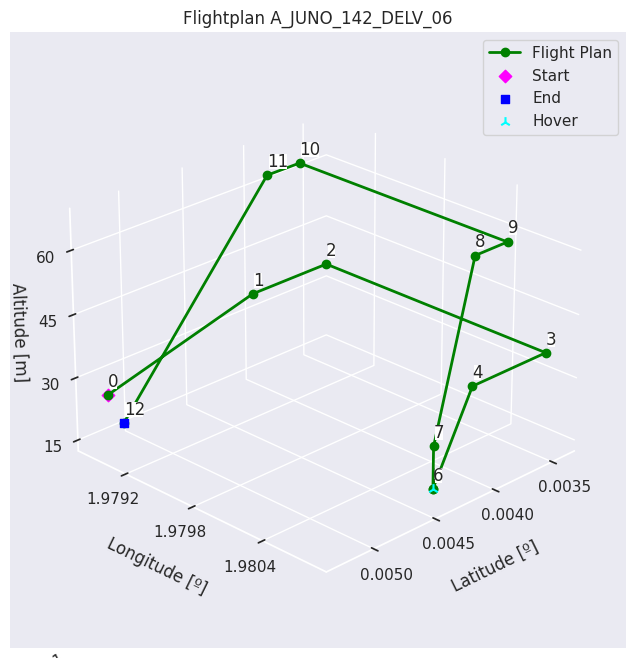

In [ ]:
plot_plan("A_JUNO_142_DELV_06")

In [ ]:
telemetry = pd.read_csv(dataUnzip + "Telemetry_B_OMAHA_965_DELV_04.csv")
telemetry.head(2)
#telemetry.iloc[400:450]

Unnamed: 0       lat       lon   alt  secs
0         141  41.26503  1.991083  27.0   0.0
1         142  41.26503  1.991083  27.2   0.1

In [ ]:
def plot_tele(plan):
  telemetry = pd.read_csv(dataUnzip +'Telemetry_'+ plan + ".csv")
  fig=plt.figure()
  ax = plt.axes(projection='3d')
  plt.plot(telemetry['lat'], telemetry['lon'], telemetry['alt'], linewidth = 1, linestyle = "-", color = "green", label='Telemetry')
  ax.legend()
  #ax.scatter3D(gdf['longitude'], gdf['latitude'], gdf['height_above_takeoff(meters)'], cmap='Greens');
  #ax.view_init(elev=090, azim=0)

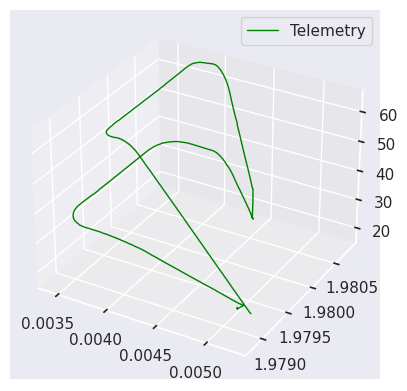

In [ ]:
plot_tele('A_JUNO_142_DELV_06')

In [ ]:
def plot_planVsTele(name):
  ### plots the 3D view of the FlightPlan against Telemetry, providing the string name | lat, lon, alt

  ## read files
  flightPlan = pd.read_csv(dataUnzip + 'FlightPlan_' + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_'+ name + ".csv")

  ## create figure
  fig=plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')

  ## set white background
  ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

  ## plotting
  plt.plot(flightPlan['FPLlat'], flightPlan['FPLlon'], flightPlan['FPLalt'], linewidth = 2, linestyle = "-", marker="o", color = "green", label='Flight Plan')
  plt.plot(telemetry['lat'], telemetry['lon'], telemetry['alt'], linewidth = 1, linestyle = "-", color = "red", label='Telemetry')

  ## start, end and hover points
  ax.scatter(flightPlan['FPLlat'][0], flightPlan['FPLlon'][0], flightPlan['FPLalt'][0], c='fuchsia', marker='D', s=40, label='Start')
  ax.scatter(flightPlan['FPLlat'].iloc[-1], flightPlan['FPLlon'].iloc[-1], flightPlan['FPLalt'].iloc[-1], c='blue', marker='s', s=30, label='End')

  df_hover = flightPlan[flightPlan['WPname'].str.contains('Hover')]
  for index, row in df_hover.iterrows():
    ax.scatter(flightPlan['FPLlat'].iloc[index], flightPlan['FPLlon'].iloc[index], flightPlan['FPLalt'].iloc[index], c='cyan', marker='2', s=60, label='Hover')

  ## add labels to the FlightPlan points
  for index, row in flightPlan.iterrows():
     ax.text(flightPlan.at[index,'FPLlat'],flightPlan.at[index,'FPLlon'],flightPlan.at[index,'FPLalt']+2, index, bbox=dict(boxstyle='square,pad=-0.1', fc='white', ec='none'))

  ## add labels to the axis, padding and specify the ticks
  ax.set_xlabel('Latitude [º]')
  ax.xaxis.labelpad=15
  ax.xaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_ylabel('Longitude [º]')
  ax.yaxis.labelpad=15
  ax.yaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_zlabel('Altitude [m]')
  ax.zaxis.set_major_locator(plt.MaxNLocator(4))

  ## add figure title and extra 2D text if needed
  ax.set_title("Flightplan Vs. Telemetry for " + name, fontsize=12)
  #ax.text2D(0.05, 0.95, "Flightplan " + name, transform=ax.transAxes)

  ## zoom out to avoid cutting off the axis or plot
  ax.set_box_aspect(aspect=None, zoom=0.9)

  '''
  #telemetry index
  highlight_index2=171
  highlight_point2 = telemetry.loc[highlight_index2]
  ax.scatter(highlight_point2['lat'], highlight_point2['lon'], highlight_point2['alt'], c='orange', label='Highest error point')
  '''
  ## plot legend and adapt view angle
  ax.legend()
  ax.view_init(elev=25, azim=35)


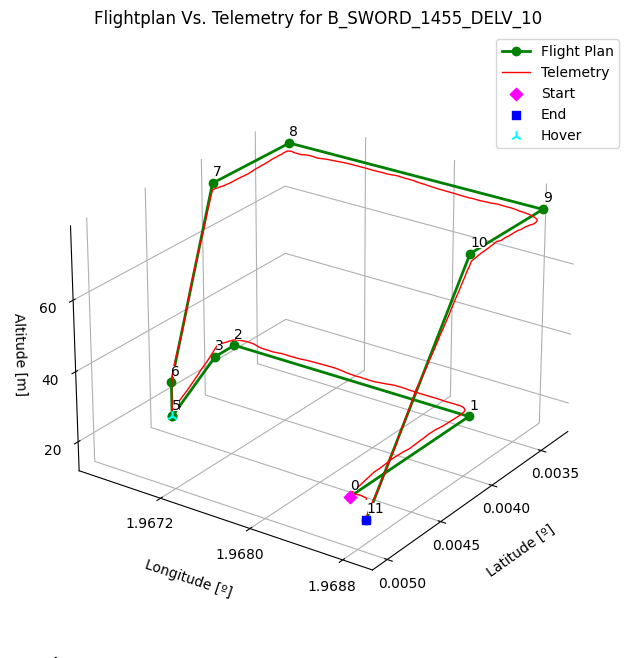

In [ ]:
plot_planVsTele('B_SWORD_1455_DELV_10')


```
                     ID    maxError
17  B_UTAH_1348_DELV_02   34.580907
27  B_UTAH_1485_DELV_01   66.540797
28  A_OMAHA_401_DELV_01  162.210186
32  B_UTAH_1006_DELV_01  131.528639
38   A_UTAH_391_DELV_07  140.106606
51  A_OMAHA_411_DELV_08  141.372395
54  A_OMAHA_128_DELV_01  162.025126
57   A_JUNO_399_DELV_09   76.937243
```






---




> **Coordinate conversion from LLA (latitude, longitude, alitude) to x, y, z (ECEF)**


In [ ]:
def geodetic2ecef(lat,lon,h):
  ### convert from LLA (geodetic) to ECEF coordinates (x, y, z earth-centered)
  ## haversine formula?
  ## https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates
  ## https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system#Structure
  ## positve x: On Equator plane, extending from Earth center to Prime Meridian (Greenwhich).
  ## positive y: On Equator plane, to 90ºE longitude (90º to the East of Greenwhich Meridian)
  ## for WGS84 model:
  a = 6378137 # semi major axis
  b = 6356752.31424  #semi minor axis
  lat = lat * math.pi/180
  lon = lon * math.pi/180
  N = (a**2)/(math.sqrt((a**2)*(math.cos(lat))**2+(b**2)*(math.sin(lat))**2))
  x = (N+h)*math.cos(lat)*math.cos(lon)
  y = (N+h)*math.cos(lat)*math.sin(lon)
  z = (((b**2)/(a**2))*N+h)*math.sin(lat)
  return x,y,z

In [ ]:
def gps2ecef_custom(latitude, longitude, altitude):
    # (lat, lon) in WSG-84 degrees
    # altitude in meters
    cosLat = math.cos(latitude * math.pi / 180)
    sinLat = math.sin(latitude * math.pi / 180)

    cosLong = math.cos(longitude * math.pi / 180)
    sinLong = math.sin(longitude * math.pi / 180)

    c = 1 / math.sqrt(cosLat * cosLat + (1 - f) * (1 - f) * sinLat * sinLat)
    s = (1 - f) * (1 - f) * c

    x = (R*c + altitude) * cosLat * cosLong
    y = (R*c + altitude) * cosLat * sinLong
    z = (R*s + altitude) * sinLat

    return x, y, z

R = 6378137
f_inv = 298.257224
f = 1.0 / f_inv
e2 = 1 - (1 - f) * (1 - f)


def ecef_to_enu(x, y, z, latRef, longRef, altRef):
    cosLatRef = math.cos(latRef * math.pi / 180)
    sinLatRef = math.sin(latRef * math.pi / 180)

    cosLongRef = math.cos(longRef * math.pi / 180)
    sinLongRef = math.sin(longRef * math.pi / 180)

    cRef = 1 / math.sqrt(cosLatRef * cosLatRef + (1 - f) * (1 - f) * sinLatRef * sinLatRef)

    x0 = (R*cRef + altRef) * cosLatRef * cosLongRef
    y0 = (R*cRef + altRef) * cosLatRef * sinLongRef
    z0 = (R*cRef*(1-e2) + altRef) * sinLatRef

    xEast = (-(x-x0) * sinLongRef) + ((y-y0)*cosLongRef)

    yNorth = (-cosLongRef*sinLatRef*(x-x0)) - (sinLatRef*sinLongRef*(y-y0)) + (cosLatRef*(z-z0))

    zUp = (cosLatRef*cosLongRef*(x-x0)) + (cosLatRef*sinLongRef*(y-y0)) + (sinLatRef*(z-z0))

    return xEast, yNorth, zUp

def geodetic_to_enu(lat, lon, h, lat_ref, lon_ref, h_ref):
    x, y, z = gps2ecef_custom(lat, lon, h)
    return ecef_to_enu(x, y, z, lat_ref, lon_ref, h_ref)

In [ ]:
lat=41.26406284600235
lon=1.9789006061137058
h=36;
lat0=41.26524176;
lon0=1.97890135;
h0=26;

geodetic_to_enu(lat,lon,h,lat0,lon0,h0)


(-0.0623369093913726, -130.9297820922617, 9.998652997548646)

In [ ]:
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + '.csv')
lat0=flightPlan['FPLlat'][0]
lon0=flightPlan['FPLlon'][0]
h0=flightPlan['FPLalt'][0]
## convert and replace the lat, lon, alt to x, y, z
for i, row in flightPlan.iterrows():
  flightPlan.at[i,'FPLlat'],flightPlan.at[i,'FPLlon'],flightPlan.at[i,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)
flightPlan = flightPlan.rename(columns={'FPLlat': 'x', 'FPLlon': 'y', 'FPLalt':'z'})
flightPlan

Unnamed: 0      WPname           x           y          z  FPLvel  \
0            0   Waypoint1    0.000000    0.000000   0.000000     7.0   
1            1   Waypoint2   -0.062337 -130.929782   9.998653    10.0   
2            2   Waypoint3   -0.095624 -200.844605   9.996830    10.0   
3            3   Waypoint4  158.207656 -200.919397   9.994869    10.0   
4            4   Waypoint5  158.240949 -131.004574   9.996691     3.0   
5            5   Waypoint6  158.257279  -95.670870 -10.002680     0.0   
6            6    Hover10s  158.257279  -95.670870 -10.002680     2.0   
7            7   Waypoint7  158.257527  -95.671020  -0.002680     2.0   
8            8   Waypoint8  158.241692 -131.005192  39.996691    10.0   
9            9   Waypoint9  158.227424 -160.968830  39.996004    10.0   
10          10  Waypoint10   11.620728 -160.899564  39.997955    10.0   
11          11  Waypoint11   11.634994 -130.935926  39.998642     4.0   
12          12  Waypoint12   11.697261    0.017779  -5.000011     0.0   

    FPLturn           FPLwpt  
0      65.0  CurvaturePassed  
1      34.0  CurvaturePassed  
2      34.0  CurvaturePassed  
3      34.0  CurvaturePassed  
4      17.0  CurvaturePassed  
5       0.2         LineStop  
6       0.2         LineStop  
7       0.2  CurvaturePassed  
8      14.0  CurvaturePassed  
9      14.0  CurvaturePassed  
10     14.0  CurvaturePassed  
11     14.0  CurvaturePassed  
12     65.0  CurvaturePassed



---



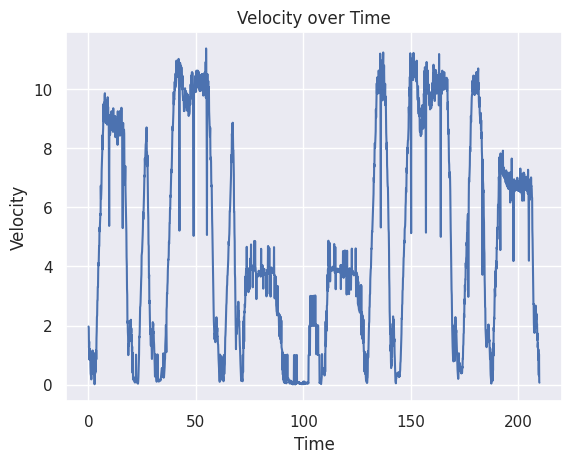

In [ ]:
# Velocity plot
telemetry = pd.read_csv(dataUnzip + 'Telemetry_'+ 'B_UTAH_1565_DELV_02' + ".csv")

for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])
telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

# Calculate the differences in position and time
telemetry['delta_x2'] = telemetry['x2'].diff()
telemetry['delta_y2'] = telemetry['y2'].diff()
telemetry['delta_z2'] = telemetry['z2'].diff()
telemetry['delta_time'] = telemetry['secs'].diff()

# Calculate the velocity using the differences
telemetry['velocity'] = (telemetry['delta_x2']**2 + telemetry['delta_y2']**2 + telemetry['delta_z2']**2)**0.5 / telemetry['delta_time']

# Plot velocity over time
plt.plot(telemetry['secs'], telemetry['velocity'])
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity over Time')
plt.show()

In [ ]:
def planFix(flightPlan):
  ### convert lat, lon, alt to x, y, z
  ### x, y, z are with respect to the first point of the trajectory
  ### get new column 'time' for the time to pass each waypoint

  ## read files
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + flightPlan + '.csv')

  ## convert and replace the lat, lon, alt to x, y, z
  for i, row in flightPlan.iterrows():
    flightPlan.at[i,'FPLlat'],flightPlan.at[i,'FPLlon'],flightPlan.at[i,'FPLalt']= \
    geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ## compute the time by dividing the absolute distance by the velocity
  for (_, original), (i, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    if  (original['FPLvel']) > 0:
      dist=math.sqrt((shift['FPLlon']-original['FPLlon'])**2+(shift['FPLlat']-original['FPLlat'])**2+
       (shift['FPLalt']-original['FPLalt'])**2)
      flightPlan.at[i, 'timeSeg']=dist/(original['FPLvel'])
    else:
      flightPlan.at[i, 'timeSeg'] = int(flightPlan.at[i,'WPname'].replace(
          'Hover', '').replace('s',''))
  ## fill Nan of the first row (as it is not considerd in the loop) and get global time
  flightPlan['timeSeg'].fillna(0, inplace=True)
  flightPlan['time']=(flightPlan['timeSeg'].cumsum(axis = 0))

  ## set the first point as origin
  flightPlan['FPLlat'] = flightPlan['FPLlat'] - flightPlan['FPLlat'][0]
  flightPlan['FPLlon'] = flightPlan['FPLlon'] - flightPlan['FPLlon'][0]
  flightPlan['FPLalt'] = flightPlan['FPLalt'] - flightPlan['FPLalt'][0]
  flightPlan = flightPlan.rename(columns={'FPLlat': 'x', 'FPLlon': 'y', 'FPLalt':'z'})

  return flightPlan

In [ ]:
def planFixENU(flightPlan):
  ### convert lat, lon, alt to x, y, z
  ### x, y, z are with respect to the first point of the trajectory
  ### get new column 'time' for the time to pass each waypoint

  ## read files
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + flightPlan + '.csv')
  lat0=flightPlan['FPLlat'][0]
  lon0=flightPlan['FPLlon'][0]
  h0=flightPlan['FPLalt'][0]
  ## convert and replace the lat, lon, alt to x, y, z
  for i, row in flightPlan.iterrows():
    flightPlan.at[i,'FPLlat'],flightPlan.at[i,'FPLlon'],flightPlan.at[i,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  flightPlan = flightPlan.rename(columns={'FPLlat': 'x', 'FPLlon': 'y', 'FPLalt':'z'})

  ## compute the time by dividing the absolute distance by the velocity
  for (_, original), (i, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    if  (original['FPLvel']) > 0:
      dist=math.sqrt((shift['y']-original['y'])**2+(shift['x']-original['x'])**2+
       (shift['z']-original['z'])**2)
      flightPlan.at[i, 'timeSeg']=dist/(original['FPLvel'])
    else:
      flightPlan.at[i, 'timeSeg'] = int(flightPlan.at[i,'WPname'].replace(
          'Hover', '').replace('s',''))

  ## fill Nan of the first row (as it is not considerd in the loop) and get global time
  flightPlan['timeSeg'].fillna(0, inplace=True)
  flightPlan['time']=(flightPlan['timeSeg'].cumsum(axis = 0))


  return flightPlan

In [ ]:
def planInfoENU(name):
  #name='B_JUNO_1422_DELV_10'
  ### convert lat, lon, alt to x, y, z
  ### x, y, z are with respect to the first point of the trajectory
  ### get new column 'time' for the time to pass each waypoint
  sync = syncPlan(name)
  telemetry= pd.read_csv(dataUnzip + "Telemetry_" + name + '.csv')
  ## read files
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')
  lat0=flightPlan['FPLlat'][0]
  lon0=flightPlan['FPLlon'][0]
  h0=flightPlan['FPLalt'][0]
  ## convert and replace the lat, lon, alt to x, y, z
  for i, row in flightPlan.iterrows():
    flightPlan.at[i,'FPLlat'],flightPlan.at[i,'FPLlon'],flightPlan.at[i,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  flightPlan = flightPlan.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})
  for (i, original), (j, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    flightPlan.at[i,'x1'] = shift['x0']
    flightPlan.at[i,'y1'] = shift['y0']
    flightPlan.at[i,'z1'] = shift['z0']

  ## compute the time by dividing the absolute distance by the velocity
  for i, row in flightPlan[:-1].iterrows():
    if  (row['FPLvel']) > 0:
      dist2d=math.sqrt((row['y1']-row['y0'])**2+(row['x1']-row['x0'])**2)
      dist3d=math.sqrt(dist2d**2+(row['z1']-row['z0'])**2)
      flightPlan.at[i, '2Ddist']=dist2d
      flightPlan.at[i, '3Ddist']=dist3d
      flightPlan.at[i, 'timeSeg3D']=dist3d/(row['FPLvel'])
      flightPlan.at[i, 'timeSeg2D']=dist2d/(row['FPLvel'])
    else:
      flightPlan.at[i, 'timeSeg2D'] = int(flightPlan.at[i+1,'WPname'].replace('Hover', '').replace('s',''))
      flightPlan.at[i, 'timeSeg3D'] = int(flightPlan.at[i+1,'WPname'].replace('Hover', '').replace('s',''))
  uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + name + '.csv')
  flightPlan['t_us'] = uspace['secs'][1:].reset_index(drop=True)
  for i, row in flightPlan.iterrows():
    flightPlan.loc[i, "t_tel"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i)*50))[0][0]][0]]['secs']
  flightPlan['t_tel'] = flightPlan['t_tel'].shift(-1)

  flightPlan=flightPlan[:-1]
  ## fill Nan of the first row (as it is not considerd in the loop) and get global time
  flightPlan['timeSeg3D'].fillna(0, inplace=True)
  flightPlan['timeSeg2D'].fillna(0, inplace=True)
  flightPlan['3Ddist'].fillna(0, inplace=True)
  flightPlan['2Ddist'].fillna(0, inplace=True)
  flightPlan['time3D']=(flightPlan['timeSeg3D'].cumsum(axis = 0))
  flightPlan['time2D']=(flightPlan['timeSeg2D'].cumsum(axis = 0))
  flightPlan['timeSegUs']=(flightPlan['t_us'].diff())
  flightPlan.at[0, 'timeSegUs']=flightPlan.loc[0,'t_us']

  flightPlan=flightPlan[['x0','y0','z0','x1','y1','z1','2Ddist','3Ddist','FPLvel', 'FPLturn','timeSeg2D','timeSeg3D','timeSegUs','time2D','time3D','t_tel','t_us']]
  return flightPlan

In [ ]:
''' Cumulative error
pi = planInfoENU('B_JUNO_1422_DELV_10')
error3d=0
errorUs=0
for ind, row in dataset0.iterrows():
  pi = planInfoENU(row['ID'])
  error3d=error3d+abs(pi['t_tel'].iloc[-1]-pi['time3D'].iloc[-1])
  errorUs=errorUs+abs(pi['t_tel'].iloc[-1]-pi['t_us'].iloc[-1])
'''

x0          y0         z0           x1          y1         z1  \
0      0.000000    0.000000   0.000000    -0.071847 -150.905209  -0.001789   
1     -0.071847 -150.905209  -0.001789 -1029.429704 -150.418555  -0.084731   
2  -1029.429704 -150.418555  -0.084731 -1029.420204 -130.442923  -0.084289   
3  -1029.420204 -130.442923  -0.084289 -1029.397337  -85.747690 -10.083526   
4  -1029.397337  -85.747690 -10.083526 -1029.397337  -85.747690 -10.083526   
5  -1029.397337  -85.747690 -10.083526 -1029.398949  -85.747824  -0.083526   
6  -1029.398949  -85.747824  -0.083526 -1029.428263 -130.443948  49.915710   
7  -1029.428263 -130.443948  49.915710 -1029.466263 -210.347099  49.913565   
8  -1029.466263 -210.347099  49.913565    11.596969 -210.839288  49.996497   
9     11.596969 -210.839288  49.996497    11.635013 -130.936132  49.998642   
10    11.635013 -130.936132  49.998642    11.697261    0.017779  -5.000011   

         2Ddist       3Ddist  FPLvel  FPLturn   timeSeg2D   timeSeg3D  \
0    150.905226   150.905226     5.0     75.0   30.181045   30.181045   
1   1029.357972  1029.357975    10.0     75.0  102.935797  102.935798   
2     19.975634    19.975634     5.0      9.0    3.995127    3.995127   
3     44.695239    45.800100     3.0      9.0   14.898413   15.266700   
4      0.000000     0.000000     0.0      0.2   10.000000   10.000000   
5      0.001617    10.000000     2.0      0.2    0.000809    5.000000   
6     44.696133    67.064655     2.0      0.2   22.348066   33.532328   
7     79.903161    79.903161     5.0     22.0   15.980632   15.980632   
8   1041.063348  1041.063351    10.0     39.0  104.106335  104.106335   
9     79.903165    79.903165     5.0     39.0   15.980633   15.980633   
10   130.953926   142.034441     3.0     39.0   43.651309   47.344814   

    timeSegUs      time2D      time3D  t_tel   t_us  
0        31.0   30.181045   30.181045   32.6   31.0  
1       103.0  133.116842  133.116843  134.7  134.0  
2         4.0  137.111969  137.111970  140.7  138.0  
3        15.0  152.010382  152.378670  162.5  153.0  
4        10.0  162.010382  162.378670  167.5  163.0  
5         5.0  162.011191  167.378670  172.7  168.0  
6        15.0  184.359257  200.910997  200.4  183.0  
7        16.0  200.339890  216.891629  212.3  199.0  
8       104.0  304.446224  320.997964  315.9  303.0  
9        16.0  320.426857  336.978597  334.7  319.0  
10       44.0  364.078166  384.323411  382.6  363.0

In [ ]:
pf=planFix('A_JUNO_142_DELV_06')
pf['time'].diff()
i0=4
i1=5
dist=((pf.loc[i1,'x']-pf.loc[i0,'x'])**2+(pf.loc[i1,'y']-pf.loc[i0,'y'])**2+(pf.loc[i1,'z']-pf.loc[i0,'z'])**2)**0.5
dist

40.60105634810789

In [ ]:
def residingPoint(Q,R,P):
  ### line given by 2 points A and B. P is a 3D point
  ### G is the point residing on the line AB closest to point P
  #P=[1,0,1]
  #R=[0,0,0]
  #Q=[1,0,0]

  t=(np.dot(np.subtract(R,Q),np.subtract(Q,P))/np.dot(np.subtract(R,Q),np.subtract(R,Q)))
  G=Q-t*np.subtract(R,Q)
  return G

In [ ]:
def planModel(name):
  ### time per segment column ('time' without cumsum)
  ###

  ## read files
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in flightPlan.iterrows():
    flightPlan.at[index,'FPLlat'],flightPlan.at[index,'FPLlon'],flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ## compute the time by dividing the absolute distance by the velocity
  for (i, original), (i, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    if  (original['FPLvel']) > 0:
      dist=math.sqrt((shift['FPLlon']-original['FPLlon'])**2+(shift['FPLlat']-original['FPLlat'])**2+(shift['FPLalt']-original['FPLalt'])**2)
      flightPlan.at[i, 'timeSeg']=dist/(original['FPLvel'])
    else:
      flightPlan.at[i, 'timeSeg']=time = int(flightPlan.at[i,'WPname'].replace('Hover', '').replace('s',''))


  flightPlan['timeSeg'].fillna(0, inplace=True)
  flightPlan['time']=(flightPlan['timeSeg'].cumsum(axis = 0))
  flightPlan['FPLlat'] = flightPlan['FPLlat'] - flightPlan['FPLlat'][0]
  flightPlan['FPLlon'] = flightPlan['FPLlon'] - flightPlan['FPLlon'][0]
  flightPlan['FPLalt'] = flightPlan['FPLalt'] - flightPlan['FPLalt'][0]
  flightPlan = flightPlan.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  return flightPlan

In [ ]:
def plot_planFix(flightPlan):
  ### plots the 3D view of a df_Flightplan containing columns x, y, z

  ## create figure
  fig=plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')

  ## set white background
  ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

  ## plotting
  plt.plot(flightPlan['x'], flightPlan['y'], flightPlan['z'], linewidth = 2, linestyle = "-", marker="o", color = "green", label='Flight Plan')

  ## start, end and hover points
  ax.scatter(flightPlan['x'][0], flightPlan['y'][0], flightPlan['z'][0], c='fuchsia', marker='D', s=40, label='Start')
  ax.scatter(flightPlan['x'].iloc[-1], flightPlan['y'].iloc[-1], flightPlan['z'].iloc[-1], c='blue', marker='s', s=30, label='End')

  df_hover = flightPlan[flightPlan['WPname'].str.contains('Hover')]
  for index, row in df_hover.iterrows():
    ax.scatter(flightPlan['x'].iloc[index], flightPlan['y'].iloc[index], flightPlan['z'].iloc[index], c='cyan', marker='2', s=60, label='Hover')

  ## add labels to the FlightPlan points
  for index, row in flightPlan.iterrows():
     ax.text(flightPlan.at[index,'x'],flightPlan.at[index,'y'],flightPlan.at[index,'z']+2, index, bbox=dict(boxstyle='square,pad=-0.1', fc='white', ec='none'))

  ## add labels to the axis, padding and specify the ticks
  ax.set_xlabel('X [m]')
  ax.xaxis.labelpad=15
  ax.xaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_ylabel('Y [m]')
  ax.yaxis.labelpad=15
  ax.yaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_zlabel('Z [m]')

  ## add figure title and extra 2D text if needed
  ax.set_title("FlightPlan (Cartesian)"  , fontsize=12)
 # ax.text2D(0.05, 0.95, "ECEF coordinates", transform=ax.transAxes)

  ## zoom out to avoid cutting off the axis or plot
  ax.set_box_aspect(aspect=None, zoom=0.9)

  ## plot legend and adapt view angle
  ax.legend()
  ax.view_init(elev=25, azim=45)

In [ ]:
def plot_planFixENU(flightPlan):
  ### plots the 3D view of a df_Flightplan containing columns x, y, z

  ## create figure
  fig=plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')

  ## set white background
  ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
  ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

  ## plotting
  plt.plot(flightPlan['x'], flightPlan['y'], flightPlan['z'], linewidth = 2, linestyle = "-", marker="o", color = "green", label='Flight Plan')

  ## start, end and hover points
  ax.scatter(flightPlan['x'][0], flightPlan['y'][0], flightPlan['z'][0], c='fuchsia', marker='D', s=40, label='Start')
  ax.scatter(flightPlan['x'].iloc[-1], flightPlan['y'].iloc[-1], flightPlan['z'].iloc[-1], c='blue', marker='s', s=30, label='End')

  df_hover = flightPlan[flightPlan['WPname'].str.contains('Hover')]
  for index, row in df_hover.iterrows():
    ax.scatter(flightPlan['x'].iloc[index], flightPlan['y'].iloc[index], flightPlan['z'].iloc[index], c='cyan', marker='2', s=60, label='Hover')

  ## add labels to the FlightPlan points
  for index, row in flightPlan.iterrows():
     ax.text(flightPlan.at[index,'x'],flightPlan.at[index,'y'],flightPlan.at[index,'z']+2, index, bbox=dict(boxstyle='square,pad=-0.1', fc='white', ec='none'))

  ## add labels to the axis, padding and specify the ticks
  ax.set_xlabel('x-East [m]')
  ax.xaxis.labelpad=15
  ax.xaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_ylabel('y-North [m]')
  ax.yaxis.labelpad=15
  ax.yaxis.set_major_locator(plt.MaxNLocator(4))

  ax.set_zlabel('z-Up [m]')

  ## add figure title and extra 2D text if needed
  ax.set_title("FlightPlan (ENU)"  , fontsize=12)
 # ax.text2D(0.05, 0.95, "ECEF coordinates", transform=ax.transAxes)

  ## zoom out to avoid cutting off the axis or plot
  ax.set_box_aspect(aspect=None, zoom=0.9)

  ## plot legend and adapt view angle
  ax.legend()
  ax.view_init(elev=25, azim=45)

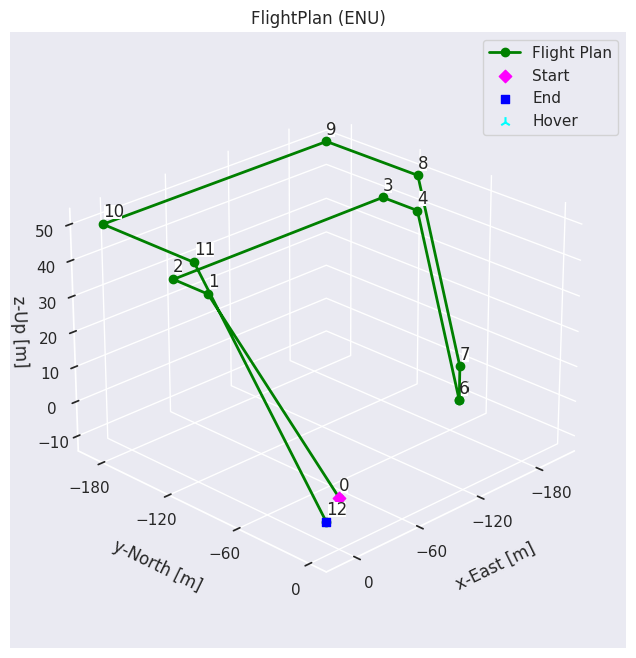

In [ ]:
pf=planFixENU('B_UTAH_1565_DELV_02')
plot_planFixENU(pf)

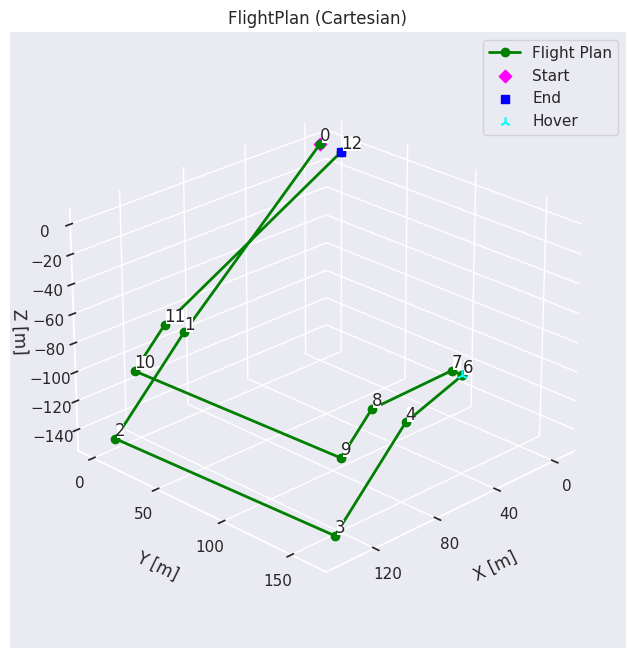

In [ ]:
pf = planFix('A_JUNO_142_DELV_06')
plot_planFix(pf)

In [ ]:
def subplotUspaceVsTele(name):
  ### subplots of latitudes, longitudes, altitudes of both FlightPlan and Telemetry in time

  ## read files
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  uspace = pd.read_csv(dataUnzip +'UsPrediction_' + name + '.csv')

  ## create figure: 3 rows, one column
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

  ## subplot 1: longitude versus time
  ax1.plot(uspace['secs'], uspace['lon'], color='green')
  ax1.plot(telemetry['secs'], telemetry['lon'], color='red')
  ax1.set_xlabel('Time [s]')
  ax1.set_ylabel('Longitude [º]')
  ax1.legend(["U-Space Prediction", "Telemetry"])
  ax1.set_title('Latitude Vs. Time')

  # subplot 2: latitude versus time
  ax2.plot(uspace['secs'], uspace['lat'], color='green')
  ax2.set_xlabel('Time [s]')
  ax2.plot(telemetry['secs'], telemetry['lat'], color='red')
  ax2.set_ylabel('Latitude [º]')
  ax2.set_title('Longitude Vs. Time')

  # subplot 3: altitude versus time
  ax3.plot(uspace['secs'], uspace['alt'], color='green')
  ax3.plot(telemetry['secs'], telemetry['alt'], color='red')
  ax3.set_xlabel('Time [s]')
  ax3.set_ylabel('Altitude [m]')
  ax3.set_title('Altitude Vs. Time')

  fig.suptitle('U-Space Prediction Vs. Telemetry for ' + name)
  plt.tight_layout()
  plt.show()

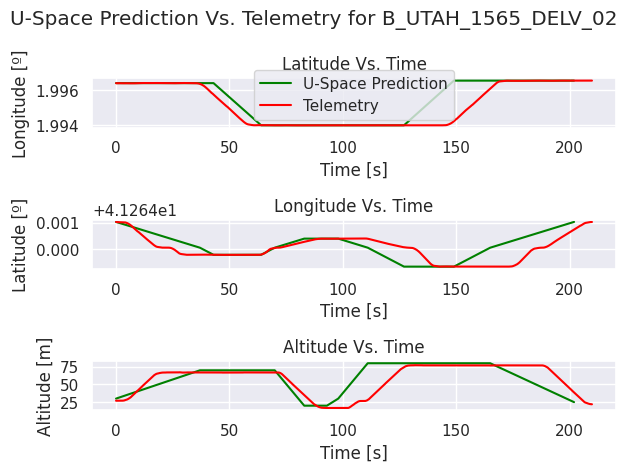

In [ ]:
subplotUspaceVsTele('B_UTAH_1565_DELV_02')

In [ ]:
def subplotPlanVsTele(name):
  ### subplots of latitudes, longitudes, altitudes of both FlightPlan and Telemetry in time

  ## read files
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')

  ## use planFix to get the 'time' column
  flightPlan0=planFix(name)

  ## create figure: 3 rows, one column
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

  ## subplot 1: longitude versus time
  ax1.plot(flightPlan0['time'], flightPlan['FPLlon'], color='green')
  ax1.plot(telemetry['secs'], telemetry['lon'], color='red')
  ax1.set_xlabel('Time [s]')
  ax1.set_ylabel('Longitude [º]')
  ax1.legend(["FlightPlan", "Telemetry"])
  ax1.set_title('Latitude Vs. Time')

  # subplot 2: latitude versus time
  ax2.plot(flightPlan0['time'], flightPlan['FPLlat'], color='green')
  ax2.set_xlabel('Time [s]')
  ax2.plot(telemetry['secs'], telemetry['lat'], color='red')
  ax2.set_ylabel('Latitude [º]')
  ax2.set_title('Longitude Vs. Time')

  # subplot 3: altitude versus time
  ax3.plot(flightPlan0['time'], flightPlan['FPLalt'], color='green')
  ax3.plot(telemetry['secs'], telemetry['alt'], color='red')
  ax3.set_xlabel('Time [s]')
  ax3.set_ylabel('Altitude [m]')
  ax3.set_title('Altitude Vs. Time')

  fig.suptitle('Plan Fix Prediction Vs. Telemetry for ' + name)
  plt.tight_layout()
  plt.show()



```
B_UTAH_1565_DELV_02
B_UTAH_980_DELV_02
B_SWORD_1455_DELV_10
```



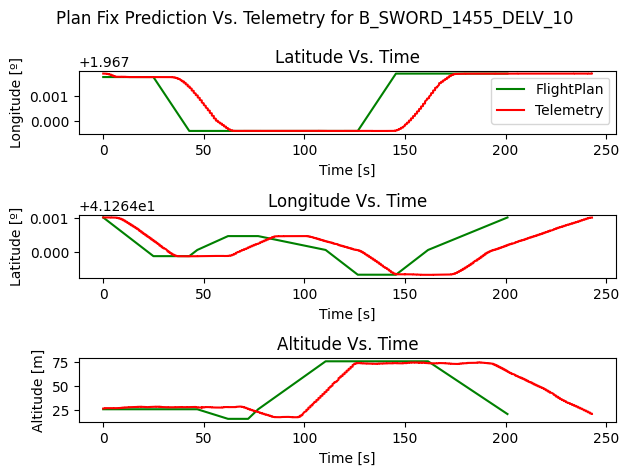

In [ ]:
subplotPlanVsTele('B_SWORD_1455_DELV_10')

C_UTAH_1720_DELV_02 error?

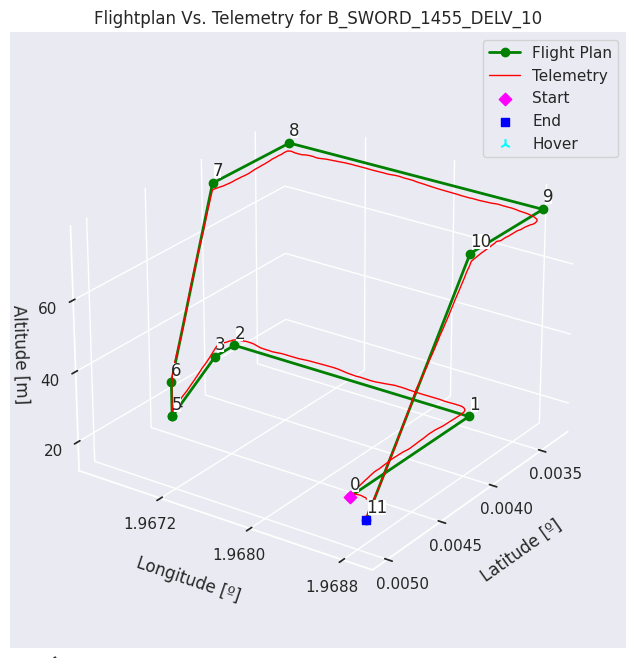

In [ ]:
plot_planVsTele('B_SWORD_1455_DELV_10')

In [ ]:
def subplotPlanVsUspace(name):
  ### subplots of latitudes, longitudes, altitudes of both FlightPlan and Telemetry in time

  ## read files
  uspace = pd.read_csv(dataUnzip +'UsPrediction_' + name + '.csv')
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")

  ## use planFix to get the 'time' column
  flightPlan0=planFix(name)

  ## create figure: 3 rows, one column
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

  ## subplot 1: longitude versus time
  ax1.plot(flightPlan0['time'], flightPlan['FPLlon'], color='green')
  ax1.plot(uspace['secs'], uspace['lon'], color='blue')
  ax1.plot(telemetry['secs'], telemetry['lon'], color='red')
  ax1.set_xlabel('Time [s]')
  ax1.set_ylabel('Longitude [º]')
  ax1.legend(["FlightPlan", "U-Space",'Telemetry'])
  ax1.set_title('Latitude Vs. Time')

  # subplot 2: latitude versus time
  ax2.plot(flightPlan0['time'], flightPlan['FPLlat'], color='green')
  ax2.set_xlabel('Time [s]')
  ax2.plot(uspace['secs'], uspace['lat'], color='blue')
  ax2.plot(telemetry['secs'], telemetry['lat'], color='red')
  ax2.set_ylabel('Latitude [º]')
  ax2.set_title('Longitude Vs. Time')

  # subplot 3: altitude versus time
  ax3.plot(flightPlan0['time'], flightPlan['FPLalt'], color='green')
  ax3.plot(uspace['secs'], uspace['alt'], color='blue')
  ax3.plot(telemetry['secs'], telemetry['alt'], color='red')
  ax3.set_xlabel('Time [s]')
  ax3.set_ylabel('Altitude [m]')
  ax3.set_title('Altitude Vs. Time')

  fig.suptitle('Plan Fix Vs. U-Space Prediction Vs. Telemetry for ' + name)
  fig.suptitle('Plan Fix Vs. U-Space Prediction for ' + name)
  plt.tight_layout()
  plt.show()

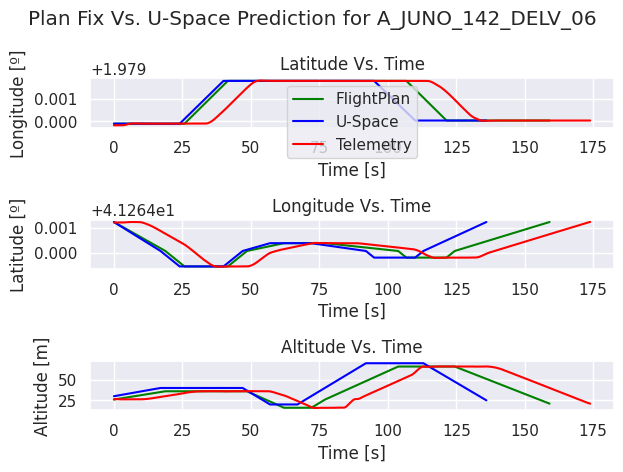

In [ ]:
subplotPlanVsUspace('A_JUNO_142_DELV_06')

In [ ]:
name = 'B_UTAH_980_DELV_02'
telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
uspace = pd.read_csv(dataUnzip +'UsPrediction_' + name + '.csv')
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')
flightPlan0=planFix(name)

In [ ]:
def definePlanSegment(flightPlan):
  ### get the type of segment from a flightplan, i.e Climb, Cruise, Hover or Descent

  ## add columns for the ending point of every segment by shifting the original one
  for (i, original), (j, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    flightPlan.at[i,'FPLlat1'] = shift['FPLlat']
    flightPlan.at[i,'FPLlon1'] = shift['FPLlon']
    flightPlan.at[i,'FPLalt1'] = shift['FPLalt']

  ## get the index of the Hovering point
  df_hover = flightPlan[flightPlan['WPname'].str.contains('Hover')]

  ## only keep the necessary columns and get rid of last row (n_segments = n_rows - 1)
  flightPlan = flightPlan[['FPLlat', 'FPLlon', 'FPLalt', 'FPLlat1', 'FPLlon1', 'FPLalt1','FPLturn']][:-1]

  ## get the segment type by comparing alitude changes (delta_z)
  for index, row in flightPlan.iterrows():
    delta_z=row['FPLalt1'] - row['FPLalt']
    if  (delta_z == 0):
      flightPlan.at[index,'type'] = "Cruise"
      #flightPlan.at[index,'type'] = 1

    elif delta_z > 0:
      flightPlan.at[index,'type'] = "Climb"
      #flightPlan.at[index,'type'] = 0

    else:
      flightPlan.at[index,'type'] = "Descent"
      #flightPlan.at[index,'type'] = 2

  ## Complete by adding the hover type
  for index, row in df_hover.iterrows():
    flightPlan.at[index-1,'type'] = 'Hover'
    #flightPlan.at[index-1,'type'] = 3

  return flightPlan['type']

In [ ]:
def definePlanOperator(name):
  operator = ''
  if 'JU' in name:
    operator = 'JUNO'
  if 'UT' in name:
    operator = 'UTAH'
  if 'OM' in name:
    operator = 'OMAHA'
  if 'SW' in name:
    operator = 'SWORD'
  return operator

In [ ]:
definePlanOperator('A_JUNO_142_DELV_06')

'JUNO'

In [ ]:
def defineDroneModel(name):
  ### get a number specifying the drone model for the passed name of flight
  ### works only with a general file containing all flights and their corresponding drone type
  ### Each drone model has an assigned number

  ## get the unique values of drones (strings)
  all = modeldrone['drone'].unique()

  ## get the particular string of the passsed plan name
  model = list(modeldrone.loc[modeldrone['id'] == name]['drone'])[0]

  ## convert the previous string to the equivalent number that represents it
  equivalent=np.where(all == model)[0][0]

  return equivalent

In [ ]:
defineDroneModel('B_OMAHA_1002_DELV_03')

2

In [ ]:
flightPlan = flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + '.csv')
definePlanSegment(flightPlan)

0       Climb
1      Cruise
2      Cruise
3      Cruise
4     Descent
5       Hover
6       Climb
7       Climb
8      Cruise
9      Cruise
10     Cruise
11    Descent
Name: type, dtype: object

In [ ]:
plot_plan("A_JUNO_142_DELV_06")

NameError: ignored

In [ ]:
#PlanVsTele3D("A_JUNO_142_DELV_06")

In [ ]:
def find_nearest(array, value):
  ### find closest value in array
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return array[idx]

# dist


In [ ]:
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
flightPlan.head(3)

In [ ]:
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import pyproj as pyproj
from pyproj import Transformer


utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=1.902373,
        south_lat_degree=41.252742,
        east_lon_degree=2.092643,
        north_lat_degree=41.311307,
    ),
)
utm_crs = CRS.from_epsg(utm_crs_list[0].code)
CRS('EPSG:4326').coordinate_system

CS[ellipsoidal,2],
    AXIS["geodetic latitude (Lat)",north,
        ORDER[1],
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    AXIS["geodetic longitude (Lon)",east,
        ORDER[2],
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]]

**def xy(lat, lon, ref_lat, ref_lon):**

From World Geodetic System 1984, used in GPS (WGS84 = EPSG:4326), in lat, lon to UTM zone 31N (EPSG:32631) in x,y
For EPSG:32

If always_xy=True (*wgs_utm31=Transformer.from_crs("EPSG:4326",'EPSG:32631',always_xy=True)*), the transform method will accept as input and return as output coordinates using the traditional GIS order, that is longitude, latitude for geographic CRS and easting, northing for most projected CRS.
  **x_p,y_p=wgs_utm31.transform(lon, lat)**


In [ ]:
from geographiclib.geodesic import Geodesic
'''
def xy(lat, lon, ref_lat, ref_lon):
  geod = Geodesic.WGS84
  geod = geod.Inverse(lat, lon, ref_lat, ref_lon)
  x= geod['s12']*math.cos(geod['azi1']*math.pi/180)
  y= geod['s12']*math.sin(geod['azi1']*math.pi/180)
  return x,y

from pyproj import Transformer
wgs_utm31=Transformer.from_crs("EPSG:4326",'EPSG:32631',always_xy=True)
def xy(lon, lat, ref_lon, ref_lat):
  x_ref, y_ref = wgs_utm31.transform(ref_lon,ref_lat)
  x_p,y_p=wgs_utm31.transform(lon, lat) #x_point
  x = x_ref - x_p # x -> equator
  y = y_ref - y_p # y -> meridian
  return x,y
'''
from pyproj import Transformer
wgs_utm31=Transformer.from_crs("EPSG:4326",'EPSG:32631',always_xy=True)
def xy(lon, lat, ref_lon, ref_lat):
  x_ref, y_ref = wgs_utm31.transform(ref_lon,ref_lat)
  x_p,y_p=wgs_utm31.transform(lon, lat) #x_point
  x = x_ref - x_p # x -> equator
  y = y_ref - y_p # y -> meridian
  return x,y

In [ ]:
flightPlan['x']=flightPlan.apply(lambda row: xy(row['FPLlon'], row['FPLlat'], flightPlan['FPLlon'][0], flightPlan['FPLlat'][0])[0], axis=1)
flightPlan['y']=flightPlan.apply(lambda row: xy(row['FPLlon'], row['FPLlat'], flightPlan['FPLlon'][0], flightPlan['FPLlat'][0])[1], axis=1)

Unnamed: 0      WPname     FPLlat    FPLlon  FPLalt  FPLvel  FPLturn  \
0            0   Waypoint1  41.265242  1.978901    26.0     7.0     65.0   
1            1   Waypoint2  41.264063  1.978901    36.0    10.0     34.0   
2            2   Waypoint3  41.263433  1.978900    36.0    10.0     34.0   
3            3   Waypoint4  41.263433  1.980789    36.0    10.0     34.0   
4            4   Waypoint5  41.264062  1.980790    36.0     3.0     17.0   
5            5   Waypoint6  41.264380  1.980790    16.0     0.0      0.2   
6            6    Hover10s  41.264380  1.980790    16.0     2.0      0.2   
7            7   Waypoint7  41.264380  1.980790    26.0     2.0      0.2   
8            8   Waypoint8  41.264062  1.980790    66.0    10.0     14.0   
9            9   Waypoint9  41.263792  1.980790    66.0    10.0     14.0   
10          10  Waypoint10  41.263793  1.979040    66.0    10.0     14.0   
11          11  Waypoint11  41.264063  1.979040    66.0     4.0     14.0   
12          12  Waypoint12  41.265242  1.979041    21.0     0.0     65.0   

             FPLwpt           x           y  
0   CurvaturePassed    0.000000    0.000000  
1   CurvaturePassed    1.600831  130.878683  
2   CurvaturePassed    2.455639  200.766219  
3   CurvaturePassed -155.785843  202.701114  
4   CurvaturePassed -156.640657  132.813600  
5          LineStop -157.072664   97.493998  
6          LineStop -157.072664   97.493998  
7   CurvaturePassed -157.072664   97.493998  
8   CurvaturePassed -156.640657  132.813600  
9   CurvaturePassed -156.274307  162.765392  
10  CurvaturePassed   -9.725533  160.973459  
11  CurvaturePassed  -10.091881  131.021657  
12  CurvaturePassed  -11.692998    0.119681

In [ ]:
planFix('A_JUNO_142_DELV_06')

Unnamed: 0      WPname           x           y           z  FPLvel  \
0            0   Waypoint1    0.000000    0.000000    0.000000     7.0   
1            1   Waypoint2   93.815988    3.179164  -91.820684    10.0   
2            2   Waypoint3  139.900295    4.738166 -144.374368    10.0   
3            3   Waypoint4  134.481675  162.948688 -144.431881    10.0   
4            4   Waypoint5   88.397368  161.389692  -91.878197     3.0   
5            5   Waypoint6   50.082657  160.082178  -78.509611     0.0   
6            6    Hover10s   50.082657  160.082178  -78.509611     2.0   
7            7   Waypoint7   57.594908  160.341990  -71.914266     2.0   
8            8   Waypoint8  110.934232  162.169131  -72.092287    10.0   
9            9   Waypoint9  130.684814  162.837278  -94.615340    10.0   
10          10  Waypoint10  135.703169   16.316490  -94.561988    10.0   
11          11  Waypoint11  115.952587   15.648341  -72.038936     4.0   
12          12  Waypoint12   -4.171731   11.560099   -3.284372     0.0   

    FPLturn           FPLwpt        time  
0      65.0  CurvaturePassed    0.000000  
1      34.0  CurvaturePassed   18.758718  
2      34.0  CurvaturePassed   25.750201  
3      34.0  CurvaturePassed   41.580530  
4      17.0  CurvaturePassed   48.572013  
5       0.2         LineStop   62.105699  
6       0.2         LineStop   72.105699  
7       0.2  CurvaturePassed   77.105699  
8      14.0  CurvaturePassed  103.791152  
9      14.0  CurvaturePassed  106.787516  
10     14.0  CurvaturePassed  121.448187  
11     14.0  CurvaturePassed  124.444551  
12     65.0  CurvaturePassed  159.061884

In [ ]:
plt.plot(flightPlan['x'], flightPlan['y'], linewidth = 2, linestyle = "-", color = "green")

# 3D plot

In [ ]:
import plotly.graph_objects as go
import numpy as np
x, y, z = flightPlan['FPLlon'], flightPlan['FPLlat'], flightPlan['FPLalt']
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')])
fig.show()

In [ ]:
import plotly.express as px
x, y, z = flightPlan['FPLlon'], flightPlan['FPLlat'], flightPlan['FPLalt']
#x1,y1,z1= telemetry['longitude'], telemetry['latitude'], telemetry['height_above_takeoff(meters)']
fig = px.line_3d(flightPlan, x, y,z)
#fig = px.line_3d(flightPlan, x1, y1,z1)

fig.show()

In [ ]:
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
flightPlan = flightPlan.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
flightPlan['type'] = 'FP'
flightPlan = flightPlan.rename(columns={'FPLlat': 'lat','FPLlon' : 'lon', 'FPLalt' : 'alt'})
flightPlan.head(3)

lat       lon   alt type
0  41.265242  1.978901  26.0   FP
1  41.264063  1.978901  36.0   FP
2  41.263433  1.978900  36.0   FP

In [ ]:
telemetry = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
telemetry = telemetry.drop(['Unnamed: 0', 'secs'], axis=1)

telemetry['type'] = 'TEL'

df3 = flightPlan.append(telemetry, ignore_index=True)

fig = px.line_3d(df3, x="lat", y="lon", z="alt", color='type')
fig.show()

# PlanVsTele3D

In [ ]:
import plotly.express as px

def PlanVsTele3D(name):
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  flightPlan = flightPlan.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
  flightPlan['type'] = 'FP'
  flightPlan = flightPlan.rename(columns={'FPLlat': 'lat','FPLlon' : 'lon', 'FPLalt' : 'alt'})

  telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")
  telemetry = telemetry.drop(['Unnamed: 0', 'secs'], axis=1)
  telemetry['type'] = 'TEL'

  df3 = flightPlan.append(telemetry, ignore_index=True)

  fig = px.line_3d(df3, x="lat", y="lon", z="alt", color='type')
  fig.show()

In [ ]:
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_A_OMAHA_401_DELV_01" + ".csv")
flightPlan = flightPlan.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
flightPlan['type'] = 'FP'
flightPlan = flightPlan.rename(columns={'FPLlat': 'lat','FPLlon' : 'lon', 'FPLalt' : 'alt'})
telemetry = pd.read_csv(dataUnzip + "Telemetry_A_OMAHA_401_DELV_01" + ".csv")
telemetry = telemetry.drop(['Unnamed: 0', 'secs'], axis=1)
telemetry['type'] = 'TEL'

df3 = flightPlan.append(telemetry, ignore_index=True)


<ipython-input-256-638b34e9ea9b>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = flightPlan.append(telemetry, ignore_index=True)


In [ ]:
import plotly.graph_objs as go
#name='A_JUNO_142_DELV_06';

def plotPlanTele3D(name):
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

  # create the 3D line trace
  line_trace = go.Scatter3d(
      x=flightPlan['FPLlat'],  # x-coordinates of the line
      y=flightPlan['FPLlon'],  # y-coordinates of the line
      z=flightPlan['FPLalt'],  # z-coordinates of the line
      mode='lines',
      line=dict(color='blue', width=2),
      name='Flight Plan'
  )
  line_trace2 = go.Scatter3d(
      x=telemetry.loc[::20]['lat'],  # x-coordinates of the line
      y=telemetry.loc[::20]['lon'],  # y-coordinates of the line
      z=telemetry.loc[::20]['alt'],  # z-coordinates of the line
      mode='lines',
      line=dict(color='pink', width=4),
      name='Telemetry'
  )

  # create the point trace
  point_trace = go.Scatter3d(
      x=np.asarray(flightPlan['FPLlat'][0]),  # x-coordinate of the point
      y=np.asarray(flightPlan['FPLlon'][0]),  # y-coordinate of the point
      z=np.asarray(flightPlan['FPLalt'][0]),  # z-coordinate of the point
      mode='markers',
      marker=dict(color='green', size=5, symbol='circle'),
      name='Start'
  )
  point_trace2 = go.Scatter3d(
      x=np.asarray(flightPlan['FPLlat'][-1:]),  # x-coordinate of the point
      y=np.asarray(flightPlan['FPLlon'][-1:]),  # y-coordinate of the point
      z=np.asarray(flightPlan['FPLalt'][-1:]),  # z-coordinate of the point
      mode='markers',
      marker=dict(color='red', size=5, symbol='circle'),
      name='End'
  )

  ind0=10
  point_trace3 = go.Scatter3d(
      x=np.asarray(flightPlan['FPLlat'][ind0]),  # x-coordinate of the point
      y=np.asarray(flightPlan['FPLlon'][ind0]),  # y-coordinate of the point
      z=np.asarray(flightPlan['FPLalt'][ind0]),  # z-coordinate of the point
      mode='markers',
      marker=dict(color='purple', size=5, symbol='circle'),
      name='Fpl'
  )

  ind=telemetry.index[telemetry['secs'] == 124.4].tolist()

  point_trace4 = go.Scatter3d(
      x=np.asarray(telemetry['lat'][ind]),  # x-coordinate of the point
      y=np.asarray(telemetry['lon'][ind]),  # y-coordinate of the point
      z=np.asarray(telemetry['alt'][ind]),  # z-coordinate of the point
      mode='markers',
      marker=dict(color='orange', size=5, symbol='circle'),
      name='Tel' + str(telemetry['secs'][ind])
  )
  '''
  point_traceN = []
  for point in df_pairs_threshold[0]:
      point_traceN.append(go.Scatter3d(
      x=np.asarray(telemetry['lat'][point]),  # x-coordinate of the point
      y=np.asarray(telemetry['lon'][point]),  # y-coordinate of the point
      z=np.asarray(telemetry['alt'][point]),  # z-coordinate of the point
      mode='markers',
      marker=dict(color='red', size=3, symbol='circle'),
      name='tel'
          ))
  '''
  # create the figure and add the traces
  #fig = go.Figure(data=[line_trace, line_trace2, point_trace, point_trace2])
  plot = go.Figure(data=[line_trace, line_trace2, point_trace, point_trace2,point_trace3, point_trace4])
  '''
  i=0;
  for trace in point_traceN:
    plot.add_trace(point_traceN[i])
    i=i+1;
  plot.add_trace(point_trace2)
  plot.add_trace(line_trace2)
  plot.add_trace(line_trace)
  '''

  # add layout options, such as axis titles and background color
  plot.update_layout(
      scene=dict(xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'),
      scene_bgcolor='white'
  )

  # show the figure
  plot.show()

In [ ]:
plotPlanTele3D("A_JUNO_142_DELV_06")

In [ ]:
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + ".csv")
telemetry = pd.read_csv(dataUnzip + "Telemetry_" + 'A_JUNO_142_DELV_06' + ".csv")

ind=telemetry.index[telemetry['secs'] == 18.9].tolist()
p0= [flightPlan.loc[1,'FPLlat'], flightPlan.loc[1,'FPLlon'], flightPlan.loc[1,'FPLalt']]
p1= [telemetry.loc[ind,'lat'].values, telemetry.loc[ind,'lon'].values, telemetry.loc[ind,'alt'].values]

from geopy import distance
distance_2d= distance.distance(p0[:2], p1[:2]).m
#2D geodesic distance in meters
print(distance_2d)
# 3D euclidean distance
distance_3d = np.sqrt(distance_2d**2 + (p1[2] - p0[2])**2)
print(distance_3d)


76.90590091669297
[77.13188443]


In [ ]:
PlanVsTele3D("B_UTAH_1514_DELV_01")

In [ ]:
flightPlanCSV = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
flightPlanCSV = flightPlanCSV.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
flightPlanCSV = flightPlanCSV.rename(columns={'FPLlat': 'lat','FPLlon' : 'lon', 'FPLalt' : 'alt'})

flightPlanCSV.to_csv('intended.csv')

In [ ]:
telemetryCSV = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
telemetryCSV = telemetryCSV.drop(['Unnamed: 0'], axis=1)
telemetryCSV.to_csv('real.csv')

# align

In [ ]:
telemetry = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
predict = pd.read_csv(dataUnzip + "UsPrediction_A_JUNO_142_DELV_06.csv")


In [ ]:
from scipy import signal


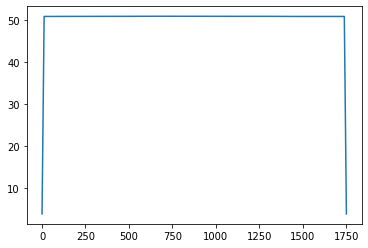

In [ ]:
plt.plot(signal.correlate(flightPlan['FPLlon'], telemetry['lon']))


In [ ]:
#plt.plot(flightPlan['FPLlon'], flightPlan['FPLlat'])
plt.plot(predict['secs'], predict['lon'])

target = [telemetry]
for target in target:
    dx = np.mean(np.diff(predict['secs'].values))
    shift = (np.argmax(signal.correlate(predict['lon'], target['lon'])) - len(target['lon'])) * dx
    plt.plot(target['secs'] + shift, target['lon'])

Unnamed: 0  Unnamed: 0.1       lon        lat  alt  secs
0            0             0  1.978901  41.265242   30     0
1            1             1  1.978901  41.264063   40    17
2            2             2  1.978900  41.263433   40    24
3            3             3  1.980789  41.263433   40    40
4            4             4  1.980790  41.264062   40    47
5            5             5  1.980790  41.264380   20    57
6            6             6  1.980790  41.264380   20    67
7            7             7  1.980790  41.264380   30    72
8            8             8  1.980790  41.264062   70    92
9            9             9  1.980790  41.263792   70    95
10          10            10  1.979040  41.263793   70   110
11          11            11  1.979040  41.264063   70   113
12          12            12  1.979041  41.265242   25   136

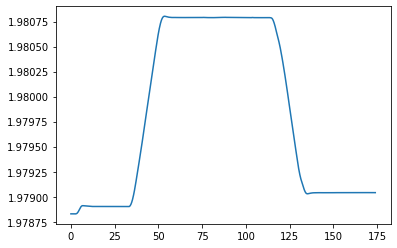

In [ ]:
plt.plot(telemetry['secs'], telemetry['lon'])


In [ ]:
from pyproj import Geod
geod = Geod("+ellps=WGS84")
points = geod.npts(lon1=1.97890135,
                   lat1=41.26524176,
                   lon2=1.9789006061137056,
                   lat2=41.26406284600235,
                   npts=5
                  )

[(1.9789012260170926, 41.26504527435055),
 (1.9789011020349285, 41.264848788694366),
 (1.9789009780535078, 41.26465230303146),
 (1.9789008540728306, 41.26445581736183),
 (1.9789007300928965, 41.26425933168546)]

<ipython-input-58-b3903d872085>:4: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.



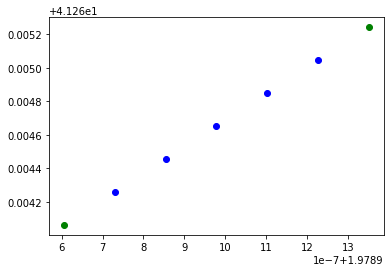

In [ ]:
px = [item[0] for item in points]
py = [item[1] for item in points]
plt.plot(px, py, 'bo')
plt.plot(predict['lon'].iloc[0:2], predict['lat'].iloc[0:2], 'bo', color='green')

In [ ]:
#plt.plot(flightPlan['FPLlon'], flightPlan['FPLlat'])
plt.plot(predict['secs'], predict['lon'])

target = [telemetry]
for target in target:
    dx = np.mean(np.diff(predict['secs'].values))
    shift = (np.argmax(signal.correlate(predict['lon'], target['lon'])) - len(target['lon'])) * dx
    plt.plot(target['secs'] + shift, target['lon'])

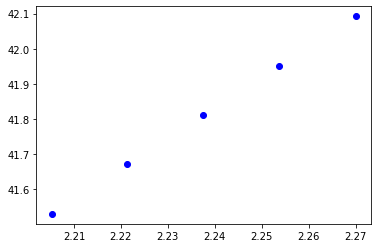

In [ ]:
from pyproj import Geod
geod = Geod("+ellps=WGS84")

points1 = geod.npts(lon1=2.189208,
                   lat1=41.388654,
                   lon2=2.286499,
                   lat2=42.233109,
                   npts=5
                  )
points2 = geod.npts(lon1=2.550310,
                   lat1=41.388654,
                   lon2=2.651015,
                   lat2=42.248134,
                   npts=5
                  )
px1 = [item[0] for item in points1]
py1 = [item[1] for item in points1]
px2 = [item[0] for item in points2]
py2 = [item[1] for item in points2]

plt.plot(px1, py1, 'bo')
#plt.plot(px2, py2, 'bo')

d1 = {'lat': py1, "lon" : px1}
df1 = pd.DataFrame(data=d1)

d2 = {'lat': py2, "lon" : px2}
df2 = pd.DataFrame(data=d2)



<ipython-input-122-e86ace7434e0>:15: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.



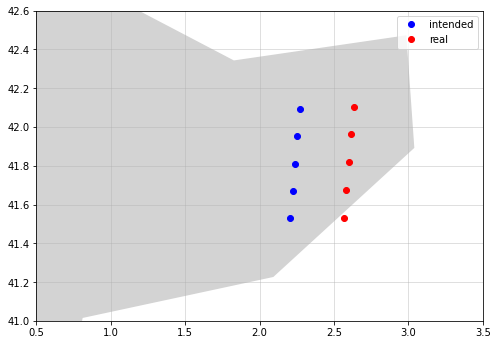

In [ ]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(
     gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "Spain"].plot(color="lightgrey",
                                                 ax=ax)
ax.set_xlim(0.5, 3.5)
ax.set_ylim(41, 42.6)

plt.plot(px1, py1, 'bo', label="intended")
plt.plot(px2, py2, 'ro', label='real')

# add grid
ax.grid(b=True, alpha=0.5)
plt.legend()
plt.show()

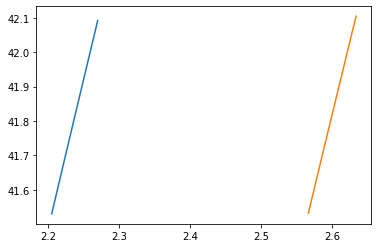

In [ ]:
plt.plot(df1['lon'], df1['lat'])
for target in [df2]:
    dx = np.mean(np.diff(df1['lon'].values))
    shift = (np.argmax(signal.correlate(df1['lat'], target['lat'])) - (len(target['lat'])-1)) * dx
    plt.plot(target['lon'] + shift, target['lat'])

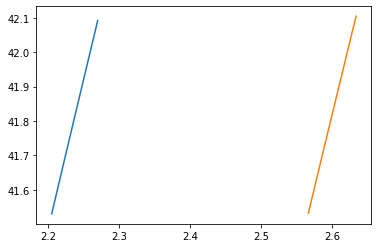

In [ ]:
plt.plot(df1['lon'], df1['lat'])
plt.plot(df2['lon'], df2['lat'])

# test0


In [ ]:
pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 3.0 MB 6.2 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tslearn: filename=tslearn-0.5.3.2-py3-none-any.whl size=358167 sha256=331b86c83b66dfb30b528356516c6eb97469140f09b9fc10495567b9305e5c4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3qq_4kur/wheels/46/ae/76/45bf2e989e5ef22b76c70e43c48a587f36d02d63c8ded68a12
Successfully built tslearn


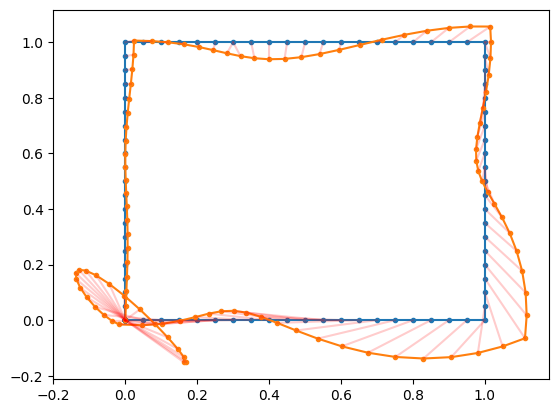

In [ ]:
import scipy
from scipy.spatial.distance import cdist
import numpy as np

import tslearn
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics

np.random.seed(42)

intended_trajectory = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]) # just a square
T_fin = len(intended_trajectory)
intended_interp = scipy.interpolate.interp1d(np.arange(T_fin), intended_trajectory, axis=0, bounds_error=False, fill_value=[0,0])

N = 100
time = np.linspace(0, T_fin, N, endpoint=False, dtype=np.float64)
sampled_pts = intended_interp(time)
deviation = np.zeros_like(sampled_pts)
deviation[:, 0] = (0.1 * np.sin(time * 2.7 + 0.2) + 0.1 * np.sin(time * 6.6 + 0.97)) * np.linspace(0, 1, N)
deviation[:, 1] = (0.12 * np.sin(time * 3.2 + 0.5) + 0.1 * np.sin(time * 7.4 + 0.12)) * np.linspace(0, 1, N)
real_trajectory = sampled_pts + deviation

dtw_output = tslearn.metrics.dtw_path(real_trajectory, sampled_pts)

plt.figure("closest distances", clear=True)
plt.plot(sampled_pts[:, 0], sampled_pts[:, 1], "o-", ms=3)
plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], "o-", ms=3)
for a, ind in zip(real_trajectory, dtw_output[0]):
    b = sampled_pts[ind[1]]
    plt.plot([a[0], b[0]], [a[1], b[1]], "r-", alpha=0.2)
plt.show()

In [ ]:
intended_trajectory = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]) # just a square
T_fin = len(intended_trajectory)
intended_interp = scipy.interpolate.interp1d(np.arange(T_fin), intended_trajectory, axis=0, bounds_error=False, fill_value=[0,0])

N = 100
time = np.linspace(0, T_fin, N, endpoint=False, dtype=np.float64)
sampled_pts = intended_interp(time)
deviation = np.zeros_like(sampled_pts)
deviation[:, 0] = (0.1 * np.sin(time * 2.7 + 0.2) + 0.1 * np.sin(time * 6.6 + 0.97)) * np.linspace(0, 1, N)
deviation[:, 1] = (0.12 * np.sin(time * 3.2 + 0.5) + 0.1 * np.sin(time * 7.4 + 0.12)) * np.linspace(0, 1, N)
real_trajectory = sampled_pts + deviation

In [ ]:
def find_closest(expected: np.ndarray, real: np.ndarray) -> np.ndarray:
    d = expected.shape[1]
    M = expected.shape[0]
    N = real.shape[0]
    assert expected.shape == (M, d), expected.shape
    assert real.shape == (N, d), real.shape

    closest_inds = np.zeros((N,), dtype=int)
    closest_inds[0] = np.argmin(cdist(real[:1, :], expected).reshape(-1))
    for i in range(1, N):
        cur_pnt = real[i, :]
        previous_closest = closest_inds[i - 1]
        # search back and forth from this index only to the local minimum
        closest_dist = None
        closest_ind = None
        for j in range(previous_closest - 1, -1, -1):
            dst = np.linalg.norm(cur_pnt - expected[j, :])
            if closest_dist is None or dst <= closest_dist:
                closest_dist = dst
                closest_ind = j
            else:
                break
        for j in range(previous_closest, M):
            dst = np.linalg.norm(cur_pnt - expected[j, :])
            if closest_dist is None or dst <= closest_dist:
                closest_dist = dst
                closest_ind = j
            else:
                break
        # and take that as the new closest
        closest_inds[i] = closest_ind
    return closest_inds

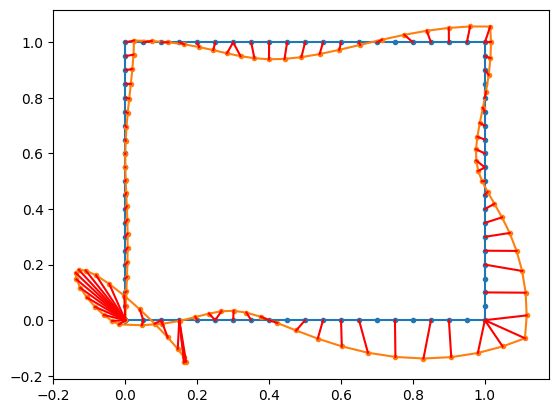

In [ ]:
closest_inds = find_closest(expected=sampled_pts, real=real_trajectory)
plt.figure("closest distances", clear=True)
plt.plot(sampled_pts[:, 0], sampled_pts[:, 1], "o-", ms=3)
plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], "o-", ms=3)
for a, ind in zip(real_trajectory, closest_inds):
    b = sampled_pts[ind]
    plt.plot([a[0], b[0]], [a[1], b[1]], "r-")
plt.show()

In [ ]:
flightPlanDist = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
flightPlanDist = flightPlanDist.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
flightPlanDist = flightPlanDist.rename(columns={'FPLlat': 'lat','FPLlon' : 'lon', 'FPLalt' : 'alt'})

telemetryDist = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
telemetryDist = telemetryDist.drop(['Unnamed: 0'], axis=1)

lat       lon   alt   secs
0     41.265222  1.978828  26.1    0.0
1     41.265222  1.978828  26.2    0.1
2     41.265222  1.978828  26.4    0.2
3     41.265222  1.978828  26.5    0.3
4     41.265222  1.978828  26.5    0.4
...         ...       ...   ...    ...
1735  41.265237  1.979040  21.3  173.5
1736  41.265240  1.979040  21.2  173.6
1737  41.265242  1.979040  21.2  173.7
1738  41.265244  1.979040  21.1  173.8
1739  41.265246  1.979040  21.0  173.9

[1740 rows x 4 columns]

In [ ]:
flightPlanDist['points'] = gpd.points_from_xy(flightPlanDist['lon'], flightPlanDist['lat'], flightPlanDist['alt'])
x_array = flightPlanDist['points'].to_numpy()
y_array = flightPlanDist['FPLlat'].to_numpy()

array([<POINT Z (1.979 41.265 26)>, <POINT Z (1.979 41.264 36)>,
       <POINT Z (1.979 41.263 36)>, <POINT Z (1.981 41.263 36)>,
       <POINT Z (1.981 41.264 36)>, <POINT Z (1.981 41.264 16)>,
       <POINT Z (1.981 41.264 16)>, <POINT Z (1.981 41.264 26)>,
       <POINT Z (1.981 41.264 66)>, <POINT Z (1.981 41.264 66)>,
       <POINT Z (1.979 41.264 66)>, <POINT Z (1.979 41.264 66)>,
       <POINT Z (1.979 41.265 21)>], dtype=object)

In [ ]:
closest_inds = find_closest(expected=sampled_pts, real=real_trajectory)
plt.figure("closest distances", clear=True)
plt.plot(sampled_pts[:, 0], sampled_pts[:, 1], "o-", ms=3)
plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], "o-", ms=3)
for a, ind in zip(real_trajectory, closest_inds):
    b = sampled_pts[ind]
    plt.plot([a[0], b[0]], [a[1], b[1]], "r-")
plt.show()



# Compute Error



First we are going to **increase the number of points** from the FlightPlan trajectory. The trajectory will remain the same but with a higher number of points that will be used to compute their distance to the telemetry path. The idea is to take two consecutive points of the FlightPlan and get the function of the line that connects them.

This way, we have a **function** *f(x)*, where:
- *f(0)=origin_point*
- *f(1)=end_point*
- for *0 ≤ x ≤ 1*

We don't take into consideration values outisde the range of *x ∈  [0,1]* as we only want to add points in the imaginary line that links two consecutive points of the FlightPlan, this is adding points only in-between the origin point (for x=0) and the end point (for x=1) of every segment that makes the FlightPlan.

Essentially, with an **origin_point = (lat0, lon0, alt0)** and an **end_point = (lat1, lon1, alt1)**

- FPLlat(x), where FPLlat(0)=lat0 and FPLlat(1)=lat1
- FPLlon(x), where FPLlon(0)=lon0 and FPLlon(1)=lon1
- FPLalt(x), where FPLalt(0)=alt0 and FPLalt(1)=alt1

Therefore, we can take as many values *x* as we want to get points in the line as long as *0 ≤ x ≤ 1*, so for instance, considering that the FlightPlan is made by straight lines connecting the waypoints, FPLlat(x) = (lat1 - lat0) * x + lat0 so if lat0=0 and lat1=10, FPLlat(0.5)=5, as expected, the middle point.

---

In order to do this, what we are doing is to use ```scipy.interpolate.interp1d``` [1]. As the name suggests, this is a function that find a function(s) from given values of x and y. We are just providing two points so the interpolation is perfect, as by default this function does linear interpolation and by providing two points, it simply creates the line that contains the two points.

>[1] scipy.interpolate.interp1d:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html


We first read the two CSVs: FlightPlan and Telemetry, from a given flight. We create the dataframe *df_flightPlan* from the FlightPlan file and the dataframe *df_telemetry* from the Telemetry file. Also we need to import the necessary libraries that will be used, `scipy`, `numpy` and `matplotlib`.

Our first objective is to **increase the number of points in the FlightPlan**, in this case, we will **add 50 points in each segment**, so for a FlightPlan determinted by 12 waypoints, we will end up with 12*50=600 points. This is done by iterating the interpolation function `scipy.interpolate.interp1d` 50 times with values from 0 to 1, using `np.linspace(0, 1, 50)` we get an array from 0 to 1, both included, with 48 other extra equally-spaced values in between.

We have to provide the function the two points, origin and end, which are **consecutive points** (rows) in df_flightPlan. In order to do this, we simply create a shifted copy of df_flightPlan that starts a point later than the original df_flightPlan with the use of `df_shift = df_flightPlan.iloc[1:]`. Doing this, reduces the length (rows) of the dataframe by one, so len(df_shift)=len(df_flightPlan)-1. Therefore, we need to trim the unshifted (df_original) datframe by one row (the last one) so that both of them have the same lenght using `df_original = df_flightPlan.iloc[:-1]`. Now, for the same index (same row number) in both dataframes, we will get the origin point and end point so that origin will be in `original.iloc[0]` and the end in `shift.iloc[0]`. This comes in handy to use a for loop as we are always usign the same row index for both dataframes. To get the 50 points, we need to just provide **a single origin_point and also a single end_point** to the interpolate function. Providing the whole dataframe would create a line that is close to all waypoints, like a regression line and that's not what we want. In order to do this, we have to use `scipy.interpolate.interp1d` as many times as segments exist in the dataframe. The number of segments is just obtained by subtracting 1 to the number of waypoints in the FlightPlan, which is essentially what has been done before in the *df_original* and *df_shift* dataframes. Then, in each iteration, we take a row of each dataframe, get the origin_point from the df_original and the end_point from df_shift, with these two we obtain the line equation(s) *f(x)* to which we will pass the 50 numbers from 0 to 1, this is `f(np.linspace(0, 1, 50))` where `f=scipy.interpolate.interp1d([0, 1],[[origin_point],[end_point])` with the rest of parameters needed for the function (axis, fill_value...). This will give us 50 points in-between the first two consecutive points of df_flightPlan. We are creating a new dataframe `df_flightPlanExpanded` which **will contain all these groups of 50 points generated in each iteration**, so in every iteration we are appending 50 points to it. This can be done with `pd.concat`. All the iterations are done with `pandas.DataFrame.iterrows` which, as the name suggests, iterates over the rows. We are using `zip` which pairs, in tuples, the items of the passed iterators. So the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together, etc. Put simply, in each iteration, it will create **a tuple storing 2 other tuples, each of these tuples contains two items: an integer (int) being the index of the row and a series (pandas.Series) containing the information about the row (lat, lon, alt...).**
>zip → (tuple1, tuple2) → ((int1, series1), (int2, series2)) → ((int1, [WPname1,	FPLlat1, FPLlon1, FPLalt1...]), (int2, [WPname2,	FPLlat2, FPLlon2, FPLalt2...]))

We don't need the first items from the each tuple (int1 and int2) as it is just an integer indicating the index of the iterated row. Both int1 and int2 are the same from what has been said before about the same index of row gets the origin_point from df_original and end_point from df_shift. Therefore we just care about the series (series1 from tuple1 and series2 from tuple2). We obtain these with `(_, original), (_, shift)`. So `original[FPLlat]` returns the latitude of the origin_point from the row that we're iterating and `shift[FPLlat]` returns the latitude of the end_point.

Finally we reset the index of *df_flightPlanExtended* because otherwise it keeps the indexing from each concatenation, going from 0 to 50 and then starting again from 0 to 50, what we want is that it goes from 0 to 600 (number of points).


In [ ]:
def computeMaxErrorPlots(name):
  #name='A_JUNO_142_DELV_06'
  #pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")


  import scipy
  import numpy as np
  import matplotlib.pyplot as plt

  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 50)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)
  #a=df_flightPlan.iloc[:-1].iterrows()
  #print(list(a)[0])

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  lat0=df_flightPlan['FPLlat'][0]
  lon0=df_flightPlan['FPLlon'][0]
  h0=df_flightPlan['FPLalt'][0]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],df_flightPlanExpanded.at[index,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],df_telemetry.at[index,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)

  ## Plot

  fig = plt.figure()
  ax = plt.axes(projection="3d")

  # Data for a three-dimensional line
  zline = df_flightPlanExpanded["FPLalt"]
  xline = df_flightPlanExpanded["FPLlon"]
  yline = df_flightPlanExpanded["FPLlat"]
  ax.plot3D(xline, yline, zline, "green", alpha=0.5)
  zline = df_telemetry["alt"]
  xline = df_telemetry["lon"]
  yline = df_telemetry["lat"]
  ax.plot3D(xline, yline, zline, "red", alpha=0.5)
  ##
  import tslearn.metrics

  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  df_pairs = pd.DataFrame(dtw_output[0])

  fig = plt.figure()
  plt.plot(df_pairs[0], df_pairs[1])

  fig = plt.figure()
  plt.plot(
      np.diag(
          scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          )
      )
  )
  df_pairs['dist']=np.diag(scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          ))

  df_pairs_threshold=(df_pairs[(df_pairs[['dist']]>3).all(axis=1)])
  e_max=df_pairs['dist'].nlargest(5).mean()
  return df_pairs

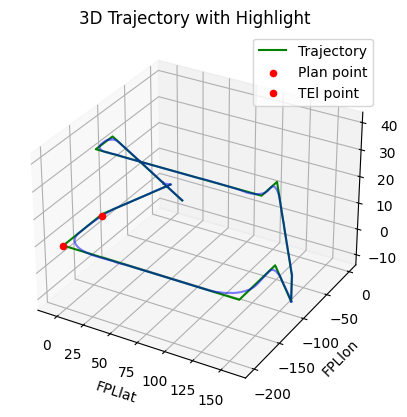

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
df=df_flightPlanExpanded

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['FPLlat'], df['FPLlon'], df['FPLalt'], c='green', label='Trajectory')
ax.plot3D(df_telemetry['lat'], df_telemetry['lon'], df_telemetry['alt'], "blue", alpha=0.5)

# specific index
highlight_index = 100
highlight_point = df.loc[highlight_index]
ax.scatter(highlight_point['FPLlat'], highlight_point['FPLlon'], highlight_point['FPLalt'], c='red', label='Plan point')

#telemetry index
highlight_index2=290
highlight_point2 = df_telemetry.loc[highlight_index2]
ax.scatter(highlight_point2['lat'], highlight_point2['lon'], highlight_point2['alt'], c='red', label='TEl point')


ax.set_xlabel('FPLlat')
ax.set_ylabel('FPLlon')
ax.set_zlabel('FPLalt')
ax.set_title('3D Trajectory with Highlight')

ax.legend()

plt.show()


0    1
0        0    0
1        1    0
2        2    0
3        3    0
4        4    0
...    ...  ...
1756  1735  599
1757  1736  599
1758  1737  599
1759  1738  599
1760  1739  599

[1761 rows x 2 columns]

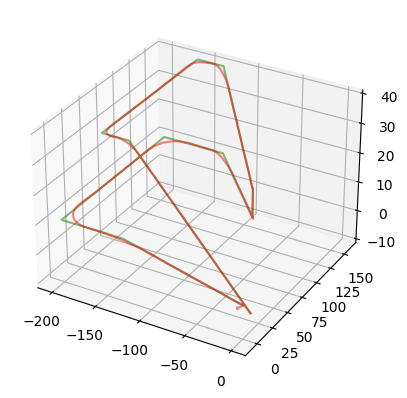

In [ ]:
computeMaxErrorPlots('A_JUNO_142_DELV_06')

In [ ]:
def computeAvgError(name):
  #pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")


  import scipy
  import numpy as np
  import matplotlib.pyplot as plt

  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 50)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)
  #a=df_flightPlan.iloc[:-1].iterrows()
  #print(list(a)[0])

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  lat0=df_flightPlan['FPLlat'][0]
  lon0=df_flightPlan['FPLlon'][0]
  h0=df_flightPlan['FPLalt'][0]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],df_flightPlanExpanded.at[index,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],df_telemetry.at[index,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)

  ##
  import tslearn.metrics

  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  df_pairs = pd.DataFrame(dtw_output[0])
  '''
  fig = plt.figure()
  plt.plot(df_pairs[0], df_pairs[1])

  fig = plt.figure()
  plt.plot(
      np.diag(
          scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          )
      )
  )
  '''
  df_pairs['dist']=np.diag(scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          ))

  df_pairs_threshold=(df_pairs[(df_pairs[['dist']]>3).all(axis=1)])
  e_max=df_pairs['dist'].nlargest(3).mean()
  return df_pairs['dist'].mean(), e_max

1.4894530057861426

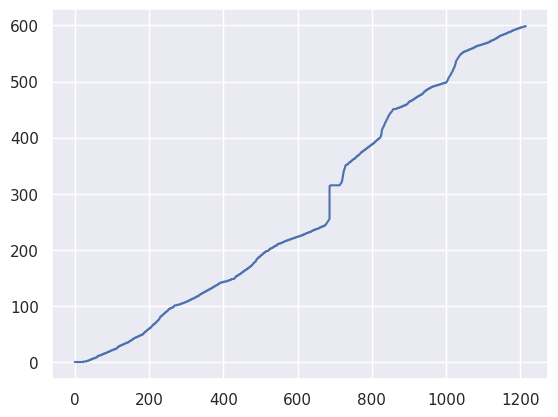

In [ ]:
cmep=computeMaxErrorPlots('B_SWORD_1582_DELV_09')
plt.plot(cmep[1],cmep[0])
computeAvgError('B_SWORD_1582_DELV_09')

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})
#
dataset0['avg']=dataset0.apply(lambda x: computeAvgError(x['ID'])[0], axis=1)
print(dataset0.loc[dataset0['avg']>=20])
#dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)



```
                     ID        avg
0   A_OMAHA_401_DELV_01  34.978104
32  B_UTAH_1006_DELV_01  62.272099
36  A_OMAHA_128_DELV_01  27.542285
65   A_UTAH_391_DELV_07  22.722760
67  A_OMAHA_411_DELV_08  35.686670
```


```
                      ID         max
0    A_OMAHA_401_DELV_01  164.232920
2    C_OMAHA_895_DELV_07  546.733617
15  B_OMAHA_1505_DELV_04  344.288035
18    A_JUNO_399_DELV_09  168.138181
31   B_OMAHA_626_DELV_03  219.976219
32   B_UTAH_1006_DELV_01  793.807503
35  B_OMAHA_1002_DELV_03  229.335179
36   A_OMAHA_128_DELV_01  164.819868
53  B_OMAHA_1556_DELV_03  221.611771
54   B_UTAH_1485_DELV_01  109.581935
65    A_UTAH_391_DELV_07  214.546941
67   A_OMAHA_411_DELV_08  235.730072
```




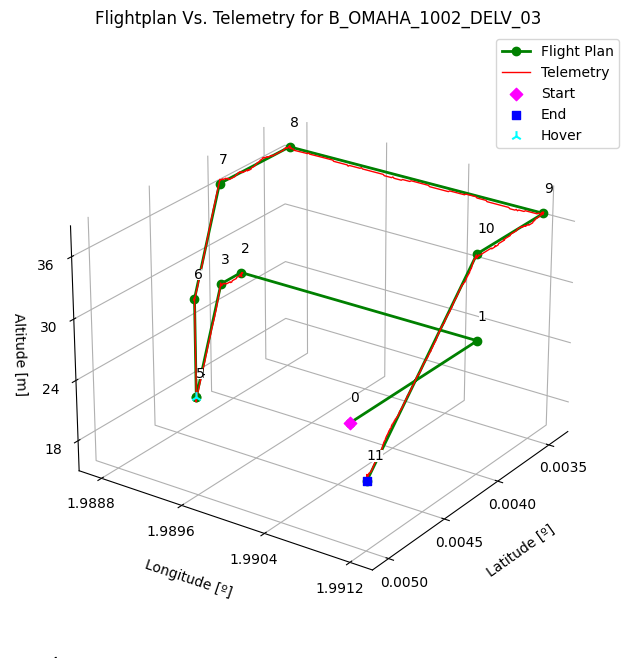

In [ ]:
plot_planVsTele('B_OMAHA_1002_DELV_03')

In [ ]:
Errors = pd.DataFrame()

for ind, row in dataset0.iterrows():
    errors = computeAvgError(row['ID'])
    data = pd.DataFrame({"avg": [errors[0]],'max':[errors[1]],'id':row['ID']})
    Errors = pd.concat([Errors, data])


avg         max                    id
0   34.978104  164.232920   A_OMAHA_401_DELV_01
0    1.697593   24.796079    A_JUNO_409_DELV_08
0   11.607098  546.733617   C_OMAHA_895_DELV_07
0    3.456381   25.026285   B_JUNO_1422_DELV_10
0    2.292463   20.939461  B_OMAHA_1479_DELV_05
..        ...         ...                   ...
0   35.686670  235.730072   A_OMAHA_411_DELV_08
0    1.316438   21.006525   C_OMAHA_547_DELV_04
0    0.799034    2.632975   B_UTAH_1093_DELV_01
0    0.928938   10.970473    A_JUNO_142_DELV_06
0    0.778688    6.869317    B_UTAH_529_DELV_02

[72 rows x 3 columns]

In [ ]:
dtw_paths = pd.DataFrame()
for ind, row in dataset0.iterrows():
  dtw = computeMaxErrorPlots(row['ID'])
  dtw['i']=ind
  if 'JU' in row['ID']:
    dtw['id'] = 'JUNO'
  if 'UT' in row['ID']:
    dtw['id'] = 'UTAH'
  if 'OM' in row['ID']:
    dtw['id'] = 'OMAHA'
  if 'SW' in row['ID']:
    dtw['id'] = 'SWORD'
  dtw_paths = pd.concat([dtw_paths, dtw])
dtw_paths.head(2)



0  1  i    id
0  0  0  0  JUNO
1  1  0  0  JUNO

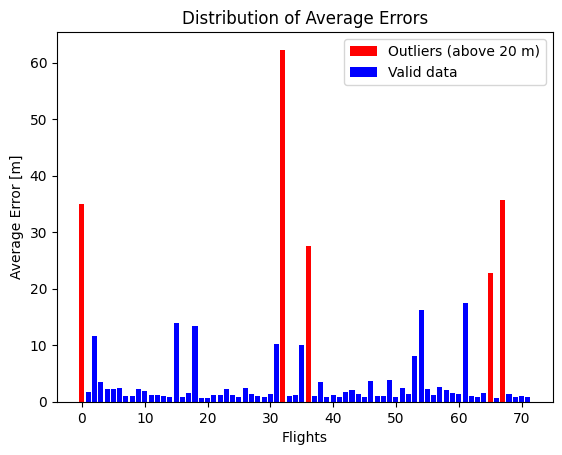

In [ ]:
avg_values = Errors['avg']

colors = np.where(avg_values > 20, 'red', 'blue')

fig, ax = plt.subplots()

ax.bar(range(len(avg_values)), avg_values, color=colors)

ax.set_xlabel('Flights')
ax.set_ylabel('Average Error [m]')
ax.set_title('Distribution of Average Errors')

red_patch = plt.Rectangle((0, 0), 1, 1, fc='red')
blue_patch = plt.Rectangle((0, 0), 1, 1, fc='blue')
handles = [red_patch, blue_patch]
labels = ['Outliers (above 20 m)', 'Valid data']

ax.legend(handles, labels)
plt.show()


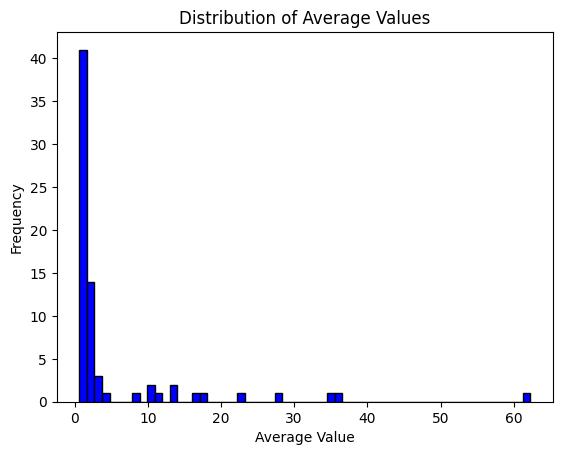

In [ ]:
avg_values = Errors['avg']

fig, ax = plt.subplots()

# histogram
ax.hist(avg_values, bins=60, color='blue', edgecolor='black')

ax.set_xlabel('Average Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Average Values')

plt.show()


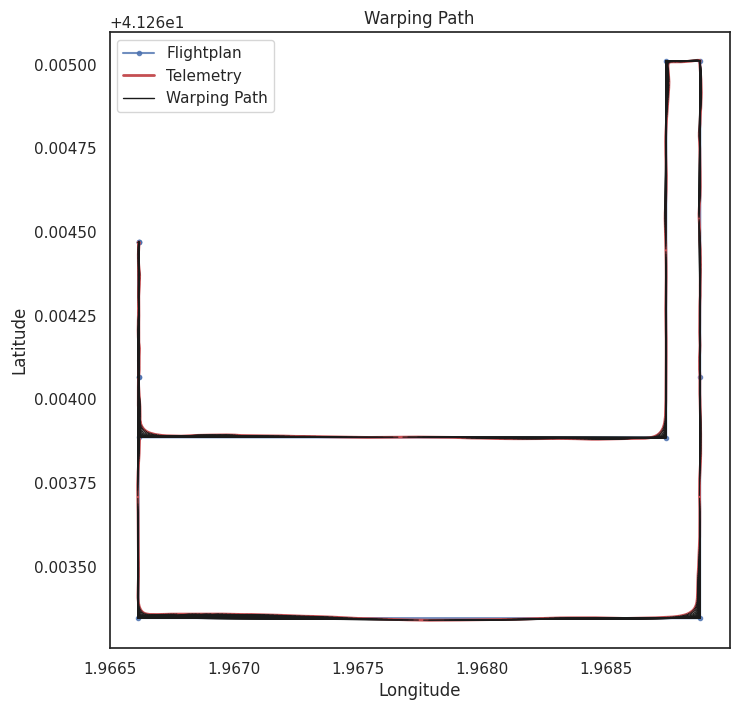

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tslearn import metrics
import pandas as pd
name='B_SWORD_1455_DELV_10'

flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

# dataframes to numpy arrays
s_x = np.array(flightplan[['FPLlat', 'FPLlon', 'FPLalt']])
s_y = np.array(telemetry[['lat', 'lon', 'alt']])

path, _ = metrics.dtw_path(s_x, s_y)

# warping path
plt.figure(figsize=(8, 8))
plt.plot(s_x[:, 1], s_x[:, 0], 'bo-', label='Flightplan', markersize=3, alpha=0.8)
plt.plot(s_y[:, 1], s_y[:, 0], '-', color='r', label='Telemetry', linewidth=2)

for i, j in path:
    plt.plot([s_x[i, 1], s_y[j, 1]], [s_x[i, 0], s_y[j, 0]], 'k-', linewidth=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Warping Path')
plt.plot([],[], 'k-', linewidth=1, label='Warping Path')

plt.legend()
ax.grid(True)
ax.set_ylim(41.126e1+0.00325, 41.126e1+0.00425)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.show()



In [ ]:

flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

s_x = np.array(flightplan[['FPLlat', 'FPLlon', 'FPLalt']])
s_y = np.array(telemetry[['lat', 'lon', 'alt']])

#  DTW path
path, _ = metrics.dtw_path(s_x, s_y)

#
x_flightplan = s_x[:, 1]  # FPLlon
y_flightplan = np.arange(len(x_flightplan))
x_telemetry = s_y[:, 1]  # lon
y_telemetry = np.arange(len(x_telemetry))

# telemetry and flightplan
plt.figure(figsize=(10, 6))
plt.plot(x_flightplan, y_flightplan, 'r', label='Flightplan')
plt.plot(x_telemetry, y_telemetry, 'b', label='Telemetry')

# warping path as a scatter plot
for i, j in path:
    plt.scatter(x_telemetry[j], y_telemetry[j], c='g', s=50, marker='o')


plt.xlabel('Longitude')
plt.ylabel('Index')
plt.legend()

plt.show()

warping_path_length = len(path)
aligned_pairs = sum((s_x[i] == s_y[j]).all() for i, j in path)
alignment_accuracy = aligned_pairs / warping_path_length

print("Warping Path Length:", warping_path_length)
print("Alignment Accuracy:", alignment_accuracy)


Unnamed: 0        lat       lon   alt   secs
0            141  41.265222  1.978828  26.1    0.0
1            142  41.265222  1.978828  26.2    0.1
2            143  41.265222  1.978828  26.4    0.2
3            144  41.265222  1.978828  26.5    0.3
4            145  41.265222  1.978828  26.5    0.4
...          ...        ...       ...   ...    ...
1735        1876  41.265237  1.979040  21.3  173.5
1736        1877  41.265240  1.979040  21.2  173.6
1737        1878  41.265242  1.979040  21.2  173.7
1738        1879  41.265244  1.979040  21.1  173.8
1739        1880  41.265246  1.979040  21.0  173.9

[1740 rows x 5 columns]

In [ ]:
sns.set(style='darkgrid')

sns.lineplot(data=dtw_paths, x=0, y=1, hue='id')

plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Multiple Curves')

plt.show()


NameError: ignored

In [ ]:
dtw_paths['id'] = dtw_paths['id'].astype(str)

sns.set(style='darkgrid')
sns.lineplot(data=dtw_paths, x=0, y=1, hue='id', legend=False)
sns.lmplot(data=dtw_paths, x=0, y=1, line_kws={'color': 'red'}, legend=False)

plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Multiple Curves with Trending Line')

plt.show()


0    1  id
0        0    0   0
1        1    0   0
2        2    0   0
3        3    0   0
4        4    0   0
...    ...  ...  ..
2320  2305  549  63
2321  2306  549  63
2322  2307  549  63
2323  2308  549  63
2324  2309  549  63

[162175 rows x 3 columns]

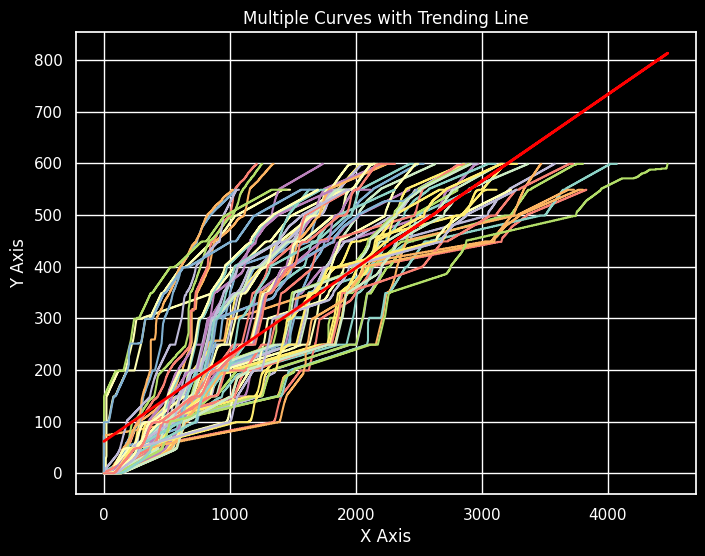

In [ ]:
grouped_data = dtw_paths.groupby('id').mean()

plt.figure(figsize=(8, 6))

for id_val, group in dtw_paths.groupby('id'):
    plt.plot(group[0], group[1], label=f'Curve {id_val}')

x = np.array(dtw_paths[0])
y = np.array(dtw_paths[1])
coefficients = np.polyfit(x, y, deg=1)
regression_line = np.polyval(coefficients, x)
plt.plot(x, regression_line, color='red', linewidth=2, label='Regression Line')

plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Multiple Curves with Trending Line')

plt.show()


Text(0.5, 1.0, 'DTW for A_JUNO_142_DELV_06')

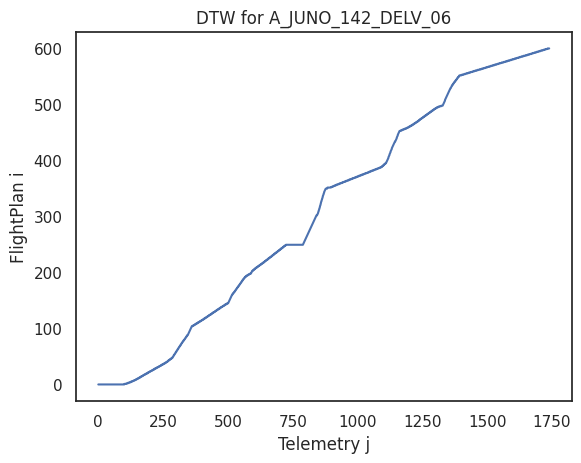

In [ ]:
name='A_JUNO_142_DELV_06'
sns.set(style='white')

dt=computeMaxErrorPlots(name)
plt.plot(dt[0],dt[1])
plt.xlabel('Telemetry j')
plt.ylabel('FlightPlan i')
plt.title('DTW for ' + name)


In [ ]:
computeMaxErrorPlots('A_JUNO_142_DELV_06')

0    1
0        0    0
1        1    0
2        2    0
3        3    0
4        4    0
...    ...  ...
1756  1735  599
1757  1736  599
1758  1737  599
1759  1738  599
1760  1739  599

[1761 rows x 2 columns]

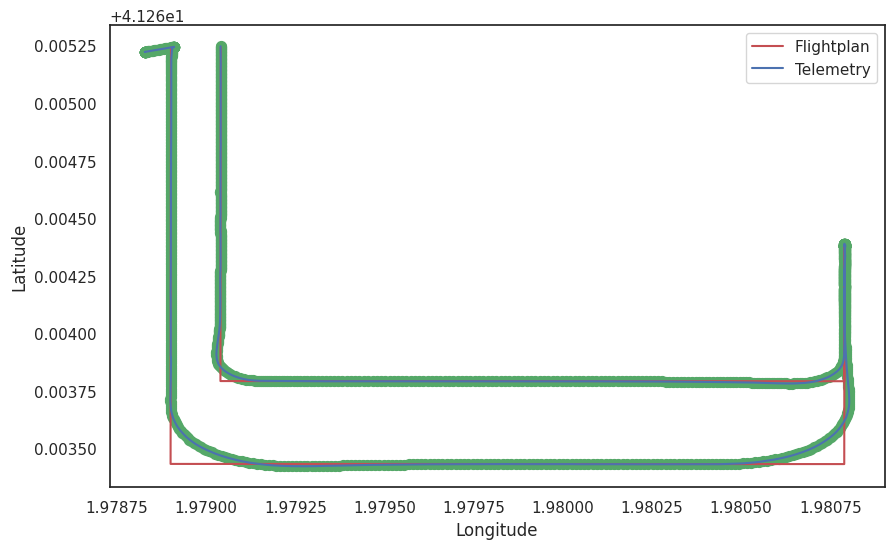

Warping Path Length: 1740
Alignment Accuracy: 0.0


In [ ]:
name='A_JUNO_142_DELV_06'
flightlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

s_x = np.array(flightplan[['FPLlat', 'FPLlon', 'FPLalt']])
s_y = np.array(telemetry[['lat', 'lon', 'alt']])

path, _ = metrics.dtw_path(s_x, s_y)

#
x_flightplan = s_x[:, 1]  # FPLlon
y_flightplan = s_x[:, 0]  # FPLlat
x_telemetry = s_y[:, 1]  # lon
y_telemetry = s_y[:, 0]  # lat

plt.figure(figsize=(10, 6))
plt.plot(x_flightplan, y_flightplan, 'r', label='Flightplan')
plt.plot(x_telemetry, y_telemetry, 'b', label='Telemetry')

for i, j in path:
    plt.scatter(x_telemetry[j], y_telemetry[j], c='g', s=50, marker='o')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()

warping_path_length = len(path)
aligned_pairs = sum((s_x[i] == s_y[j]).all() for i, j in path)
alignment_accuracy = aligned_pairs / warping_path_length

print("Warping Path Length:", warping_path_length)
print("Alignment Accuracy:", alignment_accuracy)


In [ ]:
planFixENU('A_JUNO_142_DELV_06')

Unnamed: 0      WPname           x           y          z  FPLvel  \
0            0   Waypoint1    0.000000    0.000000   0.000000     7.0   
1            1   Waypoint2   -0.062337 -130.929782   9.998653    10.0   
2            2   Waypoint3   -0.095624 -200.844605   9.996830    10.0   
3            3   Waypoint4  158.207656 -200.919397   9.994869    10.0   
4            4   Waypoint5  158.240949 -131.004574   9.996691     3.0   
5            5   Waypoint6  158.257279  -95.670870 -10.002680     0.0   
6            6    Hover10s  158.257279  -95.670870 -10.002680     2.0   
7            7   Waypoint7  158.257527  -95.671020  -0.002680     2.0   
8            8   Waypoint8  158.241692 -131.005192  39.996691    10.0   
9            9   Waypoint9  158.227424 -160.968830  39.996004    10.0   
10          10  Waypoint10   11.620728 -160.899564  39.997955    10.0   
11          11  Waypoint11   11.634994 -130.935926  39.998642     4.0   
12          12  Waypoint12   11.697261    0.017779  -5.000011     0.0   

    FPLturn           FPLwpt    timeSeg        time  
0      65.0  CurvaturePassed   0.000000    0.000000  
1      34.0  CurvaturePassed  18.758718   18.758718  
2      34.0  CurvaturePassed   6.991483   25.750201  
3      34.0  CurvaturePassed  15.830330   41.580530  
4      17.0  CurvaturePassed   6.991483   48.572013  
5       0.2         LineStop  13.533685   62.105699  
6       0.2         LineStop  10.000000   72.105699  
7       0.2  CurvaturePassed   5.000000   77.105699  
8      14.0  CurvaturePassed  26.685453  103.791152  
9      14.0  CurvaturePassed   2.996364  106.787516  
10     14.0  CurvaturePassed  14.660671  121.448187  
11     14.0  CurvaturePassed   2.996364  124.444551  
12     65.0  CurvaturePassed  34.617333  159.061884

Hover in 7th point (same as waypoint 6) (158.257279	-95.670870	-10.002680)

syncplan (total of 600 points (12 segments*50))

segment 0: from 0 to 50

segment 1: from 50 to 100

segment 6 waypoint -> 250-300

t_hover = t_tel(when fp(302) minus when fp(248))

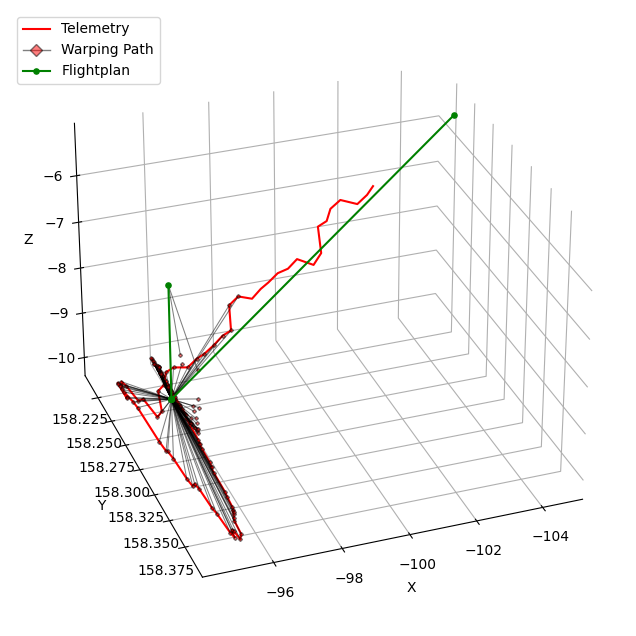

In [ ]:
name='A_JUNO_142_DELV_06'

flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
flightplan = pd.concat(
    [
        pd.DataFrame(
            scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                      axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 5)), columns=["FPLlat", "FPLlon", "FPLalt"] )
        for (_, original), (_, shift) in zip(flightplan.iloc[:-1].iterrows(), flightplan.iloc[1:].iterrows())
    ]
).reset_index(drop=True)
telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

lat0=flightplan['FPLlat'][0]
lon0=flightplan['FPLlon'][0]
h0=flightplan['FPLalt'][0]

for index, row in flightplan.iterrows():
  flightplan.at[index,'FPLlat'],flightplan.at[index,'FPLlon'],flightplan.at[index,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

for index, row in telemetry.iterrows():
  telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)



s_x = np.array(flightplan[['FPLlat', 'FPLlon', 'FPLalt']])
s_y = np.array(telemetry[['lat', 'lon', 'alt']])


path, _ = metrics.dtw_path(s_x, s_y)


x_flightplan = s_x[:, 1]  # FPLlon
y_flightplan = s_x[:, 0]  # FPLlat
z_flightplan = s_x[:, 2]  # FPLalt
x_telemetry = s_y[:, 1]  # lon
y_telemetry = s_y[:, 0]  # lat
z_telemetry = s_y[:, 2]  # alt
#sns.set(style='white')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# Plot telemetry
ax.plot(x_telemetry[700:830], y_telemetry[700:830], z_telemetry[700:830], 'r', label='Telemetry')

# Plot warping path lines
ax.plot([], [], [], '-kD', mfc='red', mec='k', linewidth=1, alpha=0.5, label='Warping Path')
for i, j in path[715:850]:
    ax.plot([x_telemetry[j], x_flightplan[i]], [y_telemetry[j], y_flightplan[i]], [z_telemetry[j], z_flightplan[i]],
            '-kD', mfc='red', mec='k', linewidth=0.75, markersize=2, alpha=0.5)
# Plot flight plan
ax.plot(x_flightplan[23:32], y_flightplan[23:32], z_flightplan[23:32], 'g',marker=".", markersize=7.5, label='Flightplan')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='upper left')

## zoom out to avoid cutting off the axis or plot
ax.set_box_aspect(aspect=None, zoom=1)

## plot legend and adapt view angle
ax.view_init(elev=30, azim=70)
'''
ax.set_xlim3d(1.97889011-0.00001, 1.9789002+0.0001)
ax.set_ylim3d(41.26343332-0.00015, 41.26343332+0.00031)
ax.set_zlim3d(0, 100)
'''
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Show the 3D plot
plt.show()


In [ ]:
syncPlan('A_JUNO_142_DELV_06')

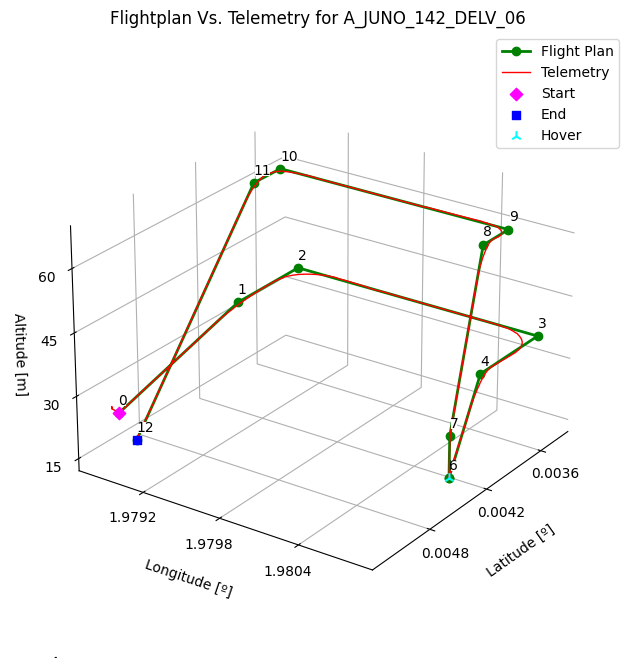

In [ ]:
plot_planVsTele('A_JUNO_142_DELV_06')

In [ ]:
def syncPlan(name):
  ### synchronize the flightplan and telemetry.
  ### for each index of the telemetry we get the synced index of an expanded flightplan
  ### not necessarily the closest index (dtw relation)

  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")

  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 50)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],_=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],_=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  return dtw_output[0]

In [ ]:
def computeMaxError(name):
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")


  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 50)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)
  #a=df_flightPlan.iloc[:-1].iterrows()
  #print(list(a)[0])

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],_=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],_=geodetic2ecef(row['lat'],row['lon'],row['alt'])



  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  df_pairs = pd.DataFrame(dtw_output[0])

  df_pairs['dist']=np.diag(scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          ))
  #df_pairs_threshold=(df_pairs[(df_pairs[['dist']]>3).all(axis=1)])

  e_max=df_pairs.iloc[int(len(df_pairs)*(10/100)):-int(len(df_pairs)*(10/100))]['dist'].nlargest(5).mean()
  return e_max

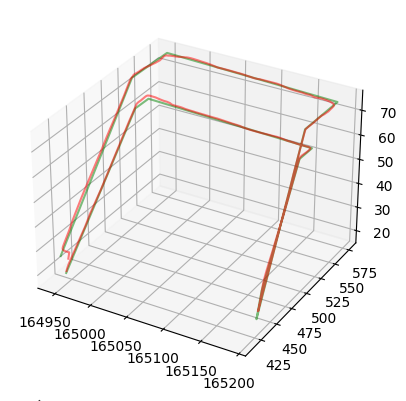

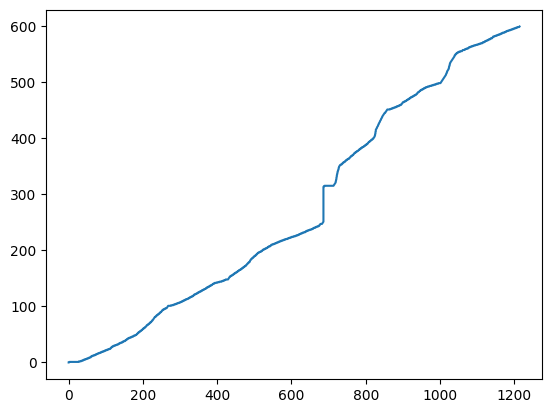

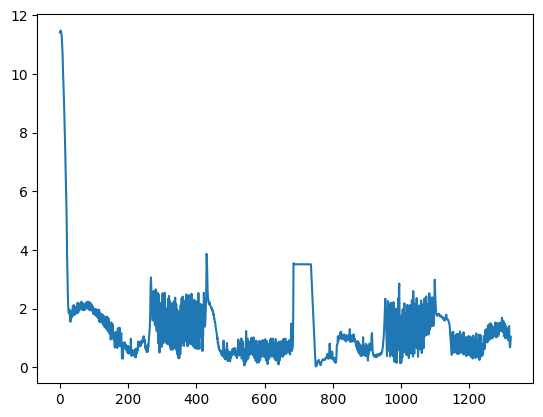

In [ ]:
computeMaxError('B_SWORD_1582_DELV_09')
computeMaxErrorPlots('B_SWORD_1582_DELV_09')

In [ ]:
PlanVsTele3D('B_UTAH_1514_DELV_01')

NameError: ignored

#Compute Error 0

In [ ]:
for (hi, left), (_, right) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows()):
  print(hi)
  print(left[('FPLlat')])
print(list(zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows()))[0])
print(list(zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows()))[0][0])
print((list(zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows()))[0][0][1][2])) # latitude [2]


f=scipy.interpolate.interp1d([0, 1],[[1, 1, 1],[2, 2, 2]], axis=0, bounds_error=False,fill_value=[0, 0, 0])
#f2=scipy.interpolate.interp1d([0, 1],[[10, 10, 10],[0, 7, 30]], axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0,1,11))
f2
x=np.arange(0,1,0.1)
y=f(x)

xnew = np.arange(0,1, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

#ser = pd.Series(['hi',1,2])

0    hi
1     1
2     2
dtype: object

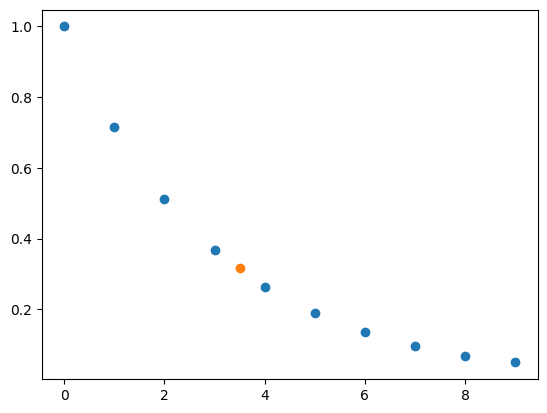

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

xnew = 3.5
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, 'o')
plt.show()

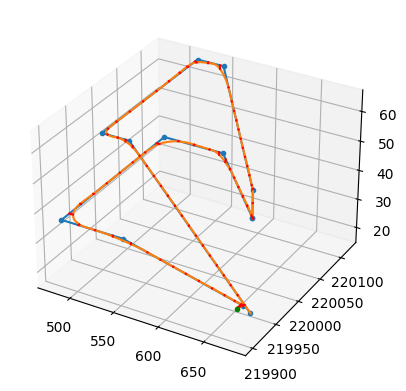

In [ ]:
import pandas as pd
intended_df = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")
intended_df = intended_df.drop(columns=intended_df.columns[0])
real_df = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
real_df = real_df.drop(columns=real_df.columns[0])
# I'll just trust ry that this is a valid approximation, lol:
real_df[["lat", "lon"]] = real_df[["lat", "lon"]] / 0.0000089987192
intended_df[["FPLlat", "FPLlon"]] = intended_df[["FPLlat", "FPLlon"]] / 0.0000089987192

#
intended_trajectory = intended_df[["FPLlat", "FPLlon", "FPLalt"]].values
intended_trajectory

#
real_trajectory = real_df[["lat", "lon", "alt"]].values
real_trajectory

# ### Plot for real 3d trajectory


closest_pts, closest_dists, closest_segment_ind = find_closest_lines(intended_trajectory, real_trajectory)


# %timeit find_closest_lines(intended_trajectory, real_trajectory)

fig = plt.figure("closest distances 3d", clear=True)
ax = fig.add_subplot(projection="3d")
plt.plot(intended_trajectory[:, 0], intended_trajectory[:, 1], intended_trajectory[:, 2], "-o", ms=3)
plt.plot(real_trajectory[:, 0], real_trajectory[:, 1], real_trajectory[:, 2], "-")
#only draw lines once every few points because there's kind of a lot of points
for a, b in itertools.islice(zip(real_trajectory, closest_pts), None, None, 20):
    plt.plot(*np.vstack([a, b]).T, "r-")
plt.plot(*real_trajectory[0, :], "go", ms=3)  # starting marker
plt.show()



# extra

In [ ]:
import pandas as pd
import numpy as np
#!pip install -U dtw
#pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip

import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
from tslearn.metrics import dtw_path

from dtw import dtw


In [ ]:
telemetry_df =pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
flight_plan_df = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")

telemetry_df = telemetry_df.rename(columns={'lat': 'latitude','lon' : 'longitude', 'alt' : 'altitude'})
telemetry_df = telemetry_df.drop(['Unnamed: 0'], axis=1)

flight_plan_df = flight_plan_df.rename(columns={'FPLlat': 'latitude','FPLlon' : 'longitude', 'FPLalt' : 'altitude'})
flight_plan_df = flight_plan_df.drop(['WPname', 'FPLvel','FPLturn','FPLwpt','Unnamed: 0'], axis=1)
#########################################

longitude = telemetry_df['longitude']
latitude = telemetry_df['latitude']
altitude = telemetry_df['altitude']
time = telemetry_df['secs']

trace = go.Scatter3d(
    x=longitude,
    y=latitude,
    z=altitude,
    mode='markers',
    marker=dict(
        size=3,
        color=time,
        colorscale='Viridis',
        opacity=0.8
    ),
    name='Telemetry Data'
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Longitude'),
        yaxis=dict(title='Latitude'),
        zaxis=dict(title='Altitude')
    )
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
df = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
df = df.rename(columns={'lat': 'latitude','lon' : 'longitude', 'alt' : 'altitude', 'secs' : 'time'})
df = df.drop(['Unnamed: 0'], axis=1)
speeds = np.sqrt(df['latitude'].diff()**2 + df['longitude'].diff()**2 + df['altitude'].diff()**2) / (df['time'].diff())


trace = go.Scatter3d(
    x=df['longitude'],
    y=df['latitude'],
    z=df['altitude'],
    mode='markers',
    marker=dict(
        size=3,
        color=speeds,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title='Telemetry 3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='Longitude'),
        yaxis=dict(title='Latitude'),
        zaxis=dict(title='Altitude')
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

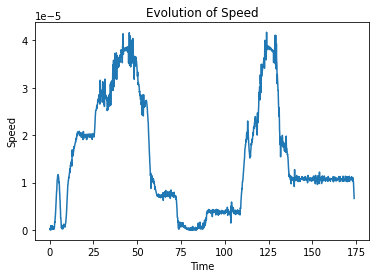

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

telemetry_df = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
telemetry_df = telemetry_df.rename(columns={'lat': 'latitude','lon' : 'longitude', 'alt' : 'altitude', 'secs' : 'time'})
telemetry_df = telemetry_df.drop(['Unnamed: 0'], axis=1)

# calculate speed
telemetry_df['speed'] = np.sqrt((telemetry_df['latitude'].diff()**2 + telemetry_df['longitude'].diff()**2) / telemetry_df['time'].diff())

# plot speed as a function of time
plt.plot(telemetry_df['time'], telemetry_df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Evolution of Speed')
plt.show()


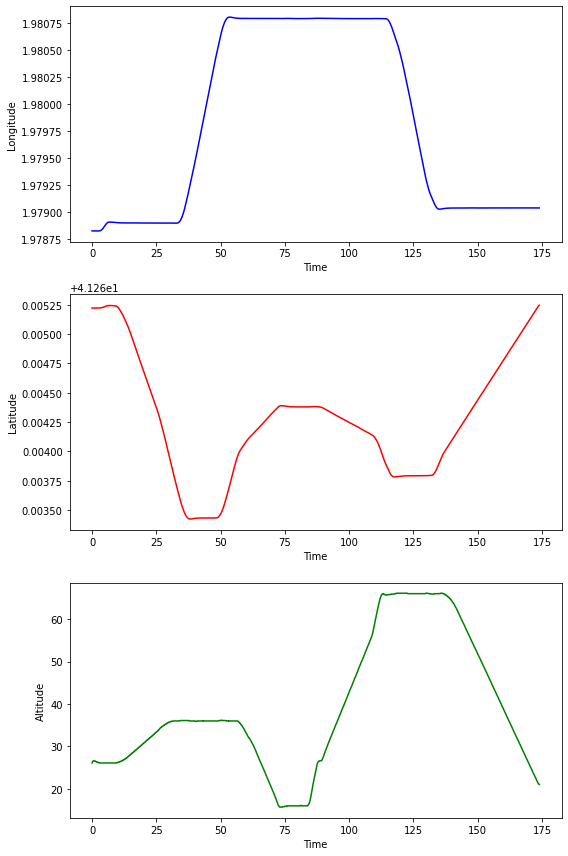

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
df = df.rename(columns={'lat': 'latitude','lon' : 'longitude', 'alt' : 'altitude', 'secs' : 'time'})
df = df.drop(['Unnamed: 0'], axis=1)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

ax1.plot(df['time'], df['longitude'], color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Longitude')

# subplot 2: latitude versus time
ax2.plot(df['time'], df['latitude'], color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Latitude')

# subplot 3: altitude versus time
ax3.plot(df['time'], df['altitude'], color='green')
ax3.set_xlabel('Time')
ax3.set_ylabel('Altitude')

plt.tight_layout()
plt.show()

# New model

In [ ]:
'''
def planModel(name):
  ### Create a dataframe with a flightPlan segment per row.
  ### Origin of segment: (x0,y0,z0). End: (x1,y1,z1)
  ### See where telemetry is at the theoretical time of the end of each segment (x2,y2,z2)

  ## read files
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + '.csv')

  ## get the type of segment from the flightPlan and the number associated to the drone model
  segmentType = definePlanSegment(flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x0, y0, z0
  for index, row in flightPlan.iterrows():
    flightPlan.at[index,'FPLlat'],flightPlan.at[index,'FPLlon'],flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])
  flightPlan = flightPlan.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## compute the time by dividing the absolute distance by the velocity
  for (i, original), (i, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    if  (original['FPLvel']) > 0:
      dist=math.sqrt((shift['x0']-original['x0'])**2+(shift['y0']-original['y0'])**2+(shift['z0']-original['z0'])**2)
      flightPlan.at[i, 'timeSeg']=dist/(original['FPLvel'])
    else:
      flightPlan.at[i, 'timeSeg']=time = int(flightPlan.at[i,'WPname'].replace('Hover', '').replace('s',''))

  flightPlan['timeSeg'].fillna(0, inplace=True)
  flightPlan['time']=(flightPlan['timeSeg'].cumsum(axis = 0)) # global time

  ## set the origin at the original point as (0,0,0) by substracting its value to the columns
  x0 = flightPlan['x0'][0]
  y0 = flightPlan['y0'][0]
  z0 = flightPlan['z0'][0]
  flightPlan['x0'] = flightPlan['x0'] - x0
  flightPlan['y0'] = flightPlan['y0'] - y0
  flightPlan['z0'] = flightPlan['z0'] - z0

  ## convert and replace the lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])
  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - x0
  telemetry['y2'] = telemetry['y2'] - y0
  telemetry['z2'] = telemetry['z2'] - z0

  ## shift columns to set the end of the segment as the origin point of the next one
  for (i, original), (j, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
    flightPlan.at[i,'x1'] = shift['x0']
    flightPlan.at[i,'y1'] = shift['y0']
    flightPlan.at[i,'z1'] = shift['z0']
    #flightPlan.at[i,'x3'] = shift['x2']
    #flightPlan.at[i,'y3'] = shift['y2']
    #flightPlan.at[i,'z3'] = shift['z2']
    flightPlan.at[i,'timeSeg'] = shift['timeSeg']
    flightPlan.at[i,'time'] = shift['time']

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in flightPlan.iterrows():
    time_tel = (find_nearest(telemetry['secs'], flightPlan.at[index,'time']))
    flightPlan.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    flightPlan.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    flightPlan.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])

  #flightPlan = flightPlan[['x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'timeSeg', 'x2','y2','z2', 'x3', 'y3','z3','time']][:-1]

  ## keep only the necessary columns and add a new one being the number of the segment in the trajectory (segID)
  flightPlan = flightPlan[['x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'timeSeg', 'x2','y2','z2','time','FPLturn']][:-1]
  flightPlan['type']=segmentType
  flightPlan['dronemodel']=droneModel

  flightPlan.insert(0, 'segID', range(0, len(flightPlan)))

  ## differentiate kind of drones
  ## 1: JUNO,
  ### Calculate Errors

  ## u = [ux, uy]. Vector connecting origin and end of the segment
  ## v = [vx, vy]. Vector connecting the origin of the segment and the aircraft
  ## Errors defined by Implementation and Metrics for a Trajectory Prediction Validation Methodology
  ## by Mike M. Paglione and Robert D. Oaks, AIAA Guidance, Navigation and Control Conference and Exhibit 2007
  for index, row in flightPlan.iterrows():
    u = [flightPlan.at[index,'x2'] - flightPlan.at[index,'x0'], flightPlan.at[index,'y2'] - flightPlan.at[index,'y0']]
    v = [flightPlan.at[index,'x1'] - flightPlan.at[index,'x0'], flightPlan.at[index,'y1'] - flightPlan.at[index,'y0']]
    if v[0] != 0:
      flightPlan.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      flightPlan.loc[index, 'e_along'] = (u[0]*v[0]+u[1]*v[1])/(math.sqrt(v[0]**2+v[1]**2))
      flightPlan.loc[index, 'e_cross'] = (u[0]*v[1]-u[1]*v[0])/(math.sqrt(v[0]**2+v[1]**2))
    else:
      flightPlan.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      flightPlan.loc[index, 'e_along'] = 0
      flightPlan.loc[index, 'e_cross'] = 0

  ## drop unnecessary columns
  #flightPlan = flightPlan.drop(columns=['x2', 'y2','z2','time'])
  return flightPlan
'''

In [ ]:
''' copy of extendedplan
def extendedPlan(name, n):

  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")

  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
  xo = df_flightPlan['FPLlat'][0]
  yo = df_flightPlan['FPLlon'][0]
  zo = df_flightPlan['FPLalt'][0]
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  ## interpolate by adding n points to each segment
  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, n,endpoint=False)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())

      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-1].iterrows(), df_flightPlanExpanded.iloc[1:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']

  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]

  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()

  ## interpolation for the timeSeg (non continuous function -> interpolate every segment alone)
  ## we get the NaN values and fill then with consideration of its position and the next non-NaN value (nextVal)
  ## we reset the nextVal every n times (every segment)
  ## segment (0,4), if n=3 -> (0, _, _, _, 4), nextVal=4 and Value0=4/2*1 = 2
  k=1
  for i,row in df_flightPlanExpanded[df_flightPlanExpanded['timeSeg'].isna()].iterrows():
    nextid=df_flightPlanExpanded[i:]['timeSeg'].first_valid_index()
    nextval=df_flightPlanExpanded.loc[nextid,'timeSeg']
    df_flightPlanExpanded.loc[i, "timeSeg"]=(nextval/n)*k
    k=k+1
    if k==n:
      k=1

  ## rename the columns
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','segId','type','x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'FPLvel','FPLturn','time','timeSeg']]


  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_tel = (find_nearest(telemetry['secs'], df_flightPlanExpanded.at[index,'time']))
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])

  ## manually add the last ending point of the last segment as it is not considered in the previous loop
  df_flightPlanExpanded['x1'].iloc[-1]=df_flightPlan['FPLlat'].iloc[-1]
  df_flightPlanExpanded['y1'].iloc[-1]=df_flightPlan['FPLlon'].iloc[-1]
  df_flightPlanExpanded['z1'].iloc[-1]=df_flightPlan['FPLalt'].iloc[-1]

  # x
  last_time_tel= (find_nearest(telemetry['secs'], df_flightPlanExpanded['time'].iloc[-1]))
  x2f,y2f,z2f=(telemetry.loc[telemetry['secs'] == last_time_tel].iloc[0])[['x2','y2','z2']]
  df_flightPlanExpanded['x2'].iloc[-1]=x2f
  df_flightPlanExpanded['y2'].iloc[-1]=y2f
  df_flightPlanExpanded['z2'].iloc[-1]=z2f
  # x

  ## u = [ux, uy]. Vector connecting origin and end of the segment
  ## v = [vx, vy]. Vector connecting the origin of the segment and the aircraft
  ## Errors defined by Implementation and Metrics for a Trajectory Prediction Validation Methodology
  ## by Mike M. Paglione and Robert D. Oaks, AIAA Guidance, Navigation and Control Conference and Exhibit 2007
  for index, row in df_flightPlanExpanded.iterrows():
    u = [df_flightPlanExpanded.at[index,'x2'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y2'] - df_flightPlanExpanded.at[index,'y0']]
    v = [df_flightPlanExpanded.at[index,'x1'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y1'] - df_flightPlanExpanded.at[index,'y0']]
    if v[0] != 0:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = (u[0]*v[0]+u[1]*v[1])/(math.sqrt(v[0]**2+v[1]**2))
      df_flightPlanExpanded.loc[index, 'e_cross'] = (u[0]*v[1]-u[1]*v[0])/(math.sqrt(v[0]**2+v[1]**2))
    else:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = 0
      df_flightPlanExpanded.loc[index, 'e_cross'] = 0

  return df_flightPlanExpanded
'''

In [ ]:
def extendedPlan(name, n):

  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")

  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
  xo = df_flightPlan['FPLlat'][0]
  yo = df_flightPlan['FPLlon'][0]
  zo = df_flightPlan['FPLalt'][0]
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']

  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]

  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]


  ## rename the columns
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','segId','type','x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'FPLvel','FPLturn','time']]


  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_tel = (find_nearest(telemetry['secs'], df_flightPlanExpanded.at[index,'time']))
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])


  ## u = [ux, uy]. Vector connecting origin and end of the segment
  ## v = [vx, vy]. Vector connecting the origin of the segment and the aircraft
  ## Errors defined by Implementation and Metrics for a Trajectory Prediction Validation Methodology
  ## by Mike M. Paglione and Robert D. Oaks, AIAA Guidance, Navigation and Control Conference and Exhibit 2007
  for index, row in df_flightPlanExpanded.iterrows():
    u = [df_flightPlanExpanded.at[index,'x2'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y2'] - df_flightPlanExpanded.at[index,'y0']]
    v = [df_flightPlanExpanded.at[index,'x1'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y1'] - df_flightPlanExpanded.at[index,'y0']]
    if v[0] != 0:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = (u[0]*v[0]+u[1]*v[1])/(math.sqrt(v[0]**2+v[1]**2))
      df_flightPlanExpanded.loc[index, 'e_cross'] = (u[0]*v[1]-u[1]*v[0])/(math.sqrt(v[0]**2+v[1]**2))
    else:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = 0
      df_flightPlanExpanded.loc[index, 'e_cross'] = 0

  ## drop unnecessary columns
  #df_flightPlanExpanded = df_flightPlanExpanded.drop(columns=['x2', 'y2','z2'])

  return df_flightPlanExpanded

In [ ]:
df=extendedPlan('A_JUNO_142_DELV_06',2)

df

NameError: ignored

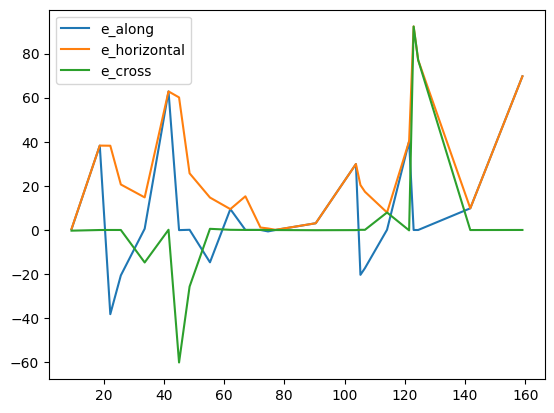

In [ ]:
plt.plot(df['time'],df['e_along'], label='e_along')
plt.plot(df['time'],df['e_horizontal'],label='e_horizontal')
plt.plot(df['time'],df['e_cross'], label='e_cross')
plt.legend()

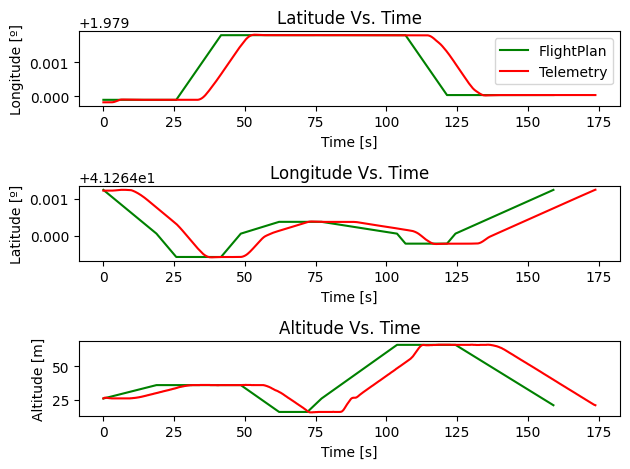

In [ ]:
subplotPlanVsTele('A_JUNO_142_DELV_06')

In [ ]:
PlanVsTele3D('A_JUNO_142_DELV_06')

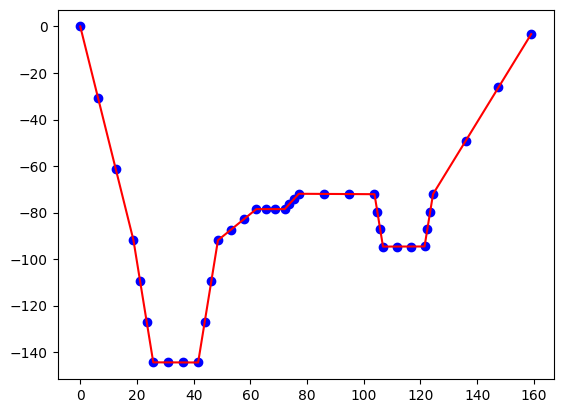

In [ ]:
plt.plot(df['time'],df['z1'], 'bo')
plt.plot(0,df['z0'][0], 'bo')

pf=planFix('A_JUNO_142_DELV_06')
plt.plot(pf['time'],pf['z'], 'red')

# all segments at 0 ,0 ,0

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def extendedPlan(name, n):
  #name='B_UTAH_529_DELV_02'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
  xo = df_flightPlan['FPLlat'][0]
  yo = df_flightPlan['FPLlon'][0]
  zo = df_flightPlan['FPLalt'][0]
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_tel = round(row['time'],1)
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == find_nearest(telemetry['secs'].values,time_tel), 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == find_nearest(telemetry['secs'].values,time_tel), 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == find_nearest(telemetry['secs'].values,time_tel), 'z2'].iloc[0])

  for index, row in df_flightPlanExpanded.iterrows():
    #respoint = residingPoint([df_flightPlanExpanded.at[index, 'x0'],df_flightPlanExpanded.at[index, 'y0'],df_flightPlanExpanded.at[index, 'z0']],[df_flightPlanExpanded.at[index, 'x1'],df_flightPlanExpanded.at[index, 'y1'],df_flightPlanExpanded.at[index, 'z1']],[df_flightPlanExpanded.at[index, 'x2'],df_flightPlanExpanded.at[index, 'y2'],df_flightPlanExpanded.at[index, 'z2']])
    #respoint = residingPoint([row['x0'],row['y0'],row['z0']],[row['x1'],row['y1'],row['z1']],[row['x2'],row['y2'],row['z2']])

    #df_flightPlanExpanded.at[index, 'x3'] = respoint[0]
    #df_flightPlanExpanded.at[index, 'y3'] = respoint[1]
    #df_flightPlanExpanded.at[index, 'z3'] = respoint[2]

    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)
  ## u = [ux, uy]. Vector connecting origin and end of the segment
  ## v = [vx, vy]. Vector connecting the origin of the segment and the aircraft
  ## Errors defined by Implementation and Metrics for a Trajectory Prediction Validation Methodology
  ## by Mike M. Paglione and Robert D. Oaks, AIAA Guidance, Navigation and Control Conference and Exhibit 2007
  for index, row in df_flightPlanExpanded.iterrows():
    u = [df_flightPlanExpanded.at[index,'x2'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y2'] - df_flightPlanExpanded.at[index,'y0']]
    v = [df_flightPlanExpanded.at[index,'x1'] - df_flightPlanExpanded.at[index,'x0'], df_flightPlanExpanded.at[index,'y1'] - df_flightPlanExpanded.at[index,'y0']]
    if v[0] != 0:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = (u[0]*v[0]+u[1]*v[1])/(math.sqrt(v[0]**2+v[1]**2))
      df_flightPlanExpanded.loc[index, 'e_cross'] = (u[0]*v[1]-u[1]*v[0])/(math.sqrt(v[0]**2+v[1]**2))
    else:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = 0
      df_flightPlanExpanded.loc[index, 'e_cross'] = 0

  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  # substract the starting point of the segment to the end point of the segment so it matches the new origin (x0=y0=z0=0)
  # z0 is left as the inital altitude of the segment
  '''
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0'] - original['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0'] - original ['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0'] - original ['z0']

    df_flightPlanExpanded.at[i,'x0'] = original['x0'] - original['x0']
    df_flightPlanExpanded.at[i,'y0'] = original['y0'] - original ['y0']
  '''
  ## drop unnecessary columns
  #df_flightPlanExpanded = df_flightPlanExpanded.drop(columns=['x0','y0','segId','type','closest'])
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  #df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel', 'climb', 'cruise','hover','descent', 'z0', 'x1', 'y1', 'z1','x2', 'y2','z2', 'x3','y3','z3' ,'FPLvel','FPLturn','timeSeg','e_horizontal','e_along','e_cross']]
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','climb','cruise','hover','descent','x0','y0','z0', 'x1', 'y1', 'z1','FPLvel','FPLturn','time','e_horizontal','e_along','e_cross']]
  return df_flightPlanExpanded

In [ ]:
#df=extendedPlan('B_OMAHA_643_DELV_06',1)
df=extendedPlan('B_UTAH_529_DELV_02',1)

#A_JUNO_142_DELV_06
df
#  df['time']=np.diff(df['time'], prepend=0)
# pf=planFix('B_OMAHA_643_DELV_06')

dronemodel  climb  cruise  hover  descent      delay          x0  \
0            1    0.0     1.0    0.0      0.0   0.000000         0.0   
1            1    0.0     1.0    0.0      0.0   1.543414   84.888381   
2            1    0.0     1.0    0.0      0.0   9.835054   91.836243   
3            1    0.0     0.0    1.0      0.0  13.039926   78.669257   
4            1    0.0     0.0    0.0      1.0  14.176547    45.97531   
5            1    1.0     0.0    0.0      0.0   9.276547    45.97531   
6            1    1.0     0.0    0.0      0.0  12.376547   53.487499   
7            1    0.0     1.0    0.0      0.0   0.814329    116.2304   
8            1    0.0     1.0    0.0      0.0   0.433693  168.898475   
9            1    0.0     1.0    0.0      0.0   7.530549  161.539681   
10           1    0.0     0.0    1.0      0.0   5.949913  108.871607   

            y0          z0          x1          y1          z1  FPLvel  \
0          0.0         0.0   84.888381    2.871620  -96.802687     5.0   
1      2.87162  -96.802687   91.836243 -199.092481  -96.702522    10.0   
2  -199.092481  -96.702522   78.669257 -199.537899  -81.687256     5.0   
3  -199.537899  -81.687256   45.975310 -200.651299  -59.566290     3.0   
4  -200.651299   -59.56629   45.975310 -200.651299  -59.566290     0.0   
5  -200.651299   -59.56629   53.487499 -200.389756  -52.970942     2.0   
6  -200.389756  -52.970942  116.230400 -198.230177  -48.710744     2.0   
7  -198.230177  -48.710744  168.898475 -196.448503 -108.772526     5.0   
8  -196.448503 -108.772526  161.539681   17.456369 -108.878744    10.0   
9    17.456369 -108.878744  108.871607   15.674705  -48.816962     5.0   
10   15.674705  -48.816962   -4.183947   11.807590   -3.284359     3.0   

    FPLturn        time  closest  e_horizontal     e_along   e_cross  
0      64.0   25.756586     27.3     84.406766   84.406754 -0.043506  
1      64.0   45.964946     55.8    174.886148  174.886144  0.035776  
2       9.0   49.960074     63.0      2.661565   -0.306553  2.643852  
3       9.0   63.123453     77.3      0.516900    0.515970  0.030997  
4       0.2   73.123453     82.4      0.081986    0.000000  0.000000  
5       0.2   78.123453     90.5      0.129894   -0.073150  0.107338  
6       0.2  109.585671    110.4     62.668023   62.668023  0.003512  
7      19.0  125.566307    126.0     52.420069   52.412931 -0.865032  
8      39.0  146.969451    154.5    197.097605  197.097602  0.035278  
9      39.0  162.950087    168.9     43.625567   43.624446 -0.312794  
10     39.0  203.597256    189.0    112.975530  112.975516  0.056103

In [ ]:
df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + ".csv")
for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])
fp=planFix('A_JUNO_142_DELV_06')

telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + 'A_JUNO_142_DELV_06' + ".csv")
for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

x=telemetry.iloc[290]['lat']-df_flightPlan.iloc[1]['FPLlat']
x
x0=telemetry.iloc[290]['lat']-df_flightPlan.iloc[0]['FPLlat']
x0

94.1676974510774

In [ ]:
plotPlanTele3D('B_OMAHA_643_DELV_06')

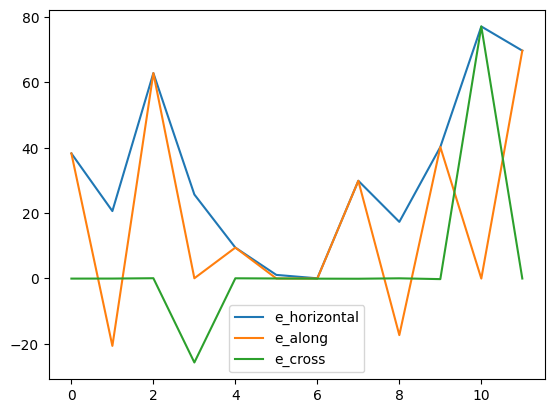

In [ ]:
plt.plot(df['e_horizontal'], label='e_horizontal')
plt.plot(df['e_along'], label='e_along')
plt.plot(df['e_cross'], label='e_cross')

plt.legend()

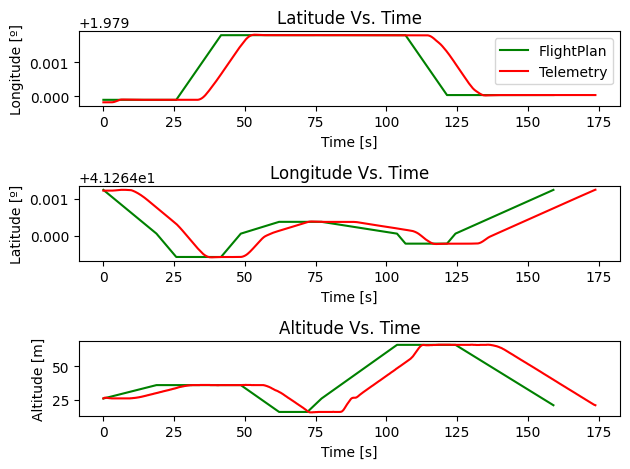

In [ ]:
subplotPlanVsTele('A_JUNO_142_DELV_06')

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last one, to try an unseen fligth
# fileName[-4:]
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)


In [ ]:
dataset = pd.DataFrame()
n=1
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  error = model.loc[model['e_horizontal']>=300]
  if len(error) == 0:
    dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

dronemodel  climb  cruise  hover  descent         x0       y0         z0  \
0           1    0.0     1.0    0.0      0.0        0.0      0.0        0.0   
1           1    0.0     1.0    0.0      0.0  84.888381  2.87162 -96.802687   

          x1          y1         z1  FPLvel  FPLturn       time  e_horizontal  \
0  84.888381    2.871620 -96.802687     5.0     64.0  25.756586     84.406766   
1  91.836243 -199.092481 -96.702522    10.0     64.0  45.964946    174.886148   

      e_along   e_cross  
0   84.406754 -0.043506  
1  174.886144  0.035776

In [ ]:
datasetcopy = dataset

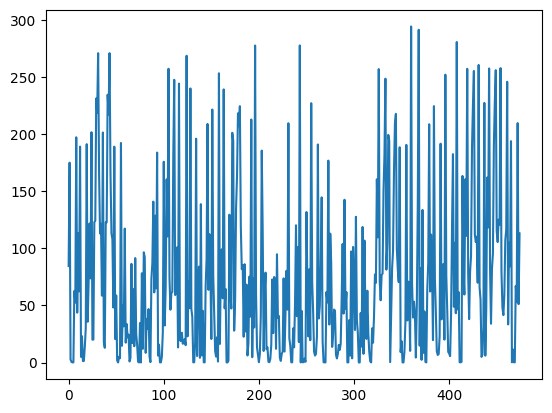

In [ ]:
plt.plot(dataset['e_horizontal'])

In [ ]:
#def testModel(datasetcopy)

y = datasetcopy[['e_horizontal','e_along','e_cross']]

X = datasetcopy.drop(y.columns, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

plt.plot(y_test['e_horizontal'].reset_index(drop=True))
plt.plot(y_rf_test_pred[:,0])
from sklearn.metrics import mean_squared_error, r2_score

#rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
#rf_train_r2 = r2_score(y_train, y_rf_train_pred)

#rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
#rf_test_r2 = r2_score(y_test, y_rf_test_pred)


#rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
#rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#rf_results

dronemodel  climb  cruise  hover  descent          x0          y0  \
0             1    0.0     1.0    0.0      0.0         0.0         0.0   
1             1    0.0     1.0    0.0      0.0   84.888381     2.87162   
2             1    0.0     1.0    0.0      0.0   91.836243 -199.092481   
3             1    0.0     0.0    1.0      0.0   78.669257 -199.537899   
4             1    0.0     0.0    0.0      1.0    45.97531 -200.651299   
..          ...    ...     ...    ...      ...         ...         ...   
470           1    1.0     0.0    0.0      0.0   53.487499 -200.389756   
471           1    0.0     1.0    0.0      0.0    116.2304 -198.230177   
472           1    0.0     1.0    0.0      0.0  168.898475 -196.448503   
473           1    0.0     1.0    0.0      0.0  161.539681   17.456369   
474           1    0.0     0.0    1.0      0.0  108.871607   15.674705   

             z0          x1          y1          z1  FPLvel  FPLturn  \
0           0.0   84.888381    2.871620  -96.802687     5.0     64.0   
1    -96.802687   91.836243 -199.092481  -96.702522    10.0     64.0   
2    -96.702522   78.669257 -199.537899  -81.687256     5.0      9.0   
3    -81.687256   45.975310 -200.651299  -59.566290     3.0      9.0   
4     -59.56629   45.975310 -200.651299  -59.566290     0.0      0.2   
..          ...         ...         ...         ...     ...      ...   
470  -52.970942  116.230400 -198.230177  -48.710744     2.0      0.2   
471  -48.710744  168.898475 -196.448503 -108.772526     5.0     19.0   
472 -108.772526  161.539681   17.456369 -108.878744    10.0     39.0   
473 -108.878744  108.871607   15.674705  -48.816962     5.0     39.0   
474  -48.816962   -4.183947   11.807590   -3.284359     3.0     39.0   

           time  
0     25.756586  
1     45.964946  
2     49.960074  
3     63.123453  
4     73.123453  
..          ...  
470  109.585671  
471  125.566307  
472  146.969451  
473  162.950087  
474  203.597256  

[475 rows x 14 columns]

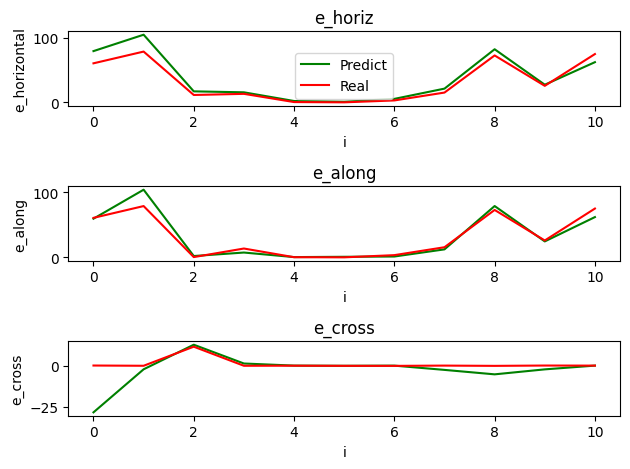

In [ ]:
# B_UTAH_1006_DELV_01, C_JUNO_1083_DELV_05, C_OMAHA_547_DELV_04, C_OMAHA_1092_DELV_03
# C_JUNO_1693_DELV_07, B_OMAHA_643_DELV_06
pm = extendedPlan('C_JUNO_1693_DELV_07',1)
#plt.plot(pm['time'],pm['e_cross'])
#plt.plot(pm['time'],pm['e_cross'], 'bo')

y_rf_flightplan= rf.predict(pm.drop(['e_along','e_cross','e_horizontal'], axis=1))

subplotModel(pm,y_rf_flightplan)

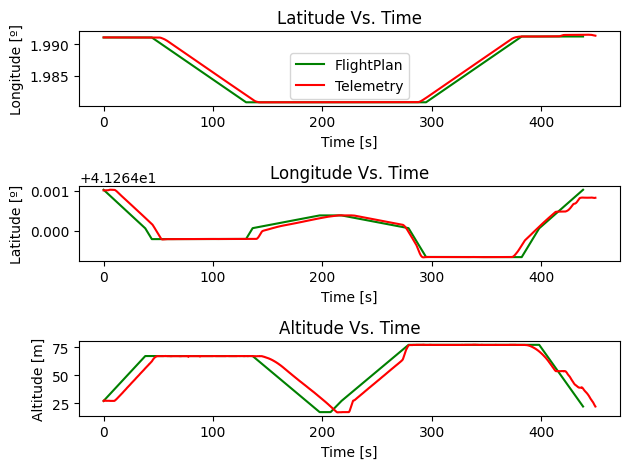

In [ ]:
subplotPlanVsTele('B_OMAHA_643_DELV_06')

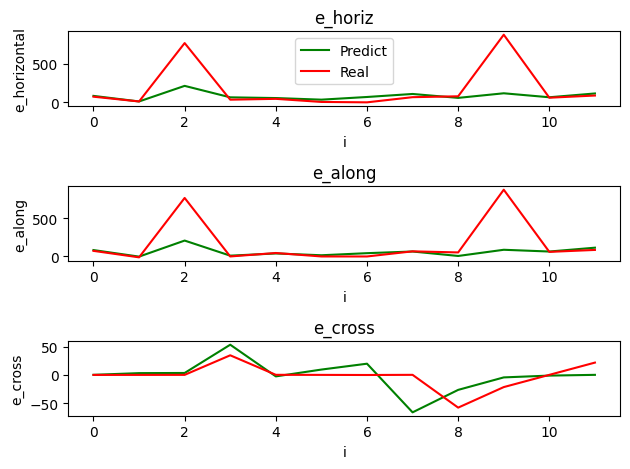

In [ ]:
pm = extendedPlan('B_OMAHA_643_DELV_06',1)

y_rf_flightplan= rf.predict(pm.drop(['e_along','e_cross','e_horizontal'], axis=1))

subplotModel(pm,y_rf_flightplan)

R2 e_horizontal train: 94.35%
R2 e_along train: 96.28999999999999%
R2 e_cross trai: 91.92%
R2 e_horizontal test: 56.47%
R2 e_along test: 72.72999999999999%
R2 e_cross test: 9.21%


Text(0.5, 0, 'Experimental LogS')

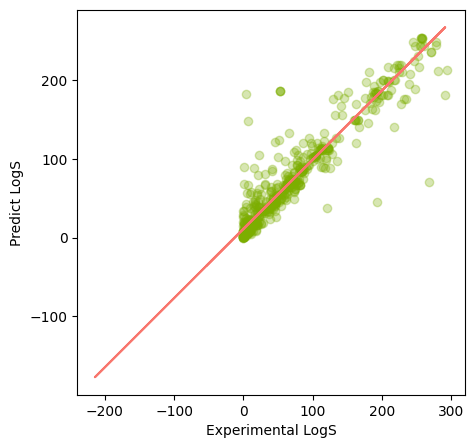

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train['e_horizontal'], y=y_rf_train_pred[:,0], c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test['e_horizontal'], y=y_rf_test_pred[:,0], c="#7CAE00" ,alpha=0.3)

#plt.plot(y_train['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_train_pred[:,2][:10])

#plt.plot(y_test['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_test_pred[:,2][:10])

print('R2 e_horizontal train: ' + str(round(r2_score(y_train['e_horizontal'].reset_index(drop=True), y_rf_train_pred[:,0]),4)*100)+'%')
print('R2 e_along train: ' + str(round(r2_score(y_train['e_along'].reset_index(drop=True), y_rf_train_pred[:,1]),4)*100)+'%')
print('R2 e_cross trai: ' + str(round(r2_score(y_train['e_cross'].reset_index(drop=True), y_rf_train_pred[:,2]),4)*100)+'%')

print('R2 e_horizontal test: ' + str(round(r2_score(y_test['e_horizontal'].reset_index(drop=True), y_rf_test_pred[:,0]),4)*100)+'%')
print('R2 e_along test: ' + str(round(r2_score(y_test['e_along'].reset_index(drop=True), y_rf_test_pred[:,1]),4)*100)+'%')
print('R2 e_cross test: ' + str(round(r2_score(y_test['e_cross'].reset_index(drop=True), y_rf_test_pred[:,2]),4)*100)+'%')

z = np.polyfit(y_train['e_horizontal'], y_rf_train_pred[:,0], 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')

Text(0.5, 0.98, 'e_horizontal (first 100 values) from TRAIN data')

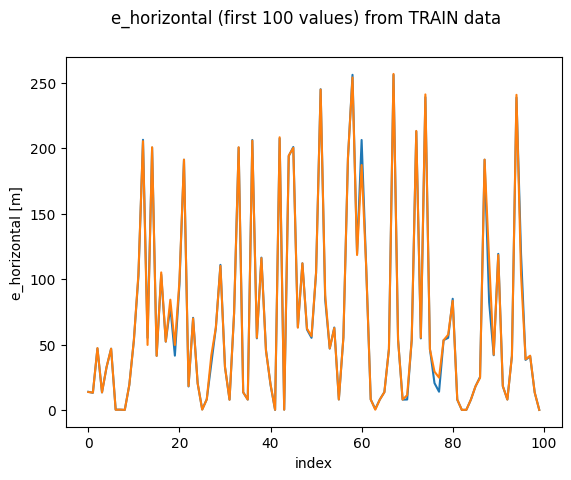

In [ ]:
plt.plot(y_train['e_horizontal'].reset_index(drop=True)[:100])
plt.plot(y_rf_train_pred[:,0][:100])
plt.xlabel('index')
plt.ylabel('e_horizontal [m]')
plt.suptitle('e_horizontal (first 100 values) from TRAIN data')

Text(0.5, 0.98, 'e_horizontal (first 100 values) from TEST data')

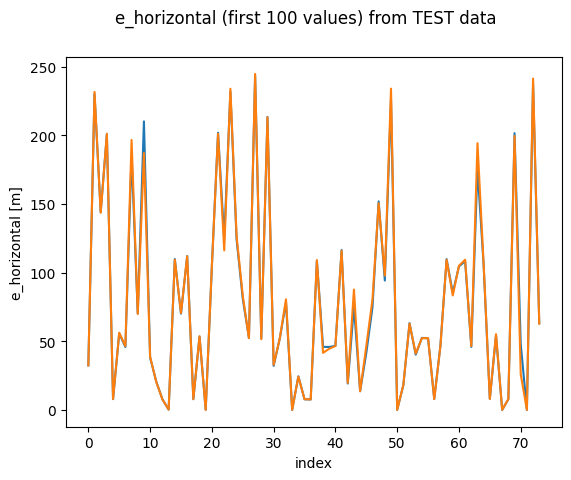

In [ ]:
plt.plot(y_test['e_horizontal'].reset_index(drop=True)[:100])
plt.plot(y_rf_test_pred[:,0][:100])
plt.xlabel('index')
plt.ylabel('e_horizontal [m]')
plt.suptitle('e_horizontal (first 100 values) from TEST data')

# dx, dy, dz predict (test)


In [ ]:
def extendedPlan(name, n):
  #name='A_JUNO_142_DELV_06'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  #for index, row in df_flightPlan.iterrows():
  #  df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
 # xo = df_flightPlan['FPLlat'][0]
 # yo = df_flightPlan['FPLlon'][0]
 # zo = df_flightPlan['FPLalt'][0]
  xo =0
  yo = 0
  zo = 0
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  #for index, row in telemetry.iterrows():
  #  telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_plan = row['time']
    time_tel = find_nearest(telemetry['secs'].values,row['time'])
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])
  for index, row in df_flightPlanExpanded.iterrows():
    #respoint = residingPoint([row['x0'],row['y0'],row['z0']],[row['x1'],row['y1'],row['z1']],[row['x2'],row['y2'],row['z2']])

    #df_flightPlanExpanded.at[index, 'x3'] = respoint[0]
    #df_flightPlanExpanded.at[index, 'y3'] = respoint[1]
    #df_flightPlanExpanded.at[index, 'z3'] = respoint[2]

    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']
    df_flightPlanExpanded.at[index, 'dx'], df_flightPlanExpanded.at[index, 'dy']= get_xy_difference(row['x2'], row['y2'], row['x1'], row['y1'])
    df_flightPlanExpanded.at[index, 'dz'] = row['z2'] - row['z1']

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)



  ## u = [ux, uy]. Vector connecting origin and end of the segment
  ## v = [vx, vy]. Vector connecting the origin of the segment and the aircraft
  ## Errors defined by Implementation and Metrics for a Trajectory Prediction Validation Methodology
  ## by Mike M. Paglione and Robert D. Oaks, AIAA Guidance, Navigation and Control Conference and Exhibit 2007
  '''
  for index, row in df_flightPlanExpanded.iterrows():
    u = [row['x2'] - row['x1'], row['y2'] - row['y1']]
    v = [row['x0'] - row['x1'], row['y0'] -row['y1']]
    if v[0] != 0:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = (u[0]*v[0]+u[1]*v[1])/(math.sqrt(v[0]**2+v[1]**2))
      df_flightPlanExpanded.loc[index, 'e_cross'] = (u[0]*v[1]-u[1]*v[0])/(math.sqrt(v[0]**2+v[1]**2))
    else:
      df_flightPlanExpanded.loc[index, 'e_horizontal'] = math.sqrt(u[0]**2+u[1]**2)
      df_flightPlanExpanded.loc[index, 'e_along'] = 0
      df_flightPlanExpanded.loc[index, 'e_cross'] = 0

  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  # substract the starting point of the segment to the end point of the segment so it matches the new origin (x0=y0=z0=0)
  # z0 is left as the inital altitude of the segment
  '''
  '''
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0'] - original['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0'] - original ['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0'] - original ['z0']

    df_flightPlanExpanded.at[i,'x0'] = original['x0'] - original['x0']
    df_flightPlanExpanded.at[i,'y0'] = original['y0'] - original ['y0']
  '''
  '''
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'x0'],df_flightPlanExpanded.at[index,'y0'],df_flightPlanExpanded.at[index,'z0']=ecef2lla_hugues(row['x0'],row['y0'],row['z0'])
    df_flightPlanExpanded.at[index,'x1'],df_flightPlanExpanded.at[index,'y1'],df_flightPlanExpanded.at[index,'z1']=ecef2lla_hugues(row['x1'],row['y1'],row['z1'])
    df_flightPlanExpanded.at[index,'x2'],df_flightPlanExpanded.at[index,'y2'],df_flightPlanExpanded.at[index,'z2']=ecef2lla_hugues(row['x2'],row['y2'],row['z2'])
  ## drop unnecessary columns
  #df_flightPlanExpanded = df_flightPlanExpanded.drop(columns=['x0','y0','segId','type','closest'])
  #df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  #df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel', 'climb', 'cruise','hover','descent', 'z0', 'x1', 'y1', 'z1','x2', 'y2','z2', 'x3','y3','z3' ,'FPLvel','FPLturn','timeSeg','e_horizontal','e_along','e_cross']]
  '''
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','type','delay','x0','y0','z0', 'x1', 'y1', 'z1', 'x2','y2','z2','FPLvel','FPLturn', 'time','closest','dx','dy','dz']]

  return df_flightPlanExpanded

In [ ]:
df=extendedPlan('A_JUNO_142_DELV_06',1)
df

dronemodel     type      delay         x0        y0    z0         x1  \
0            0    Climb   0.000000  41.265242  1.978901  26.0  41.264063   
1            0   Cruise  10.241282  41.264063  1.978901  36.0  41.263433   
2            0   Cruise   9.649799  41.263433    1.9789  36.0  41.263433   
3            0   Cruise   9.319470  41.263433  1.980789  36.0  41.264062   
4            0  Descent  10.127987  41.264062   1.98079  36.0  41.264380   
5            0    Hover  16.594301   41.26438   1.98079  16.0  41.264380   
6            0    Climb  11.594301   41.26438   1.98079  16.0  41.264380   
7            0    Climb  11.194301   41.26438   1.98079  26.0  41.264062   
8            0   Cruise   8.008848  41.264062   1.98079  66.0  41.263792   
9            0   Cruise   9.012484  41.263792   1.98079  66.0  41.263793   
10           0   Cruise  11.851813  41.263793   1.97904  66.0  41.264063   
11           0  Descent  14.555449  41.264063   1.97904  66.0  41.265242   

          y1    z1         x2        y2    z2  FPLvel  FPLturn        time  \
0   1.978901  36.0  41.264762  1.978901  30.1     7.0     65.0   18.758718   
1   1.978900  36.0  41.264322  1.978901  33.8    10.0     34.0   25.750201   
2   1.980789  36.0  41.263432  1.979650  36.0    10.0     34.0   41.580530   
3   1.980790  36.0  41.263434  1.980483  36.0    10.0     34.0   48.572013   
4   1.980790  16.0  41.264139  1.980790  30.9     3.0     17.0   62.105699   
5   1.980790  16.0  41.264372  1.980790  16.7     0.0      0.2   72.105699   
6   1.980790  26.0  41.264380  1.980791  16.0     2.0      0.2   77.105699   
7   1.980790  66.0  41.264203  1.980791  48.5     2.0      0.2  103.791152   
8   1.980790  66.0  41.264165  1.980789  53.0    10.0     14.0  106.787516   
9   1.979040  66.0  41.263791  1.980310  66.1    10.0     14.0  121.448187   
10  1.979040  66.0  41.263792  1.979960  66.0    10.0     14.0  124.444551   
11  1.979041  21.0  41.264747  1.979040  40.0     4.0     14.0  159.061884   

    closest          dx         dy    dz  
0      29.0   -0.069685 -77.703170  -5.9  
1      35.4   -0.069675 -98.792337  -2.2  
2      50.9   95.230805   0.078356   0.0  
3      58.7   25.656333  69.867509   0.0  
4      78.7   -0.047746  26.859216  14.9  
5      83.7    0.004045   0.868071   0.7  
6      88.3   -0.051587  -0.007078 -10.0  
7     111.8   -0.082122 -15.680133 -17.5  
8     115.8    0.027645 -41.455869 -13.0  
9     133.3 -106.116188   0.226161   0.1  
10    139.0  -76.870078  30.121706   0.0  
11    173.4    0.037713  54.989862  19.0

In [ ]:
for index, row in df.iterrows():
    df.at[index,'x0'],df.at[index,'y0'],df.at[index,'z0']=ecef2lla_hugues(row['x0'],row['y0'],row['z0'])
    df.at[index,'x1'],df.at[index,'y1'],df.at[index,'z1']=ecef2lla_hugues(row['x1'],row['y1'],row['z1'])
    df.at[index,'x2'],df.at[index,'y2'],df.at[index,'z2']=ecef2lla_hugues(row['x2'],row['y2'],row['z2'])

delay                      x0                      y0  \
0    0.000000   [[41.26524175995376]]  [[1.9789013500000001]]   
1   10.241282  [[41.264062845956104]]  [[1.9789006061137058]]   
2    9.649799   [[41.26343332091991]]  [[1.9789002088966998]]   
3    9.319470  [[41.263432631993616]]  [[1.9807892744478184]]   
4   10.127987  [[41.264062157026785]]   [[1.980789689875892]]   
5   16.594301   [[41.26438030501598]]  [[1.9807898998260496]]   
6   11.594301   [[41.26438030501598]]  [[1.9807898998260496]]   
7   11.194301   [[41.26438030501598]]  [[1.9807898998260502]]   
8    8.008848  [[41.264062157026785]]   [[1.980789689875892]]   
9    9.012484   [[41.26379236058401]]  [[1.9807895118348016]]   
10  11.851813   [[41.26379299966256]]  [[1.9790400226477882]]   
11  14.555449   [[41.26406279610656]]   [[1.979040193460749]]   

                        z0         x1        y1         z1         x2  \
0   [[25.999997749905834]]  41.264063  1.978901  35.999998  41.264762   
1    [[35.99999775022947]]  41.263433  1.978900  35.999998  41.264322   
2   [[35.999997749864676]]  41.263433  1.980789  35.999998  41.263432   
3   [[35.999997751260494]]  41.264062  1.980790  35.999998  41.263434   
4   [[35.999997750206965]]  41.264380  1.980790  15.999998  41.264139   
5   [[15.999997752539684]]  41.264380  1.980790  15.999998  41.264372   
6   [[15.999997752539684]]  41.264380  1.980790  25.999998  41.264380   
7   [[25.999997749332145]]  41.264062  1.980790  65.999998  41.264203   
8      [[65.999997750605]]  41.263792  1.980790  65.999998  41.264165   
9     [[65.9999977486966]]  41.263793  1.979040  65.999998  41.263791   
10   [[65.99999774972859]]  41.264063  1.979040  65.999998  41.263792   
11   [[65.99999775163703]]  41.265242  1.979041  20.999998  41.264747   

          y2         z2        time  closest  e_horizontal     e_along  \
0   1.978901  30.099998   18.758718     29.0     55.620504   55.620494   
1   1.978901  33.799998   25.750201     35.4     66.730751   66.730748   
2   1.979650  35.999998   41.580530     50.9     95.477146   95.477110   
3   1.980483  35.999998   48.572013     58.7     52.723898   46.042727   
4   1.980790  30.899998   62.105699     78.7     28.892958   28.892893   
5   1.980790  16.699998   72.105699     83.7      1.098004    0.000000   
6   1.980791  15.999998   77.105699     88.3      7.521583    7.521405   
7   1.980791  48.499998  103.791152    111.8     23.483485   23.483366   
8   1.980789  52.999998  106.787516    115.8     37.080030   37.079988   
9   1.980310  66.099998  121.448187    133.3    106.391410  106.391239   
10  1.979960  65.999998  124.444551    139.0     79.582538   19.785601   
11  1.979040  39.999998  159.061884    173.4     50.505695   50.505694   

      e_cross  
0    0.032929  
1    0.021683  
2   -0.082674  
3   25.688066  
4   -0.061129  
5    0.000000  
6    0.051720  
7    0.074593  
8   -0.055711  
9    0.190622  
10 -77.083787  
11   0.011523

In [ ]:
import math

def get_xy_difference(lat1, lon1, lat2, lon2):
    """
    Calculates the difference in x and y coordinates between two points given their latitude and longitude.

    Args:
        lat1: Latitude of the first point in degrees.
        lon1: Longitude of the first point in degrees.
        lat2: Latitude of the second point in degrees.
        lon2: Longitude of the second point in degrees.

    Returns:
        Difference in x and y coordinates as a tuple (dx, dy) in meters.
    """
    # Earth's radius (approximate value for this calculation)
    earth_radius = 6371000  # in meters

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Calculate the x and y differences
    dx = (lon2_rad - lon1_rad) * earth_radius * math.cos((lat1_rad + lat2_rad) / 2)
    dy = (lat2_rad - lat1_rad) * earth_radius

    return dx, dy


In [ ]:
lat1 = df['x2'][0]  # Latitude of the first point in degrees
lon1 = df['y2'][0] # Longitude of the first point in degrees
lat2 = df['x1'][0]  # Latitude of the second point in degrees
lon2 = df['y1'][0]  # Longitude of the second point in degrees

dx, dy = get_xy_difference(lat1, lon1, lat2, lon2)

print("Difference in x:", dx)
print("Difference in y:", dy)

Difference in x: -0.06968499071577312
Difference in y: -77.70317042892839


In [ ]:
df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + ".csv")
## convert and replace the lat, lon, alt to x, y, z
for index, row in df_flightPlan.iterrows():
  df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

x = df_flightPlan['FPLlat'][0]
y = df_flightPlan['FPLlon'][0]
z = df_flightPlan['FPLalt'][0]

Unnamed: 0      WPname     FPLlat    FPLlon  FPLalt  FPLvel  FPLturn  \
0            0   Waypoint1  41.265242  1.978901    26.0     7.0     65.0   
1            1   Waypoint2  41.264063  1.978901    36.0    10.0     34.0   
2            2   Waypoint3  41.263433  1.978900    36.0    10.0     34.0   
3            3   Waypoint4  41.263433  1.980789    36.0    10.0     34.0   
4            4   Waypoint5  41.264062  1.980790    36.0     3.0     17.0   
5            5   Waypoint6  41.264380  1.980790    16.0     0.0      0.2   
6            6    Hover10s  41.264380  1.980790    16.0     2.0      0.2   
7            7   Waypoint7  41.264380  1.980790    26.0     2.0      0.2   
8            8   Waypoint8  41.264062  1.980790    66.0    10.0     14.0   
9            9   Waypoint9  41.263792  1.980790    66.0    10.0     14.0   
10          10  Waypoint10  41.263793  1.979040    66.0    10.0     14.0   
11          11  Waypoint11  41.264063  1.979040    66.0     4.0     14.0   
12          12  Waypoint12  41.265242  1.979041    21.0     0.0     65.0   

             FPLwpt  
0   CurvaturePassed  
1   CurvaturePassed  
2   CurvaturePassed  
3   CurvaturePassed  
4   CurvaturePassed  
5          LineStop  
6          LineStop  
7   CurvaturePassed  
8   CurvaturePassed  
9   CurvaturePassed  
10  CurvaturePassed  
11  CurvaturePassed  
12  CurvaturePassed

In [ ]:
ecef2lla_hugues(x, y,z)

case1


(array([[41.26524176]]), array([[1.97890135]]), array([[25.99999775]]))

In [ ]:

import numpy as np

def ecef2lla_hugues(x, y, z):
	# x, y and z are scalars in meters (CANNOT use vectors for this method)
	# Following "An analytical method to transform geocentric into geodetic coordinates"
	# By Hugues Vermeille (2011)

	x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
	y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
	z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

	a=6378137
	a_sq=a**2
	e = 8.181919084261345e-2
	e_sq = 6.69437999014e-3

	p = (x**2 + y**2)/a_sq
	q = ((1 - e_sq)*(z**2))/a_sq
	r = (p + q - e_sq**2)/6.

	evolute = 8*r**3 + p*q*(e_sq**2)

	if(evolute > 0):
		u = r + 0.5*(np.sqrt(8*r**3 + p*q*e_sq**2) + np.sqrt(p*q*e_sq**2))**(2/3.) + \
				0.5*(np.sqrt(8*r**3 + p*q*e_sq**2) - np.sqrt(p*q*e_sq**2))**(2/3.)
	else:
		u_term1 = np.sqrt(p*q*e_sq**2)/(np.sqrt(-8*r**3 - p*q*e_sq**2) + np.sqrt(-8*r**3))
		u_term2 = (-4.*r)*np.sin((2./3.)*np.arctan(u_term1))
		u_term3 = np.cos(np.pi/6. + (2./3.)*np.arctan(u_term1))
		u       = u_term2*u_term3

	v = np.sqrt(u**2 + q*e_sq**2)
	w = e_sq*(u + v - q)/(2.*v)
	k = (u + v)/(np.sqrt(w**2 + u + v) + w)
	d = k*np.sqrt(x**2 + y**2)/(k + e_sq)
	h = np.sqrt(d**2 + z**2)*(k + e_sq - 1)/k
	phi = 2.*np.arctan(z/((np.sqrt(d**2 + z**2) + d)))

	if((q == 0) and (p <= e_sq**2)):
		h = -(a*np.sqrt(1 - e_sq)*np.sqrt(e_sq - p))/(e)
		phi1 = 2*np.arctan(np.sqrt(e_sq**2 - p)/(e*(np.sqrt(e_sq - p)) + np.sqrt(1 - e_sq)*np.sqrt(p)))
		phi2 = -phi1
		phi = (phi1, phi2)


	case1 = (np.sqrt(2) - 1)*np.sqrt(y**2) < np.sqrt(x**2 + y**2) + x
	case2 = np.sqrt(x**2 + y**2) + y < (np.sqrt(2) + 1)*np.sqrt(x**2)
	case3 = np.sqrt(x**2 + y**2) - y < (np.sqrt(2) + 1)*np.sqrt(x**2)

	if(case1):
		print("case1")
		lambd = 2.*np.arctan(y/(np.sqrt(x**2 + y**2) + x))
		return phi*180/np.pi, lambd*180/np.pi, h
	if(case2):
		print("case2")
		lambd = (-np.pi/2) - 2.*np.arctan(x/(np.sqrt(x**2 + y**2) - y))
		return phi*180/np.pi, lambd*180/np.pi, h
	if(case3):
		print("case3")
		lambd = (np.pi/2) - 2.*np.arctan(x/(np.sqrt(x**2 + y**2) + y))
		return phi*180/np.pi, lambd*180/np.pi, h


def ecef2lla(x, y, z):
	# x, y and z are scalars or vectors in meters
	x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
	y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
	z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

	a=6378137
	a_sq=a**2
	e = 8.181919084261345e-2
	e_sq = 6.69437999014e-3

	f = 1/298.257223563
	b = a*(1-f)

	# calculations:
	r = np.sqrt(x**2 + y**2)
	ep_sq  = (a**2-b**2)/b**2
	ee = (a**2-b**2)
	f = (54*b**2)*(z**2)
	g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
	c = (e_sq**2)*f*r**2/(g**3)
	s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
	p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
	q = np.sqrt(1 + 2*p*e_sq**2)
	r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
	u = np.sqrt((r - e_sq*r_0)**2 + z**2)
	v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
	z_0 = (b**2)*z/(a*v)
	h = u*(1 - b**2/(a*v))
	phi = np.arctan((z + ep_sq*z_0)/r)
	lambd = np.arctan2(y, x)


	return phi*180/np.pi, lambd*180/np.pi, h

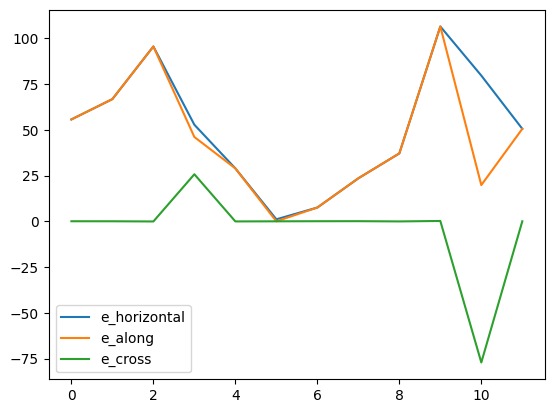

In [ ]:
plt.plot(df['e_horizontal'], label='e_horizontal')
plt.plot(df['e_along'], label='e_along')
plt.plot(df['e_cross'], label='e_cross')

plt.legend()

In [ ]:
df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + ".csv")
telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + 'A_JUNO_142_DELV_06' + ".csv")
p0= [flightPlan.loc[0,'FPLlat'], flightPlan.loc[0,'FPLlon'], flightPlan.loc[0,'FPLalt']]
p1= [flightPlan.loc[1,'FPLlat'], flightPlan.loc[1,'FPLlon'], flightPlan.loc[1,'FPLalt']]
secs=18.7
p2=[telemetry.loc[telemetry['secs'] == secs, 'lat'].values,telemetry.loc[telemetry['secs'] == secs, 'lon'].values,telemetry.loc[telemetry['secs'] == secs, 'alt'].values]
p0=[41.26524176,1.97890135,26]
p1=[41.26406284600235,1.9789006061137058,36]
from geopy import distance
distance_2d= distance.distance(p2[:2], p1[:2]).m
#2D geodesic distance in meters
print(distance_2d)
# 3D euclidean distance
distance_3d = np.sqrt(distance_2d**2 + (p1[2] - p2[2])**2)
print(distance_3d)

78.31108929630741
[78.54060546]


# dx, dy, dz model (test2)


In [ ]:
def extendedPlan(name, n):
  #name='A_JUNO_142_DELV_06'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  #for index, row in df_flightPlan.iterrows():
  #  df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
 # xo = df_flightPlan['FPLlat'][0]
 # yo = df_flightPlan['FPLlon'][0]
 # zo = df_flightPlan['FPLalt'][0]
  xo =0
  yo = 0
  zo = 0
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  #for index, row in telemetry.iterrows():
  #  telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_plan = row['time']
    time_tel = find_nearest(telemetry['secs'].values,row['time'])
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']
    df_flightPlanExpanded.at[index, 'dx'], df_flightPlanExpanded.at[index, 'dy']= get_xy_difference(row['x2'], row['y2'], row['x1'], row['y1'])
    df_flightPlanExpanded.at[index, 'dz'] = row['z2'] - row['z1']



  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','climb','cruise','hover', 'descent','x1', 'y1', 'z1', 'FPLvel','FPLturn', 'time','dx','dy','dz']]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'x1'] = flightPlanFix.loc[index+1,'x'] - flightPlanFix.loc[index,'x']
    df_flightPlanExpanded.at[index, 'y1'] = flightPlanFix.loc[index+1,'y'] - flightPlanFix.loc[index,'y']
    df_flightPlanExpanded.at[index, 'z1'] = flightPlanFix.loc[index+1,'z'] - flightPlanFix.loc[index,'z']

  return df_flightPlanExpanded

In [ ]:
extendedPlan('A_JUNO_142_DELV_06',1)

dronemodel  climb  cruise  hover  descent          x1          y1  \
0            0    1.0     0.0    0.0      0.0   93.815988    3.179164   
1            0    0.0     1.0    0.0      0.0   46.084307    1.559002   
2            0    0.0     1.0    0.0      0.0   -5.418620  158.210522   
3            0    0.0     1.0    0.0      0.0  -46.084307   -1.558996   
4            0    0.0     0.0    1.0      0.0  -38.314711   -1.307513   
5            0    0.0     0.0    0.0      1.0    0.000000    0.000000   
6            0    1.0     0.0    0.0      0.0    7.512252    0.259812   
7            0    1.0     0.0    0.0      0.0   53.339324    1.827141   
8            0    0.0     1.0    0.0      0.0   19.750582    0.668147   
9            0    0.0     1.0    0.0      0.0    5.018355 -146.520788   
10           0    0.0     1.0    0.0      0.0  -19.750582   -0.668149   
11           0    0.0     0.0    1.0      0.0 -120.124318   -4.088242   

           z1  FPLvel  FPLturn        time          dx         dy    dz  
0  -91.820684     7.0     65.0   18.758718   -0.069685 -77.703170  -5.9  
1  -52.553684    10.0     34.0   25.750201   -0.069675 -98.792337  -2.2  
2   -0.057513    10.0     34.0   41.580530   95.230805   0.078356   0.0  
3   52.553684    10.0     34.0   48.572013   25.656333  69.867509   0.0  
4   13.368586     3.0     17.0   62.105699   -0.047746  26.859216  14.9  
5    0.000000     0.0      0.2   72.105699    0.004045   0.868071   0.7  
6    6.595345     2.0      0.2   77.105699   -0.051587  -0.007078 -10.0  
7   -0.178021     2.0      0.2  103.791152   -0.082122 -15.680133 -17.5  
8  -22.523052    10.0     14.0  106.787516    0.027645 -41.455869 -13.0  
9    0.053351    10.0     14.0  121.448187 -106.116188   0.226161   0.1  
10  22.523052    10.0     14.0  124.444551  -76.870078  30.121706   0.0  
11  68.754564     4.0     14.0  159.061884    0.037713  54.989862  19.0

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last one, to try an unseen fligth
# fileName[-4:]
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

In [ ]:
dataset = pd.DataFrame()
n=1
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  if len(model[model.dz > 40])>0:
    print(row['ID'])
  dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

B_UTAH_1565_DELV_02
B_UTAH_980_DELV_02
B_SWORD_1455_DELV_10
C_OMAHA_1779_DELV_04
C_OMAHA_895_DELV_07
A_UTAH_183_DELV_03
C_UTAH_1492_DELV_01
B_SWORD_563_DELV_08
C_UTAH_747_DELV_01
B_UTAH_1514_DELV_01
C_UTAH_1112_DELV_04


dronemodel  climb  cruise  hover  descent         x1          y1  \
0           1    0.0     1.0    0.0      0.0  84.888381    2.871620   
1           1    0.0     1.0    0.0      0.0   6.947862 -201.964102   

          z1  FPLvel  FPLturn       time         dx        dy            dz  
0 -96.802687     5.0     64.0  25.756586  -0.043938 -0.576573 -1.999991e-01  
1   0.100165    10.0     64.0  45.964946 -27.127313 -0.037109  8.640000e-07

In [ ]:
dataset = dataset.drop(dataset[dataset.dx < -300].index)
dataset = dataset.drop(dataset[dataset.dx > 300].index)
dataset = dataset.drop(dataset[dataset.dy < -300].index)
dataset = dataset.drop(dataset[dataset.dy > 300].index)
dataset = dataset.reset_index(drop=True)

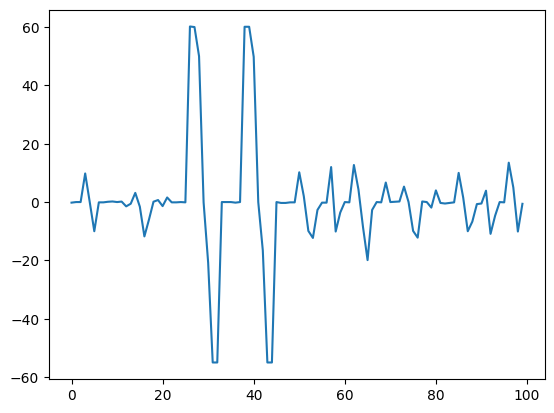

In [ ]:
plt.plot(dataset['dz'])

In [ ]:
datasetcopy = dataset


Method    Test MSE   Test R2
0  Random forest  652.380455  0.655409

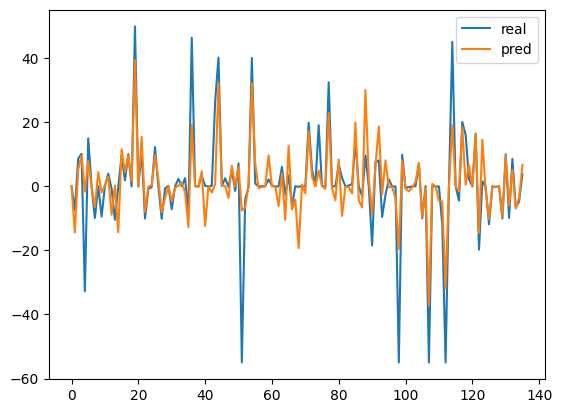

In [ ]:
y = datasetcopy[['dx','dy','dz']]

X = datasetcopy.drop(y.columns, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

plt.plot(y_test['dz'].reset_index(drop=True), label='real')
plt.plot(y_rf_test_pred[:,2], label='pred')
plt.legend()
from sklearn.metrics import mean_squared_error, r2_score

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random forest', rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Test MSE', 'Test R2']
rf_results

<ipython-input-382-faa256ed3f16>:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Method    Test MSE   Test R2
0  Random forest  712.833247  0.701848

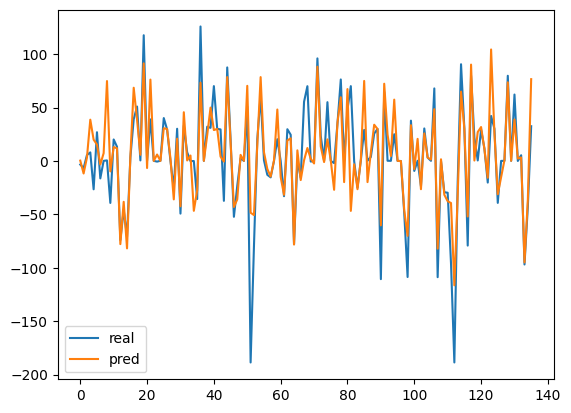

In [ ]:
# just dz
y0 = datasetcopy[['dx','dy','dz']]
y = datasetcopy[['dy']]
X = datasetcopy.drop(y0.columns, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

plt.plot(y_test.reset_index(drop=True), label='real')
plt.plot(y_rf_test_pred, label='pred')
plt.legend()
from sklearn.metrics import mean_squared_error, r2_score

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random forest', rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Test MSE', 'Test R2']
rf_results

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train['dx'], y=y_rf_train_pred[:,0], c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test['dx'], y=y_rf_test_pred[:,0], c="#7CAE00" ,alpha=0.3)

#plt.plot(y_train['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_train_pred[:,2][:10])

#plt.plot(y_test['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_test_pred[:,2][:10])


print('R2 dx test: ' + str(round(r2_score(y_test['dx'].reset_index(drop=True), y_rf_test_pred[:,0]),4)*100)+'%')
print('R2 dy test: ' + str(round(r2_score(y_test['dy'].reset_index(drop=True), y_rf_test_pred[:,1]),4)*100)+'%')
print('R2 dz test: ' + str(round(r2_score(y_test['dz'].reset_index(drop=True), y_rf_test_pred[:,2]),4)*100)+'%')

z = np.polyfit(y_train['dz'], y_rf_train_pred[:,2], 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')
plt.title('hi')

IndexError: ignored

<Figure size 500x500 with 0 Axes>

# time pred

In [ ]:
def extendedPlan(name, n):
  #name='A_JUNO_142_DELV_06'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  #for index, row in df_flightPlan.iterrows():
  #  df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
 # xo = df_flightPlan['FPLlat'][0]
 # yo = df_flightPlan['FPLlon'][0]
 # zo = df_flightPlan['FPLalt'][0]
  xo =0
  yo = 0
  zo = 0
  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  #for index, row in telemetry.iterrows():
  #  telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_plan = row['time']
    time_tel = find_nearest(telemetry['secs'].values,row['time'])
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']
    df_flightPlanExpanded.at[index, 'dx'], df_flightPlanExpanded.at[index, 'dy']= get_xy_difference(row['x2'], row['y2'], row['x1'], row['y1'])
    df_flightPlanExpanded.at[index, 'dz'] = row['z2'] - row['z1']



  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','climb','cruise','hover', 'descent','x1', 'y1', 'z1', 'FPLvel','FPLturn', 'time','closest']]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'x1'] = flightPlanFix.loc[index+1,'x'] - flightPlanFix.loc[index,'x']
    df_flightPlanExpanded.at[index, 'y1'] = flightPlanFix.loc[index+1,'y'] - flightPlanFix.loc[index,'y']
    df_flightPlanExpanded.at[index, 'z1'] = flightPlanFix.loc[index+1,'z'] - flightPlanFix.loc[index,'z']

  return df_flightPlanExpanded

In [ ]:
extendedPlan('A_JUNO_142_DELV_06',1)

dronemodel  climb  cruise  hover  descent          x1          y1  \
0            0    1.0     0.0    0.0      0.0   93.815988    3.179164   
1            0    0.0     1.0    0.0      0.0   46.084307    1.559002   
2            0    0.0     1.0    0.0      0.0   -5.418620  158.210522   
3            0    0.0     1.0    0.0      0.0  -46.084307   -1.558996   
4            0    0.0     0.0    1.0      0.0  -38.314711   -1.307513   
5            0    0.0     0.0    0.0      1.0    0.000000    0.000000   
6            0    1.0     0.0    0.0      0.0    7.512252    0.259812   
7            0    1.0     0.0    0.0      0.0   53.339324    1.827141   
8            0    0.0     1.0    0.0      0.0   19.750582    0.668147   
9            0    0.0     1.0    0.0      0.0    5.018355 -146.520788   
10           0    0.0     1.0    0.0      0.0  -19.750582   -0.668149   
11           0    0.0     0.0    1.0      0.0 -120.124318   -4.088242   

           z1  FPLvel  FPLturn        time  closest  
0  -91.820684     7.0     65.0   18.758718     29.0  
1  -52.553684    10.0     34.0   25.750201     35.4  
2   -0.057513    10.0     34.0   41.580530     50.9  
3   52.553684    10.0     34.0   48.572013     58.7  
4   13.368586     3.0     17.0   62.105699     78.7  
5    0.000000     0.0      0.2   72.105699     83.7  
6    6.595345     2.0      0.2   77.105699     88.3  
7   -0.178021     2.0      0.2  103.791152    111.8  
8  -22.523052    10.0     14.0  106.787516    115.8  
9    0.053351    10.0     14.0  121.448187    133.3  
10  22.523052    10.0     14.0  124.444551    139.0  
11  68.754564     4.0     14.0  159.061884    173.4

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last one, to try an unseen fligth
# fileName[-4:]
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

                     ID    maxError
0    A_JUNO_399_DELV_09   76.937243
17  A_OMAHA_401_DELV_01  162.210186
21   A_UTAH_391_DELV_07  140.106606
31  A_OMAHA_411_DELV_08  141.372395
33  B_UTAH_1348_DELV_02   34.580907
37  A_OMAHA_128_DELV_01  162.025126
40  B_UTAH_1006_DELV_01  131.528639
52  B_UTAH_1485_DELV_01   66.540797


In [ ]:
dataset = pd.DataFrame()
n=1
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

dronemodel  climb  cruise  hover  descent          x1        y1         z1  \
0           0    1.0     0.0    0.0      0.0  116.352878  3.957860 -72.034774   
1           0    0.0     1.0    0.0      0.0   19.750582  0.668149 -22.523052   

   FPLvel  FPLturn       time  closest  
0     3.0     65.0  45.634618     53.8  
1     5.0     14.0  51.627347     59.0

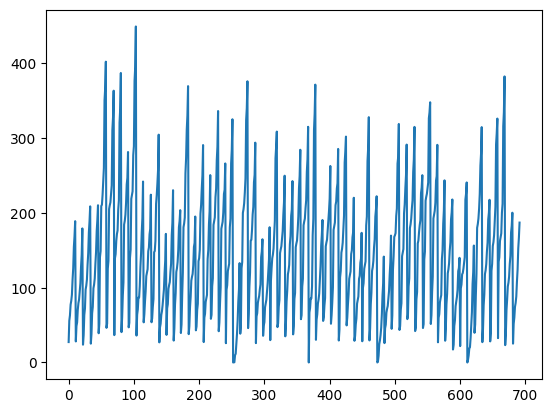

In [ ]:
plt.plot(dataset['closest'])

In [ ]:
datasetcopy = dataset

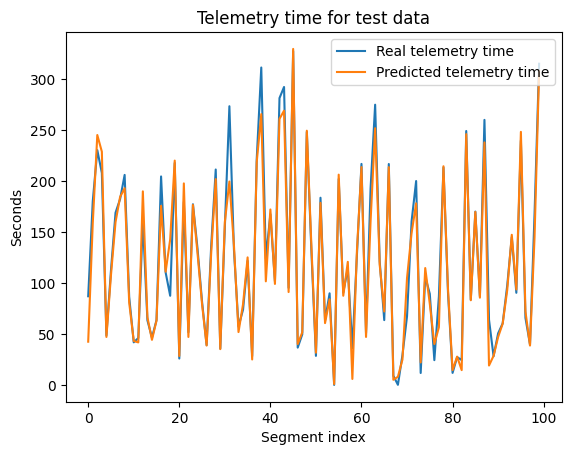

In [ ]:
y = datasetcopy[['closest']]

X = datasetcopy.drop(y.columns, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

plt.plot(y_test.reset_index(drop=True)[:100], label='Real telemetry time')
plt.plot(y_rf_test_pred[:100], label='Predicted telemetry time')
plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Telemetry time for test data')
plt.legend()
from sklearn.metrics import mean_squared_error, r2_score

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random forest', rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Test MSE', 'Test R2']
rf_results

R2 closest test: 96.23%


Text(0.5, 1.0, 'Telemetry time prediction')

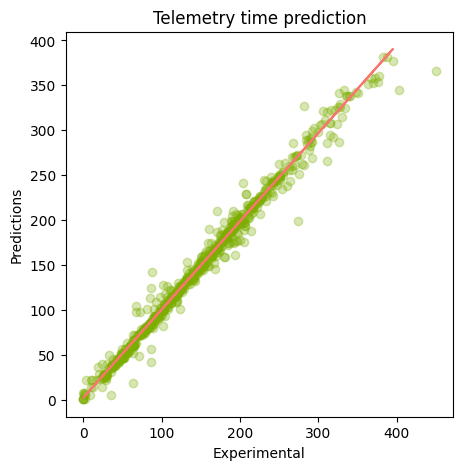

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_train_pred, c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test, y=y_rf_test_pred, c="#7CAE00" ,alpha=0.3)

#plt.plot(y_train['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_train_pred[:,2][:10])

#plt.plot(y_test['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_test_pred[:,2][:10])


print('R2 closest test: ' + str(round(r2_score(y_test['closest'].reset_index(drop=True), y_rf_test_pred),4)*100)+'%')


z = np.polyfit(y_train['closest'], y_rf_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train['closest'], p(y_train), '#F8766D')
plt.ylabel('Predictions')
plt.xlabel('Experimental')
plt.title('Telemetry time prediction')

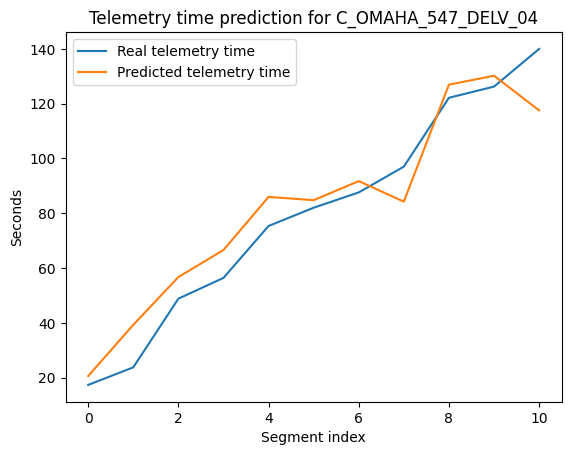

In [ ]:
pm = extendedPlan('A_UTAH_148_DELV_01',1)
#['A_UTAH_148_DELV_01',
#'C_OMAHA_547_DELV_04',
# 'C_UTAH_1492_DELV_01',
# 'B_UTAH_1093_DELV_01']
y_rf_flightplan= xgb.predict(pm.drop(['closest'], axis=1))
plt.plot(pm.closest, label = 'Real telemetry time')
plt.plot(y_rf_flightplan, label='Predicted telemetry time')
plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Telemetry time prediction for C_OMAHA_547_DELV_04')
plt.legend()

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train,np.ravel(y_train))
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_mae, rf_train_r2, rf_test_mse, rf_test_mae, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# linear
from sklearn.linear_model import LinearRegression, LogisticRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_mae, lr_train_r2, lr_test_mse, lr_test_mae, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(kernel='poly', C=1.0, epsilon=0.05)
svr.fit(X_train, y_train)
y_svr_train_pred = svr.predict(X_train)
y_svr_test_pred = svr.predict(X_test)

svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_mae = mean_absolute_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)
svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_mae = mean_absolute_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)
svr_results = pd.DataFrame(['Support Vector Regression', svr_train_mse, svr_train_mae, svr_train_r2, svr_test_mse, svr_test_mae, svr_test_r2]).transpose()
svr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=5
)
gbr.fit(X_train, y_train)
y_gbr_train_pred = gbr.predict(X_train)
y_gbr_test_pred = gbr.predict(X_test)

gbr_train_mse = mean_squared_error(y_train, y_gbr_train_pred)
gbr_train_mae = mean_absolute_error(y_train, y_gbr_train_pred)
gbr_train_r2 = r2_score(y_train, y_gbr_train_pred)
gbr_test_mse = mean_squared_error(y_test, y_gbr_test_pred)
gbr_test_mae = mean_absolute_error(y_test, y_gbr_test_pred)
gbr_test_r2 = r2_score(y_test, y_gbr_test_pred)
gbr_results = pd.DataFrame(['Gradient Boosting Regressor', gbr_train_mse, gbr_train_mae, gbr_train_r2, gbr_test_mse, gbr_test_mae, gbr_test_r2]).transpose()
gbr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# XGB
import xgboost as xgb
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.08,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_xgb_train_pred = xgb.predict(X_train)
y_xgb_test_pred = xgb.predict(X_test)

xgb_train_mse = mean_squared_error(y_train, y_xgb_train_pred)
xgb_train_mae = mean_absolute_error(y_train, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train, y_xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_mae = mean_absolute_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)
xgb_results = pd.DataFrame(['Extreme Gradient Boosting', xgb_train_mse, xgb_train_mae, xgb_train_r2, xgb_test_mse, xgb_test_mae, xgb_test_r2]).transpose()
xgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# LGB
import lightgbm as lgb
lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4
)
lgb.fit(X_train, y_train)
y_lgb_train_pred = lgb.predict(X_train)
y_lgb_test_pred = lgb.predict(X_test)

lgb_train_mse = mean_squared_error(y_train, y_lgb_train_pred)
lgb_train_mae = mean_absolute_error(y_train, y_lgb_train_pred)
lgb_train_r2 = r2_score(y_train, y_lgb_train_pred)
lgb_test_mse = mean_squared_error(y_test, y_lgb_test_pred)
lgb_test_mae = mean_absolute_error(y_test, y_lgb_test_pred)
lgb_test_r2 = r2_score(y_test, y_lgb_test_pred)
lgb_results = pd.DataFrame(['Light Gradient Boosting', lgb_train_mse, lgb_train_mae, lgb_train_r2, lgb_test_mse, lgb_test_mae, lgb_test_r2]).transpose()
lgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train.astype('int'))
y_nb_train_pred = nb.predict(X_train)
y_nb_test_pred = nb.predict(X_test)

nb_train_mse = mean_squared_error(y_train, y_nb_train_pred)
nb_train_mae = mean_absolute_error(y_train, y_nb_train_pred)
nb_train_r2 = r2_score(y_train, y_nb_train_pred)
nb_test_mse = mean_squared_error(y_test, y_nb_test_pred)
nb_test_mae = mean_absolute_error(y_test, y_nb_test_pred)
nb_test_r2 = r2_score(y_test, y_nb_test_pred)
nb_results = pd.DataFrame(['Naive Bayes', nb_train_mse, nb_train_mae, nb_train_r2, nb_test_mse, nb_test_mae, nb_test_r2]).transpose()
nb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train.astype('int'))
y_logreg_train_pred = logreg.predict(X_train)
y_logreg_test_pred = logreg.predict(X_test)

logreg_train_mse = mean_squared_error(y_train, y_logreg_train_pred)
logreg_train_mae = mean_absolute_error(y_train, y_logreg_train_pred)
logreg_train_r2 = r2_score(y_train, y_logreg_train_pred)
logreg_test_mse = mean_squared_error(y_test, y_logreg_test_pred)
logreg_test_mae = mean_absolute_error(y_test, y_logreg_test_pred)
logreg_test_r2 = r2_score(y_test, y_logreg_test_pred)
logreg_results = pd.DataFrame(['Logistic Regression', logreg_train_mse, logreg_train_mae, logreg_train_r2, logreg_test_mse, logreg_test_mae, logreg_test_r2]).transpose()
logreg_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_knn_train_pred = knn.predict(X_train)
y_knn_test_pred = knn.predict(X_test)

knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_mae = mean_absolute_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_mae = mean_absolute_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
knn_results = pd.DataFrame(['K-Nearest Neighbors', knn_train_mse, knn_train_mae, knn_train_r2, knn_test_mse, knn_test_mae, knn_test_r2]).transpose()
knn_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Putting it all together
results = pd.concat([rf_results, lr_results, svr_results, gbr_results, xgb_results, lgb_results, nb_results, logreg_results, knn_results], ignore_index=True)
results = results.sort_values('Test R2', ascending=False).reset_index(drop=True)
results


Method Training MSE Training MAE Training R2  \
0    Extreme Gradient Boosting   111.130981     7.221507     0.98372   
1      Light Gradient Boosting    46.874839     4.695847    0.993133   
2                Random forest    45.716048     4.245517    0.993303   
3            Linear regression   496.994395    15.497178    0.927194   
4          K-Nearest Neighbors   400.325735    14.577284    0.941355   
5                  Naive Bayes   849.831118    15.743056    0.875506   
6  Gradient Boosting Regressor   1110.38614    26.962428    0.837337   
7    Support Vector Regression  2687.250446    43.075991    0.606339   
8          Logistic Regression  1971.065657    25.968951    0.711254   

      Test MSE   Test MAE   Test R2  
0   273.333007  11.048393  0.969952  
1   342.066905  11.821495  0.962396  
2   342.700491  11.176066  0.962327  
3   478.821551  16.087737  0.947363  
4  1002.680543   20.82905  0.889774  
5  1675.559009  26.816619  0.815804  
6  1722.828618  32.805778  0.810608  
7  3458.586364  50.829521  0.619794  
8  3533.027211  39.364532  0.611611

# x2,y2,z2 pred

In [ ]:
def extendedPlan(name, n):
  #name='A_JUNO_142_DELV_06'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
  xo = df_flightPlan['FPLlat'][0]
  yo = df_flightPlan['FPLlon'][0]
  zo = df_flightPlan['FPLalt'][0]

  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_plan = row['time']
    time_tel = find_nearest(telemetry['secs'].values,row['time'])
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']
    df_flightPlanExpanded.at[index, 'dx'], df_flightPlanExpanded.at[index, 'dy']= get_xy_difference(row['x2'], row['y2'], row['x1'], row['y1'])
    df_flightPlanExpanded.at[index, 'dz'] = row['z2'] - row['z1']



  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','climb','cruise','hover', 'descent','x0','y0','z0','x1', 'y1', 'z1', 'FPLvel','FPLturn', 'time','x2','y2','z2']]

  return df_flightPlanExpanded

In [ ]:
extendedPlan('A_JUNO_142_DELV_06',1)

dronemodel  climb  cruise  hover  descent          x0          y0  \
0            0    1.0     0.0    0.0      0.0         0.0         0.0   
1            0    0.0     1.0    0.0      0.0   93.815988    3.179164   
2            0    0.0     1.0    0.0      0.0  139.900295    4.738166   
3            0    0.0     1.0    0.0      0.0  134.481675  162.948688   
4            0    0.0     0.0    1.0      0.0   88.397368  161.389692   
5            0    0.0     0.0    0.0      1.0   50.082657  160.082178   
6            0    1.0     0.0    0.0      0.0   50.082657  160.082178   
7            0    1.0     0.0    0.0      0.0   57.594908   160.34199   
8            0    0.0     1.0    0.0      0.0  110.934232  162.169131   
9            0    0.0     1.0    0.0      0.0  130.684814  162.837278   
10           0    0.0     1.0    0.0      0.0  135.703169    16.31649   
11           0    0.0     0.0    1.0      0.0  115.952587   15.648341   

            z0          x1          y1          z1  FPLvel  FPLturn  \
0          0.0   93.815988    3.179164  -91.820684     7.0     65.0   
1   -91.820684  139.900295    4.738166 -144.374368    10.0     34.0   
2  -144.374368  134.481675  162.948688 -144.431881    10.0     34.0   
3  -144.431881   88.397368  161.389692  -91.878197    10.0     34.0   
4   -91.878197   50.082657  160.082178  -78.509611     3.0     17.0   
5   -78.509611   50.082657  160.082178  -78.509611     0.0      0.2   
6   -78.509611   57.594908  160.341990  -71.914266     2.0      0.2   
7   -71.914266  110.934232  162.169131  -72.092287     2.0      0.2   
8   -72.092287  130.684814  162.837278  -94.615340    10.0     14.0   
9    -94.61534  135.703169   16.316490  -94.561988    10.0     14.0   
10  -94.561988  115.952587   15.648341  -72.038936    10.0     14.0   
11  -72.038936   -4.171731   11.560099   -3.284372     4.0     14.0   

          time          x2          y2          z2  
0    18.758718   38.226287    1.328331  -37.375576  
1    25.750201   73.206966    2.503670  -71.655459  
2    41.580530  137.832420   67.530357 -144.490708  
3    48.572013  135.282281  137.273011 -144.332418  
4    62.105699   78.956656  161.128687  -88.847388  
5    72.105699   51.180137  160.116076  -78.699648  
6    77.105699   50.076209  160.133707  -78.504297  
7   103.791152   87.462078  161.439728  -71.861987  
8   106.787516   93.627909  161.527929  -72.065514  
9   121.448187  132.251901  122.651907  -94.665830  
10  124.444551  133.120674   93.357009  -94.653365  
11  159.061884   46.305130   13.266470  -32.036824

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last one, to try an unseen fligth
# fileName[-4:]
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

In [ ]:
dataset = pd.DataFrame()
n=1
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

dronemodel  climb  cruise  hover  descent         x0       y0         z0  \
0           1    0.0     1.0    0.0      0.0        0.0      0.0        0.0   
1           1    0.0     1.0    0.0      0.0  84.888381  2.87162 -96.802687   

          x1          y1         z1  FPLvel  FPLturn       time         x2  \
0  84.888381    2.871620 -96.802687     5.0     64.0  25.756586  84.357030   
1  91.836243 -199.092481 -96.702522    10.0     64.0  45.964946  90.865409   

           y2         z2  
0    2.897177 -96.501721  
1 -171.912360 -96.674662

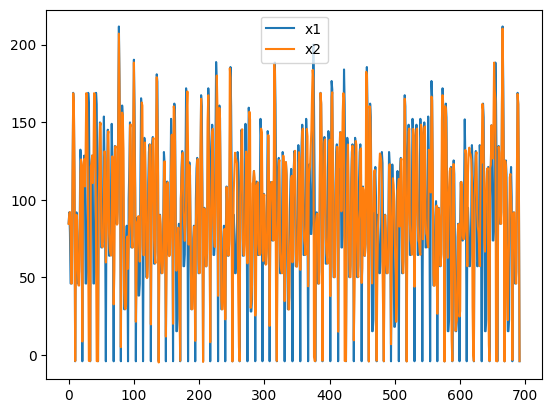

In [ ]:
plt.plot(dataset['x1'], label='x1')
plt.plot(dataset['x2'], label='x2')

plt.legend()

In [ ]:
datasetcopy = dataset

Method     Test MSE   Test R2
0  Random forest  1654.617476  0.864399

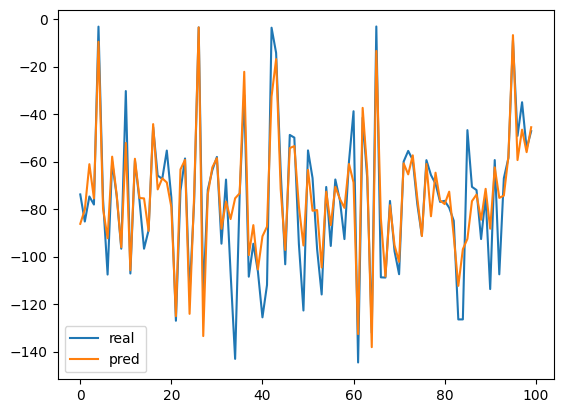

In [ ]:
y = datasetcopy[['x2','y2','z2']]

X = datasetcopy.drop(y.columns, axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

plt.plot(y_test['z2'][:100].reset_index(drop=True), label='real')
plt.plot(y_rf_test_pred[:,2][:100], label='pred')
plt.legend()
from sklearn.metrics import mean_squared_error, r2_score

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random forest', rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Test MSE', 'Test R2']
rf_results

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train['y2'], y=y_rf_train_pred[:,1], c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test['y2'], y=y_rf_test_pred[:,1], c="#7CAE00" ,alpha=0.3)

#plt.plot(y_train['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_train_pred[:,2][:10])

#plt.plot(y_test['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_test_pred[:,2][:10])


print('R2 dx test: ' + str(round(r2_score(y_test['x2'].reset_index(drop=True), y_rf_test_pred[:,0]),4)*100)+'%')
print('R2 dy test: ' + str(round(r2_score(y_test['y2'].reset_index(drop=True), y_rf_test_pred[:,1]),4)*100)+'%')
print('R2 dz test: ' + str(round(r2_score(y_test['z2'].reset_index(drop=True), y_rf_test_pred[:,2]),4)*100)+'%')

z = np.polyfit(y_train['x2'], y_rf_train_pred[:,0], 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')
plt.title('hi')

# normalized model min-max

In [ ]:
def extendedPlan(name, n):
  #name='A_JUNO_142_DELV_06'
  #n=1
  ### get a extended flighplan with interpolated points
  ### n is the number of added points in each segment of the flightplan
  ### the velocity is considered to be constant in all the segment

  ## read files
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  ## get the segment type and drone model
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)

  ## convert and replace the lat, lon, alt to x, y, z
  for index, row in df_flightPlan.iterrows():
    df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])

  ### substract the first point (xo,yo,zo) to set have the origin at (0, 0, 0)
  xo = df_flightPlan['FPLlat'][0]
  yo = df_flightPlan['FPLlon'][0]
  zo = df_flightPlan['FPLalt'][0]

  df_flightPlan['FPLlat'] = df_flightPlan['FPLlat'] - xo
  df_flightPlan['FPLlon'] = df_flightPlan['FPLlon'] - yo
  df_flightPlan['FPLalt'] = df_flightPlan['FPLalt'] - zo

  c=0
  df_flightPlanExpanded = pd.DataFrame(index=np.arange(0, n*len(df_flightPlan)), columns=['FPLlat', 'FPLlon', 'FPLalt'])
  for index, row in df_flightPlan.iterrows():
    for i in range(n):
      df_flightPlanExpanded.loc[c] = [df_flightPlan.at[index,'FPLlat'],df_flightPlan.at[index,'FPLlon'],df_flightPlan.at[index,'FPLalt']]
      c=c+1

  ## rename the columns. (x0, y0, z0) are the origins of the segments
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={'FPLlat': 'x0', 'FPLlon': 'y0', 'FPLalt':'z0'})

  ## shift x0, y0, z0 columns to have the end points of the segments (x1, y1, z1)
  for (i, original), (j, shift) in zip(df_flightPlanExpanded.iloc[:-n].iterrows(), df_flightPlanExpanded.iloc[n:].iterrows()):
    df_flightPlanExpanded.at[i,'x1'] = shift['x0']
    df_flightPlanExpanded.at[i,'y1'] = shift['y0']
    df_flightPlanExpanded.at[i,'z1'] = shift['z0']
  ## use the planFix function to get the total time and the time of each semgment
  ## we remove the first time value (0 s) as it is just the reference starting time for the plan
  flightPlanFix = planFix(name)
  timearray=flightPlanFix['time'].values[1:]
  timeSegarray=flightPlanFix['timeSeg'].values[1:]


  ## set the same velocity, segmentId, turn value and segment type to each point of a given segment
  ## set the global time and segment times only in the rows where it belongs (rows with original flightPlan points)
  ## then we will interpolate accordingly to fill the empty values
  ## (i*n:i*n+n) -> if n = 2 -> (0:2),(2:4),(4:6)...
  ## i*n+n-1 is every nth index and we substract 1 as the first index is 0 -> for n=2 -> index = 1 (2nd row = n), 3 (fourth row), 5...
  for i, row in flightPlanFix[:-1].iterrows():
    df_flightPlanExpanded.loc[i*n:i*n+n, "segId"] = i
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLvel"] = flightPlanFix.loc[i,'FPLvel']
    df_flightPlanExpanded.loc[i*n:i*n+n, "FPLturn"] = flightPlanFix.loc[i,'FPLturn']
    df_flightPlanExpanded.loc[i*n:i*n+n, "type"] = segmentType[i]
    df_flightPlanExpanded.loc[i*n+n-1, "time"] = timearray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "timeSeg"] = timeSegarray[i]
    df_flightPlanExpanded.loc[i*n+n-1, "closest"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    #print([sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]]])
  ## set the same drone model for all the dataframe
  df_flightPlanExpanded['dronemodel']=droneModel

  ## interpolation for the column 'time'
  ## we set the first row time to be the corresponding time (as it depends on n)
  ## now we can simply use interpolate as we have a continuous function
  df_flightPlanExpanded.loc[0, "time"] = timearray[0]/n
  df_flightPlanExpanded['time']=df_flightPlanExpanded['time'].interpolate()
  df_flightPlanExpanded=df_flightPlanExpanded[:-n]

  ### compute errors

  ## convert telemetry and rename lat, lon, alt to x2, y2, z2
  for index, row in telemetry.iterrows():
    telemetry.at[index,'lat'],telemetry.at[index,'lon'],telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  ## also substract the previous origin values to have telemetry in the same reference system
  telemetry['x2'] = telemetry['x2'] - xo
  telemetry['y2'] = telemetry['y2'] - yo
  telemetry['z2'] = telemetry['z2'] - zo

  ## find where the telemetry is at the time where the end of the segmen has to be reached
  for index, row in df_flightPlanExpanded.iterrows():
    time_plan = row['time']
    time_tel = find_nearest(telemetry['secs'].values,row['time'])
    df_flightPlanExpanded.at[index, 'x2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'x2'].iloc[0])
    df_flightPlanExpanded.at[index, 'y2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'y2'].iloc[0])
    df_flightPlanExpanded.at[index, 'z2'] = (telemetry.loc[telemetry['secs'] == time_tel, 'z2'].iloc[0])
  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index, 'delay'] = row['closest'] - row['time']

  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(df_flightPlanExpanded[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  df_flightPlanExpanded = df_flightPlanExpanded.join(encoder_df)

  df_flightPlanExpanded['delay']=df_flightPlanExpanded['delay'].shift(1, fill_value=0)
  df_flightPlanExpanded = df_flightPlanExpanded.rename(columns={0: 'climb', 1: 'cruise', 2:'hover',3:'descent'})
  df_flightPlanExpanded = df_flightPlanExpanded[['dronemodel','climb','cruise','hover', 'descent','x0','y0','z0','x1', 'y1', 'z1', 'FPLvel','FPLturn', 'time','x2','y2','z2']]

  return df_flightPlanExpanded

In [ ]:
extendedPlan('A_JUNO_142_DELV_06',1).head(3)

dronemodel  climb  cruise  hover  descent          x0        y0  \
0           0    1.0     0.0    0.0      0.0         0.0       0.0   
1           0    0.0     1.0    0.0      0.0   93.815988  3.179164   
2           0    0.0     1.0    0.0      0.0  139.900295  4.738166   

           z0          x1          y1          z1  FPLvel  FPLturn       time  \
0         0.0   93.815988    3.179164  -91.820684     7.0     65.0  18.758718   
1  -91.820684  139.900295    4.738166 -144.374368    10.0     34.0  25.750201   
2 -144.374368  134.481675  162.948688 -144.431881    10.0     34.0  41.580530   

           x2         y2          z2  
0   38.226287   1.328331  -37.375576  
1   73.206966   2.503670  -71.655459  
2  137.832420  67.530357 -144.490708

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last ones, to try an unseen fligth
# fileName[-4:]
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

                     ID    maxError
8   A_OMAHA_411_DELV_08  141.372395
15   A_JUNO_399_DELV_09   76.937243
20  A_OMAHA_128_DELV_01  162.025126
28  B_UTAH_1348_DELV_02   34.580907
33  B_UTAH_1006_DELV_01  131.528639
50  B_UTAH_1485_DELV_01   66.540797
62   A_UTAH_391_DELV_07  140.106606
66  A_OMAHA_401_DELV_01  162.210186


In [ ]:
dataset = pd.DataFrame()
n=1
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

dronemodel  climb  cruise  hover  descent         x0        y0         z0  \
0           2    0.0     1.0    0.0      0.0        0.0       0.0        0.0   
1           2    0.0     1.0    0.0      0.0  83.665965  2.830298 -95.408731   

          x1          y1         z1  FPLvel  FPLturn       time         x2  \
0  83.665965    2.830298 -95.408731     5.0     63.0  25.385689  52.302474   
1  90.317702 -190.820622 -95.321521    10.0     63.0  44.762204  82.300838   

           y2         z2  
0 -192.247487 -67.885027  
1 -191.052452 -72.231529

In [ ]:
datasetcopy = dataset

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column
encoder_df = pd.DataFrame(encoder.fit_transform(datasetcopy[['dronemodel']]).toarray())

#merge one-hot encoded columns back with original DataFrame
datasetcopy = datasetcopy.join(encoder_df)

datasetcopy = datasetcopy.rename(columns={0: 'model1', 1: 'model2', 2:'model3',3:'model4'})
datasetcopy = datasetcopy[['model1','model2','model3','model4','climb','cruise','hover', 'descent','x0','y0','z0','x1', 'y1', 'z1', 'FPLvel','FPLturn', 'time','x2','y2','z2']]
datasetcopy= datasetcopy.drop(['y2','z2'], axis=1)
datasetcopy.head(2)

model1  model2  model3  model4  climb  cruise  hover  descent         x0  \
0     0.0     0.0     1.0     0.0    0.0     1.0    0.0      0.0        0.0   
1     0.0     0.0     1.0     0.0    0.0     1.0    0.0      0.0  83.665965   

         y0         z0         x1          y1         z1  FPLvel  FPLturn  \
0       0.0        0.0  83.665965    2.830298 -95.408731     5.0     63.0   
1  2.830298 -95.408731  90.317702 -190.820622 -95.321521    10.0     63.0   

        time         x2  
0  25.385689  52.302474  
1  44.762204  82.300838

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(datasetcopy), columns=datasetcopy.columns)
data_norm.head(2)
data_norm.shape

(692, 18)

In [ ]:
y = data_norm[['x2']]
X = data_norm.drop(y.columns, axis=1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train,np.ravel(y_train))
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

# linear
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(kernel='poly', C=1.0, epsilon=0.05)
svr.fit(X_train, y_train)
y_svr_train_pred = svr.predict(X_train)
y_svr_test_pred = svr.predict(X_test)

svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)
svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)
svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).transpose()
svr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']


# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=5
)
gbr.fit(X_train, y_train)
y_gbr_train_pred = gbr.predict(X_train)
y_gbr_test_pred = gbr.predict(X_test)

gbr_train_mse = mean_squared_error(y_train, y_gbr_train_pred)
gbr_train_r2 = r2_score(y_train, y_gbr_train_pred)
gbr_test_mse = mean_squared_error(y_test, y_gbr_test_pred)
gbr_test_r2 = r2_score(y_test, y_gbr_test_pred)
gbr_results = pd.DataFrame(['gbr', gbr_train_mse, gbr_train_r2, gbr_test_mse, gbr_test_r2]).transpose()
gbr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']


# XGB
import xgboost as xgb
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.08,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_xgb_train_pred = xgb.predict(X_train)
y_xgb_test_pred = xgb.predict(X_test)

xgb_train_mse = mean_squared_error(y_train, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train, y_xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)
xgb_results = pd.DataFrame(['xgb', xgb_train_mse, xgb_train_r2, xgb_test_mse, xgb_test_r2]).transpose()
xgb_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']


# LGB
import lightgbm as lgb
lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4
)
lgb.fit(X_train, y_train)
y_lgb_train_pred = lgb.predict(X_train)
y_lgb_test_pred = lgb.predict(X_test)

lgb_train_mse = mean_squared_error(y_train, y_lgb_train_pred)
lgb_train_r2 = r2_score(y_train, y_lgb_train_pred)
lgb_test_mse = mean_squared_error(y_test, y_lgb_test_pred)
lgb_test_r2 = r2_score(y_test, y_lgb_test_pred)
lgb_results = pd.DataFrame(['lgb', lgb_train_mse, lgb_train_r2, lgb_test_mse, lgb_test_r2]).transpose()
lgb_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']


plt.plot(y_test['x2'][:100].reset_index(drop=True), label='real')
plt.plot(y_rf_test_pred[:100], label='pred')
plt.legend()

df_models = pd.concat([lr_results, rf_results, svr_results,gbr_results,lgb_results], axis=0)
df_models.reset_index(drop=True)



In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

def find_best_parameters(estimator, param_grid, X, y):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(estimator, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    estimator.set_params(**best_params)
    estimator.fit(X_train, np.ravel(y_train))
    val_score = estimator.score(X_val, y_val)

    return best_params, best_score, val_score
#######################

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#  parameter grid
param_grid = {
    'max_depth': [2,3,4,5,10,15, 20, 25, 30,35,40, 40, 60, 80 ,100],
    'n_estimators': [10, 20, 50, 75, 100, 150, 200, 300, 500, 1000, 1300, 1500, 2000]
}

rf = RandomForestRegressor()
best_params, best_score, val_score = find_best_parameters(rf, param_grid, X_train, y_train)

print("Best Parameters:", best_params)
print("Best Train Score:", best_score)
print("Validation Score:", val_score)

rf.set_params(**best_params)
rf.fit(X_train, y_train)
test_score = rf.score(X_test, y_test)
print("Test Score:", test_score)

Best Parameters: {'max_depth': 25, 'n_estimators': 150}
Best Train Score: 0.6503041645104222
Validation Score: 0.6357698169224797


<ipython-input-242-0a48a3b3791d>:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Test Score: 0.7098581079729096


R2 dx test: 71.35000000000001%


Text(0.5, 1.0, 'hi')

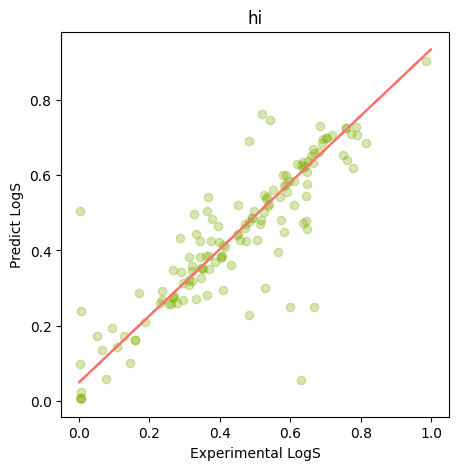

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train['x2'], y=y_rf_train_pred, c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test['x2'], y=y_rf_test_pred, c="#7CAE00" ,alpha=0.3)

#plt.plot(y_train['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_train_pred[:,2][:10])

#plt.plot(y_test['e_cross'].reset_index(drop=True)[:10])
#plt.plot(y_rf_test_pred[:,2][:10])


print('R2 dx test: ' + str(round(r2_score(y_test['x2'].reset_index(drop=True), y_rf_test_pred),4)*100)+'%')

z = np.polyfit(y_train['x2'], y_rf_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')
plt.title('hi')

In [ ]:
data_copy = X_test
data_copy['x2'] = y_rf_test_pred
data_copy_inv = pd.DataFrame(data=scaler.inverse_transform(data_copy), columns=datasetcopy.columns)
plt.plot(data_copy_inv['x2'])

Index(['model1', 'model2', 'model3', 'model4', 'climb', 'cruise', 'hover',
       'descent', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'FPLvel', 'FPLturn',
       'time', 'x2'],
      dtype='object')

# ML0 - predict time (points)

In [ ]:
def mlmodel_time(name):
  #name='A_JUNO_142_DELV_06'
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  pf=planFixENU(name)
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)
  pf = pf.rename(columns={'time': 't_fp', 'timeSeg': 't_seg_fp','x':'x0','y':'y0','z':'z0','FPLvel':'vel_fp','FPLturn':'turn_fp'})

  # find t_tel. We want the telemetry time at the end of each segment -> syncPlan()
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  for i, row in pf.iterrows():
    pf.loc[i, "t_tel"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i)*50))[0][0]][0]]['secs']
    pf.loc[i, "segId"] = i

  for i, row in pf[:-1].iterrows():
    pf.loc[i, "type"] = segmentType[i]
  pf.at[pf.index[-1], 'type']='Exit'

  ### one-hot
  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'team' column
  encoder_df = pd.DataFrame(encoder.fit_transform(pf[['type']]).toarray())

  #merge one-hot encoded columns back with original DataFrame
  pf = pf.join(encoder_df)
  pf = pf.rename(columns={0: 'segType0', 1: 'segType1', 2:'segType2',3:'segType3',4:'segType4'})
  pf = pf.drop(['WPname','FPLwpt','Unnamed: 0','type'], axis=1)

  pf['dronemodel']=droneModel
  #dist

  return pf

```
                     ID        avg
0   A_OMAHA_401_DELV_01  34.978104
32  B_UTAH_1006_DELV_01  62.272099
36  A_OMAHA_128_DELV_01  27.542285
65   A_UTAH_391_DELV_07  22.722760
67  A_OMAHA_411_DELV_08  35.686670
```


```
                      ID         max
0    A_OMAHA_401_DELV_01  164.232920
2    C_OMAHA_895_DELV_07  546.733617
15  B_OMAHA_1505_DELV_04  344.288035
18    A_JUNO_399_DELV_09  168.138181
31   B_OMAHA_626_DELV_03  219.976219
32   B_UTAH_1006_DELV_01  793.807503
35  B_OMAHA_1002_DELV_03  229.335179
36   A_OMAHA_128_DELV_01  164.819868
53  B_OMAHA_1556_DELV_03  221.611771
54   B_UTAH_1485_DELV_01  109.581935
65    A_UTAH_391_DELV_07  214.546941
67   A_OMAHA_411_DELV_08  235.730072
```

In [ ]:
ml = mlmodel_time('C_OMAHA_895_DELV_07')
plt.plot(ml['t_tel']-ml['t_fp'])

NameError: ignored

In [ ]:
'''
dataset0 = pd.DataFrame({'ID': fileName})
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)
'''
dataset0 = pd.DataFrame({'ID': fileName})
dataset0['avgError']=dataset0.apply(lambda x: computeAvgError(x['ID'])[0], axis=1)
print(dataset0.loc[dataset0['avgError']>=8.5])
dataset0.drop(dataset0.loc[dataset0['avgError']>=8.5].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)


validation=dataset0[-4:].reset_index(drop=True)
dataset0=dataset0[:-4] ## except the last ones, to try an unseen fligth

ID  avgError
0     A_JUNO_409_DELV_08  1.697593
1    B_JUNO_1422_DELV_10  3.456381
2   B_OMAHA_1479_DELV_05  2.292463
3    B_SWORD_563_DELV_08  2.337337
4    A_OMAHA_170_DELV_01  2.472729
5   B_OMAHA_1577_DELV_03  0.971135
6     C_UTAH_747_DELV_01  0.980718
7   B_OMAHA_1054_DELV_05  2.255557
8   B_SWORD_1455_DELV_10  1.921369
9   B_OMAHA_1526_DELV_03  1.115008
10   C_OMAHA_970_DELV_02  1.137359
11   B_JUNO_1434_DELV_06  1.072889
12   B_JUNO_1321_DELV_06  0.920881
13  C_OMAHA_1779_DELV_04  0.795671
14    C_JUNO_891_DELV_08  1.463359
15  B_OMAHA_1444_DELV_02  0.672876
16   B_UTAH_1565_DELV_02  0.692961
17   C_JUNO_1625_DELV_08  1.269705
18    C_JUNO_959_DELV_08  1.185756
19  B_OMAHA_1347_DELV_06  2.187375
20    B_JUNO_527_DELV_07  1.116247
21   B_UTAH_1365_DELV_01  0.821357
22   C_UTAH_1005_DELV_04  2.462664
23   C_JUNO_1693_DELV_07  1.347821
24  B_OMAHA_1331_DELV_02  0.943908
25   B_OMAHA_561_DELV_04  0.764010
26    A_UTAH_148_DELV_01  1.410919
27   C_UTAH_1492_DELV_01  0.957145
28  C_OMAHA_1092_DELV_03  1.170727
29    C_JUNO_926_DELV_06  0.933296
30   C_JUNO_1755_DELV_10  3.519512
31   C_UTAH_1720_DELV_02  0.777423
32    C_JUNO_634_DELV_08  1.158781
33   B_OMAHA_701_DELV_03  0.907084
34   B_OMAHA_677_DELV_05  1.743007
35   B_OMAHA_545_DELV_05  2.016414
36   C_JUNO_1083_DELV_05  1.295150
37   B_UTAH_1514_DELV_01  0.780406
38   B_OMAHA_643_DELV_06  3.718927
39  B_OMAHA_1396_DELV_03  0.942612
40   B_UTAH_1414_DELV_02  1.022623
41    A_UTAH_405_DELV_04  3.807799
42  C_OMAHA_1038_DELV_04  0.854186
43   C_UTAH_1112_DELV_04  2.458186
44  C_OMAHA_1733_DELV_04  1.358380
45  B_OMAHA_1556_DELV_03  8.016458
46  B_SWORD_1538_DELV_11  2.280032
47    A_JUNO_372_DELV_08  1.229856
48   A_OMAHA_371_DELV_06  2.632538
49    A_UTAH_183_DELV_03  1.994460
50    C_UTAH_945_DELV_02  1.510970
51   B_OMAHA_965_DELV_04  1.371758
52   B_JUNO_1359_DELV_07  1.049639
53    B_UTAH_980_DELV_02  0.779325
54  B_SWORD_1582_DELV_09  1.489453
55   B_OMAHA_745_DELV_02  0.660042

In [ ]:
dataset = pd.DataFrame()
for ind, row in dataset0.iterrows():
  model = mlmodel_time(row['ID'])
  model['id'] = ind
  dataset = pd.concat([dataset, model])
dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

x0          y0        z0  vel_fp  turn_fp   t_seg_fp       t_fp  \
0  0.000000    0.000000  0.000000     9.0     75.0   0.000000   0.000000   
1 -0.071847 -150.905209 -0.001789    10.0     75.0  16.767247  16.767247   

   t_tel  segId  segType0  segType1  segType2  segType3  segType4  dronemodel  \
0    0.0    0.0       0.0       1.0       0.0       0.0       0.0           0   
1   25.9    1.0       0.0       1.0       0.0       0.0       0.0           0   

   id  
0   0  
1   0

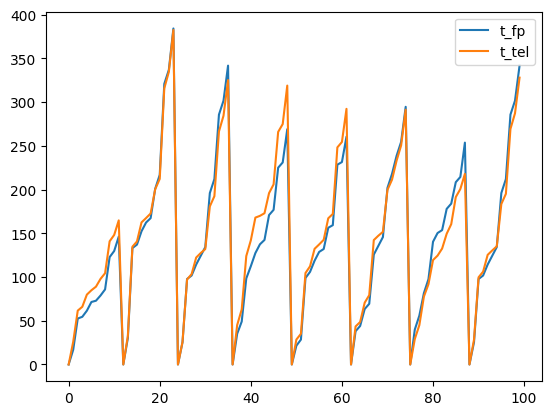

In [ ]:
plt.plot(dataset['t_fp'][:100],label='t_fp')
plt.plot(dataset['t_tel'][:100],label='t_tel')
plt.legend()

In [ ]:
''' ORDERED FLIGHTS '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


selected_features = ['segId','dronemodel','segType0','segType1', 'segType2','segType3','segType4','x0', 'y0', 'z0', 'vel_fp', 'turn_fp', 't_fp']
target_variable = 't_tel'

X = dataset[selected_features]
y = dataset[target_variable]

flight_ids = dataset['id'].unique()

train_flight_ids, test_flight_ids = train_test_split(flight_ids, test_size=0.2, random_state=42)

train_indices = dataset['id'].isin(train_flight_ids)
test_indices = dataset['id'].isin(test_flight_ids)

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
print(X_train.shape)
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
print("Model Score:", score)


(553, 13)
Model Score: 0.9681588735851865


In [ ]:
''' UNORDERDED '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

selected_features = ['segId','dronemodel','segType0','segType1', 'segType2','segType3','segType4','x0', 'y0', 'z0', 'vel_fp', 'turn_fp', 't_fp']
target_variable = 't_tel'

X = dataset[selected_features]
y = dataset[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
print("Model Score:", score)

Model Score: 0.9699803169039862


In [ ]:
''' VALIDATION '''
valname = validation.loc[0,'ID']
dfvalidation = mlmodel_time(valname)
t_tel = dfvalidation['t_tel']
dfvalidation = dfvalidation[]
print(dfvalidation.shape)

y_pred = rf.predict(dfvalidation)

dfvalidation['t_ml'] = y_pred

uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + valname + '.csv')

results_df = pd.DataFrame({'t_us':uspace['secs'],'t_fp': dfvalidation['t_fp'], 't_ml': y_pred, 't_tel':t_tel})
plt.plot(results_df['t_us'], c='deepskyblue', label='t_us',  alpha=0.8)
plt.plot(results_df['t_fp'], c='chartreuse', label='t_fp',  alpha=0.8)
plt.plot(results_df['t_ml'], c='maroon', label='t_ml')
plt.plot(results_df['t_tel'], c='orangered', label='t_tel')
plt.legend()

'C_OMAHA_547_DELV_04'

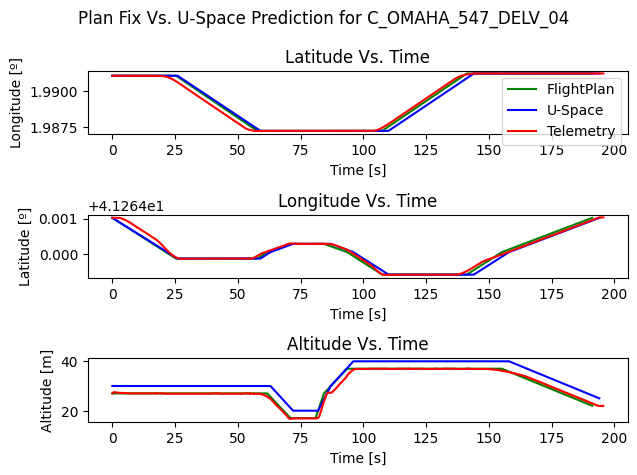

In [ ]:
subplotPlanVsUspace('C_OMAHA_547_DELV_04')



---



# ML1- predict time (segments)

In [ ]:
def mlmodel_time(name):
  #name='A_JUNO_142_DELV_06'
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  pf=planFixENU(name)
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)
  droneOperator = definePlanOperator(name)
  pf = pf.rename(columns={'time': 't_fp', 'timeSeg': 't_seg_fp','x':'x0','y':'y0','z':'z0','FPLvel':'vel_fp','FPLturn':'turn_fp'})

  # find t_tel. We want the telemetry time at the end of each segment -> syncPlan()
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  fpi = planInfoENU(name)

  delayindex=1
  t_tel_start_delay = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],delayindex))[0][0]][0]]['secs']
  telemetry['secs']=telemetry['secs']-t_tel_start_delay
  #telemetry=telemetry[(t_tel_start_delay*10).astype('int'):].reset_index(drop=True)
  #crop_index = (t_tel_start_delay*10).astype('int')
  #cropped_data = sync[crop_index:]
  #sync = [(x[0] - sync[crop_index][0], x[1] - sync[crop_index][1]) for x in cropped_data]

  for (i, original), (j, shift) in zip(pf.iloc[:-1].iterrows(), pf.iloc[1:].iterrows()):
    pf.at[i,'x1'] = shift['x0']
    pf.at[i,'y1'] = shift['y0']
    pf.at[i,'z1'] = shift['z0']
    pf.at[i,'t_seg_fp'] = shift['t_seg_fp']
    pf.at[i,'t_fp'] = shift['t_fp']

  pf=pf[:-1]
  for i, row in pf.iterrows():
    pf.loc[i, "t_tel"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    pf.loc[i, "segId"] = i
  ### one hot encoding
  pf['JUNO']=0
  pf['OMAHA']=0
  pf['UTAH']=0
  pf['SWORD']=0
  if droneOperator == 'JUNO':
    pf['JUNO']=1
  if droneOperator == 'OMAHA':
    pf['OMAHA']=1
  if droneOperator == 'UTAH':
    pf['UTAH']=1
  if droneOperator == 'SWORD':
    pf['SWORD']=1

  pf['M300']=0
  pf['M600']=0
  pf['Mavic2']=0
  pf['S9000']=0
  if droneOperator == '0':
    pf['M300']=1
  if droneOperator == '1':
    pf['M600']=1
  if droneOperator == '2':
    pf['Mavic2']=1
  if droneOperator == '3':
    pf['s9000']=1

  pf['climb']=0
  pf['cruise']=0
  pf['descent']=0
  pf['hover']=0
  for i, row in pf.iterrows():
    if segmentType[i] == 'Climb':
      pf.loc[i, "climb"] = 1
    if segmentType[i] == 'Cruise':
      pf.loc[i, "cruise"] = 1
    if segmentType[i] == 'Descent':
      pf.loc[i, "descent"] = 1
    if segmentType[i] == 'Hover':
      pf.loc[i, "hover"] = 1
  ### end of one hot encoding

  pf['3Ddist']=fpi['3Ddist']
  pf['2Ddist']=fpi['2Ddist']
  pf['2Dtime']=fpi['time2D']

  lat0,lon0,h0=[df_flightPlan.loc[0,'FPLlat'],df_flightPlan.loc[0,'FPLlon'],df_flightPlan.loc[0,'FPLalt']]
  for i, row in telemetry.iterrows():
    telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  for i, row in pf.iterrows():
    close_tel = find_nearest(telemetry['secs'].values,row['t_fp'])
    pf.at[i, 'x2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'x2'].iloc[0])
    pf.at[i, 'y2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'y2'].iloc[0])
    pf.at[i, 'z2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'z2'].iloc[0])
    pf.at[i, 'x3'] = row['x1'] -row['x0']
    pf.at[i, 'y3'] = row['y1'] -row['y0']
    pf.at[i, 'z3'] = row['z1'] -row['z0']
  for i, row in pf.iterrows():
    pf.at[i, 'dx'] = row['x2'] -row['x1']
    pf.at[i, 'dy'] = row['y2'] -row['y1']
    pf.at[i, 'dz'] = row['z2'] -row['z1']

  hoverindex = pf.loc[(pf.x3 ==0) & (pf.y3 == 0) & (pf.z3 == 0)].index.values
  t_tel_hover_start = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],((hoverindex)*50)-2))[0][0]][0]]['secs']
  t_tel_hover_end = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],((hoverindex+1)*50)+2))[0][0]][0]]['secs']
  pf.at[hoverindex[0]-1, 't_tel'] = t_tel_hover_start
  pf.at[hoverindex[0], 't_tel'] = t_tel_hover_end
  pf['t_seg_tel']=pf['t_tel'].diff()
  pf.loc[0, "t_seg_tel"] = pf.loc[0, "t_tel"]
return pf


x1          y1         z1          x2          y2         z2  \
0    -0.062337 -130.929782   9.998653   -0.043449 -130.019882   9.298672   
1    -0.095624 -200.844605   9.996830    9.716812 -195.286866  10.096996   
2   158.207656 -200.919397   9.994869  155.563165 -186.902580  10.095361   
3   158.240949 -131.004574   9.996691  158.360370 -133.278082   8.596641   
4   158.257279  -95.670870 -10.002680  158.253259  -96.537893  -9.302693   
5   158.257279  -95.670870 -10.002680  158.243660  -95.798608 -10.002681   
6   158.257527  -95.671020  -0.002680  158.448714  -95.550402  -1.302683   
7   158.241692 -131.005192  39.996691  158.184267 -147.565923  39.796330   
8   158.227424 -160.968830  39.996004  150.131244 -161.481987  39.896187   
9    11.620728 -160.899564  39.997955   22.995250 -160.829760  39.997926   
10   11.634994 -130.935926  39.998642   11.108227 -152.465401  39.998164   
11   11.697261    0.017779  -5.000011   11.692103  -17.167611   0.999966   

           dx         dy        dz        t_fp  t_tel   t_seg_fp  t_seg_tel  
0    0.018888   0.909900 -0.699981   18.758718   19.0  18.758718       19.0  
1    9.812436   5.557739  0.100166   25.750201   25.4   6.991483        6.4  
2   -2.644490  14.016818  0.100492   41.580530   40.9  15.830330       15.5  
3    0.119421  -2.273508 -1.400050   48.572013   48.7   6.991483        7.8  
4   -0.004020  -0.867023  0.699987   62.105699   62.1  13.533685       13.4  
5   -0.013619  -0.127738 -0.000002   72.105699   74.2  10.000000       12.1  
6    0.191188   0.120619 -1.300003   77.105699   78.3   5.000000        4.1  
7   -0.057425 -16.560731 -0.200361  103.791152  101.8  26.685453       23.5  
8   -8.096179  -0.513158 -0.099818  106.787516  105.8   2.996364        4.0  
9   11.374521   0.069804 -0.000029  121.448187  123.3  14.660671       17.5  
10  -0.526767 -21.529475 -0.000478  124.444551  129.0   2.996364        5.7  
11  -0.005158 -17.185390  5.999977  159.061884  163.4  34.617333       34.4

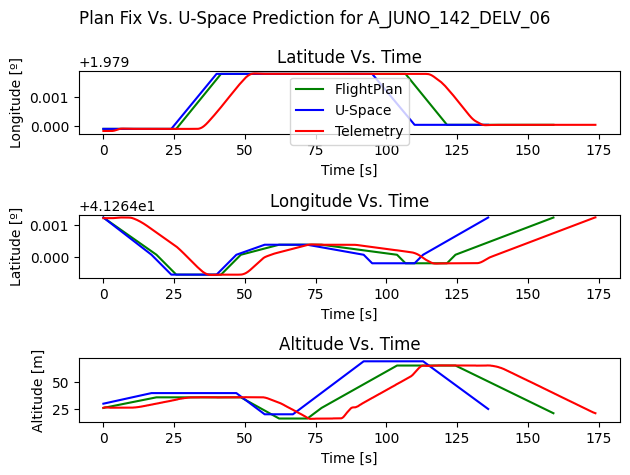

In [ ]:
subplotPlanVsUspace('A_JUNO_142_DELV_06')

In [ ]:
ml=mlmodel_time('A_JUNO_142_DELV_06')
ml[['x0','y0','z0','x1','y1','z1','x2','y2','z2','t_fp','t_tel','t_seg_fp','t_seg_tel']]

x0          y0         z0          x1          y1         z1  \
0     0.000000    0.000000   0.000000   -0.062337 -130.929782   9.998653   
1    -0.062337 -130.929782   9.998653   -0.095624 -200.844605   9.996830   
2    -0.095624 -200.844605   9.996830  158.207656 -200.919397   9.994869   
3   158.207656 -200.919397   9.994869  158.240949 -131.004574   9.996691   
4   158.240949 -131.004574   9.996691  158.257279  -95.670870 -10.002680   
5   158.257279  -95.670870 -10.002680  158.257279  -95.670870 -10.002680   
6   158.257279  -95.670870 -10.002680  158.257527  -95.671020  -0.002680   
7   158.257527  -95.671020  -0.002680  158.241692 -131.005192  39.996691   
8   158.241692 -131.005192  39.996691  158.227424 -160.968830  39.996004   
9   158.227424 -160.968830  39.996004   11.620728 -160.899564  39.997955   
10   11.620728 -160.899564  39.997955   11.634994 -130.935926  39.998642   
11   11.634994 -130.935926  39.998642   11.697261    0.017779  -5.000011   

            x2          y2         z2        t_fp  t_tel   t_seg_fp  t_seg_tel  
0    -0.043449 -130.019882   9.298672   18.758718   19.0  18.758718       19.0  
1     9.716812 -195.286866  10.096996   25.750201   25.4   6.991483        6.4  
2   155.563165 -186.902580  10.095361   41.580530   40.9  15.830330       15.5  
3   158.360370 -133.278082   8.596641   48.572013   48.7   6.991483        7.8  
4   158.253259  -96.537893  -9.302693   62.105699   62.1  13.533685       13.4  
5   158.243660  -95.798608 -10.002681   72.105699   74.2  10.000000       12.1  
6   158.448714  -95.550402  -1.302683   77.105699   78.3   5.000000        4.1  
7   158.184267 -147.565923  39.796330  103.791152  101.8  26.685453       23.5  
8   150.131244 -161.481987  39.896187  106.787516  105.8   2.996364        4.0  
9    22.995250 -160.829760  39.997926  121.448187  123.3  14.660671       17.5  
10   11.108227 -152.465401  39.998164  124.444551  129.0   2.996364        5.7  
11   11.692103  -17.167611   0.999966  159.061884  163.4  34.617333       34.4

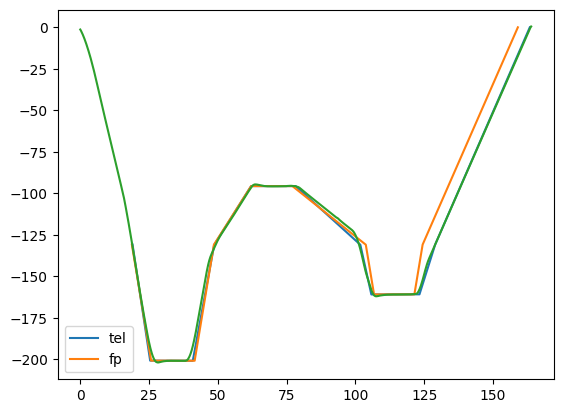

In [ ]:
plt.plot(pf['t_tel'],pf['y1'],label='tel')
plt.plot(pf['t_fp'],pf['y1'],label='fp')
plt.plot((telemetry['secs'])[100:],telemetry['y2'][100:])
plt.legend()

In [ ]:
ml=mlmodel_time('A_JUNO_142_DELV_06')
df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + 'A_JUNO_142_DELV_06' + ".csv")
telemetry=pd.read_csv(dataUnzip + 'Telemetry_' + 'A_JUNO_142_DELV_06' + ".csv")
lat0,lon0,h0=[df_flightPlan.loc[0,'FPLlat'],df_flightPlan.loc[0,'FPLlon'],df_flightPlan.loc[0,'FPLalt']]
for i, row in telemetry.iterrows():
  telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
ml[['x0','y0','z0','x1','y1','z1','t_fp','t_tel','t_seg_fp','t_seg_tel']]

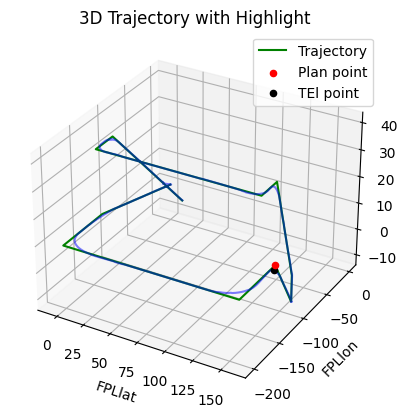

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
df=df_flightPlanExpanded
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['FPLlat'], df['FPLlon'], df['FPLalt'], c='green', label='Trajectory')
ax.plot3D(df_telemetry['lat'], df_telemetry['lon'], df_telemetry['alt'], "blue", alpha=0.5)

highlight_index = 200
highlight_point = df.loc[highlight_index]
ax.scatter(highlight_point['FPLlat'], highlight_point['FPLlon'], highlight_point['FPLalt'], c='red', label='Plan point')

#telemetry index
highlight_index2=587
highlight_point2 = df_telemetry.loc[highlight_index2]
ax.scatter(highlight_point2['lat'], highlight_point2['lon'], highlight_point2['alt'], c='k', label='TEl point')

ax.set_xlabel('FPLlat')
ax.set_ylabel('FPLlon')
ax.set_zlabel('FPLalt')
ax.set_title('3D Trajectory with Highlight')

ax.legend()
plt.show()


In [ ]:
syncPlan('A_JUNO_142_DELV_06')

In [ ]:
'''
dataset0 = pd.DataFrame({'ID': fileName})
#
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

validation=dataset0[-6:].reset_index(drop=True)
dataset0=dataset0[:-6] ## except the last ones, to try an unseen fligth
'''
dataset0 = pd.DataFrame({'ID': fileName})
dataset0['avgError']=dataset0.apply(lambda x: computeAvgError(x['ID'])[0], axis=1)
print(dataset0.loc[dataset0['avgError']>=8.5])
dataset0.drop(dataset0.loc[dataset0['avgError']>=8.5].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

#  IDs to extract
ids_to_extract = ['A_OMAHA_371_DELV_06', 'A_UTAH_183_DELV_03', 'A_OMAHA_170_DELV_01', 'B_SWORD_563_DELV_08','B_JUNO_1422_DELV_10']

validation = dataset0[dataset0['ID'].isin(ids_to_extract)].reset_index(drop=True)

dataset0 = dataset0[~dataset0['ID'].isin(ids_to_extract)].reset_index(drop=True)


Index(['Unnamed: 0', 'WPname', 'x0', 'y0', 'z0', 'vel_fp', 'turn_fp', 'FPLwpt',
       't_seg_fp', 't_fp', 'x1', 'y1', 'z1', 't_tel', 'segId', 'JUNO', 'OMAHA',
       'UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise',
       'descent', 'hover', '3Ddist', '2Ddist', '2Dtime', 'x2', 'y2', 'z2',
       'x3', 'y3', 'z3', 't_seg_tel', 'id'],
      dtype='object')

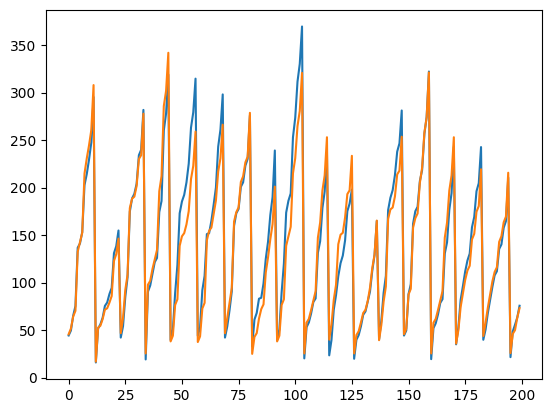

In [ ]:
dataset = pd.DataFrame()
for ind, row in dataset0.iterrows():
  model = mlmodel_time(row['ID'])
  model['id'] = ind
  dataset = pd.concat([dataset, model])
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(dataset[dataset['t_tel'] < 0.8].index)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['t_tel'])
plt.plot(dataset['t_tel'][:200])
plt.plot(dataset['t_fp'][:200])

dataset.head(2)
dataset.columns

In [ ]:
''' ORDERED FLIGHTS '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# relevant features and target variable
#selected_features = ['segId','JUNO', 'OMAHA','UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise','descent', 'hover', 'x0', 'y0', 'z0', 'x1','y1','z1', 'vel_fp', 'turn_fp', 't_fp','3Ddist','2Ddist','2Dtime']
selected_features = ['JUNO', 'OMAHA','UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise','descent', 'hover', 'x3', 'y3', 'z3', 'vel_fp', 'turn_fp', 't_seg_fp','3Ddist','2Ddist','2Dtime']

target_variable = 't_seg_tel'

X = dataset[selected_features]
#X['segId']=X['segId'].astype('int')
y = dataset[target_variable].values
#y=y.astype('int')

flight_ids = dataset['id'].unique()

train_flight_ids, test_flight_ids = train_test_split(flight_ids, test_size=0.2, random_state=42)

train_indices = dataset['id'].isin(train_flight_ids)
test_indices = dataset['id'].isin(test_flight_ids)

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
print(X_train.shape)
# model
rf = RandomForestRegressor(max_depth=24, random_state=10)

# Train
rf.fit(X_train, y_train)

# Evaluate
score = rf.score(X_test, y_test)
print("Model Score:", score)

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = rf.predict(X_test)
# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


JUNO  OMAHA  UTAH  SWORD  M300  M600  Mavic2  S9000         z0  \
463     0      0     1      0     0     0       0      0  49.993887   
188     1      0     0      0     0     0       0      0 -10.002680   
15      1      0     0      0     0     0       0      0  -0.011366   
578     1      0     0      0     0     0       0      0  39.998653   
211     1      0     0      0     0     0       0      0 -10.010662   
..    ...    ...   ...    ...   ...   ...     ...    ...        ...   
71      1      0     0      0     0     0       0      0  49.996507   
106     0      1     0      0     0     0       0      0  -0.009467   
270     0      0     1      0     0     0       0      0 -10.003588   
435     0      1     0      0     0     0       0      0   9.997529   
102     0      1     0      0     0     0       0      0  49.997243   

             x3         y3         z3  vel_fp  turn_fp      3Ddist   t_seg_fp  
463    0.038909  60.906190 -59.999250     2.0     30.0   85.495471  42.747735  
188    0.000000   0.000000   0.000000     0.0      0.2    0.000000  10.000000  
15     0.019821  40.470587  -9.999296     6.0      9.0   41.687585   6.947931  
578   -0.014266 -29.963638  -0.000687     5.0     14.0   29.963641   5.992728  
211    0.000000   0.000000   0.000000     0.0      0.2    0.000000  10.000000  
..          ...        ...        ...     ...      ...         ...        ...  
71   158.304270  -0.074793  -0.001962    10.0     39.0  158.304288  15.830429  
106    0.012316  19.975635   0.000367     5.0      9.0   19.975639   3.995128  
270   -0.000316  -0.000111  10.000000     3.0      0.2   10.000000   3.333333  
435    0.043117  69.914830   0.001559     5.0     34.0   69.914843  13.982969  
102    0.049277  79.903164   0.001845     5.0     39.0   79.903180  15.980636  

[444 rows x 16 columns]

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np

models = [rf, lr, svr, gbr, xgb, lgb, knn]

results_df = pd.DataFrame(columns=['Model', 'Mean CV Score'])

for model in models:
    #  cross-vaidation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_score = np.mean(cv_scores)

    results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)

print(results_df)


<ipython-input-244-8e715403d34f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)
<ipython-input-244-8e715403d34f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)
<ipython-input-244-8e715403d34f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)
<ipython-input-244-8e715403d34f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

                       Model  Mean CV Score
0      RandomForestRegressor       0.947960
1           LinearRegression       0.887469
2                        SVR       0.390219
3  GradientBoostingRegressor       0.816825
4               XGBRegressor       0.958602
5              LGBMRegressor       0.950068
6        KNeighborsRegressor       0.871746


<ipython-input-244-8e715403d34f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)


In [ ]:
''' UNORDERDED '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


#selected_features = ['segId', 'JUNO', 'OMAHA','UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise','descent', 'hover','x0', 'y0', 'z0', 'x1','y1','z1', 'vel_fp', 'turn_fp', 't_fp','3Ddist','2Ddist','2Dtime','t_tel']
selected_features = ['JUNO', 'OMAHA','UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'z0','x3', 'y3', 'z3', 'vel_fp', 'turn_fp','3Ddist' ,'t_seg_fp']

target_variable = 't_seg_tel'

X = dataset[selected_features]
y = dataset[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor()

rf.fit(X_train, y_train)


score = rf.score(X_test, y_test)
print("Model Score:", score)
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


Model Score: 0.9661569082707392
Mean Squared Error (MSE): 9.801354841465589
Mean Absolute Error (MAE): 1.7360538201588993


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np

models = [rf, lr, svr, gbr, xgb, lgb, knn]

results_df = pd.DataFrame(columns=['Model', 'Mean CV Score'])

for model in models:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_score = np.mean(cv_scores)

    results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)

results_df = results_df.sort_values(by='Mean CV Score', ascending=False).reset_index(drop=True)
(results_df)


Model  Mean CV Score
0               XGBRegressor       0.958373
1      RandomForestRegressor       0.950995
2              LGBMRegressor       0.949403
3           LinearRegression       0.888538
4        KNeighborsRegressor       0.873500
5  GradientBoostingRegressor       0.819367
6                        SVR       0.412052

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train,np.ravel(y_train))
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_mae, rf_train_r2, rf_test_mse, rf_test_mae, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# linear
from sklearn.linear_model import LinearRegression, LogisticRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_mae, lr_train_r2, lr_test_mse, lr_test_mae, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(kernel='poly', C=1.0, epsilon=0.05)
svr.fit(X_train, y_train)
y_svr_train_pred = svr.predict(X_train)
y_svr_test_pred = svr.predict(X_test)

svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_mae = mean_absolute_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)
svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_mae = mean_absolute_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)
svr_results = pd.DataFrame(['Support Vector Regression', svr_train_mse, svr_train_mae, svr_train_r2, svr_test_mse, svr_test_mae, svr_test_r2]).transpose()
svr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=5
)
gbr.fit(X_train, y_train)
y_gbr_train_pred = gbr.predict(X_train)
y_gbr_test_pred = gbr.predict(X_test)

gbr_train_mse = mean_squared_error(y_train, y_gbr_train_pred)
gbr_train_mae = mean_absolute_error(y_train, y_gbr_train_pred)
gbr_train_r2 = r2_score(y_train, y_gbr_train_pred)
gbr_test_mse = mean_squared_error(y_test, y_gbr_test_pred)
gbr_test_mae = mean_absolute_error(y_test, y_gbr_test_pred)
gbr_test_r2 = r2_score(y_test, y_gbr_test_pred)
gbr_results = pd.DataFrame(['Gradient Boosting Regressor', gbr_train_mse, gbr_train_mae, gbr_train_r2, gbr_test_mse, gbr_test_mae, gbr_test_r2]).transpose()
gbr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# XGB
import xgboost as xgb
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.08,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_xgb_train_pred = xgb.predict(X_train)
y_xgb_test_pred = xgb.predict(X_test)

xgb_train_mse = mean_squared_error(y_train, y_xgb_train_pred)
xgb_train_mae = mean_absolute_error(y_train, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train, y_xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_mae = mean_absolute_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)
xgb_results = pd.DataFrame(['Extreme Gradient Boosting', xgb_train_mse, xgb_train_mae, xgb_train_r2, xgb_test_mse, xgb_test_mae, xgb_test_r2]).transpose()
xgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# LGB
import lightgbm as lgb
lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4
)
lgb.fit(X_train, y_train)
y_lgb_train_pred = lgb.predict(X_train)
y_lgb_test_pred = lgb.predict(X_test)

lgb_train_mse = mean_squared_error(y_train, y_lgb_train_pred)
lgb_train_mae = mean_absolute_error(y_train, y_lgb_train_pred)
lgb_train_r2 = r2_score(y_train, y_lgb_train_pred)
lgb_test_mse = mean_squared_error(y_test, y_lgb_test_pred)
lgb_test_mae = mean_absolute_error(y_test, y_lgb_test_pred)
lgb_test_r2 = r2_score(y_test, y_lgb_test_pred)
lgb_results = pd.DataFrame(['Light Gradient Boosting', lgb_train_mse, lgb_train_mae, lgb_train_r2, lgb_test_mse, lgb_test_mae, lgb_test_r2]).transpose()
lgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train.astype('int'))
y_nb_train_pred = nb.predict(X_train)
y_nb_test_pred = nb.predict(X_test)

nb_train_mse = mean_squared_error(y_train, y_nb_train_pred)
nb_train_mae = mean_absolute_error(y_train, y_nb_train_pred)
nb_train_r2 = r2_score(y_train, y_nb_train_pred)
nb_test_mse = mean_squared_error(y_test, y_nb_test_pred)
nb_test_mae = mean_absolute_error(y_test, y_nb_test_pred)
nb_test_r2 = r2_score(y_test, y_nb_test_pred)
nb_results = pd.DataFrame(['Naive Bayes', nb_train_mse, nb_train_mae, nb_train_r2, nb_test_mse, nb_test_mae, nb_test_r2]).transpose()
nb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train.astype('int'))
y_logreg_train_pred = logreg.predict(X_train)
y_logreg_test_pred = logreg.predict(X_test)

logreg_train_mse = mean_squared_error(y_train, y_logreg_train_pred)
logreg_train_mae = mean_absolute_error(y_train, y_logreg_train_pred)
logreg_train_r2 = r2_score(y_train, y_logreg_train_pred)
logreg_test_mse = mean_squared_error(y_test, y_logreg_test_pred)
logreg_test_mae = mean_absolute_error(y_test, y_logreg_test_pred)
logreg_test_r2 = r2_score(y_test, y_logreg_test_pred)
logreg_results = pd.DataFrame(['Logistic Regression', logreg_train_mse, logreg_train_mae, logreg_train_r2, logreg_test_mse, logreg_test_mae, logreg_test_r2]).transpose()
logreg_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_knn_train_pred = knn.predict(X_train)
y_knn_test_pred = knn.predict(X_test)

knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_mae = mean_absolute_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_mae = mean_absolute_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
knn_results = pd.DataFrame(['K-Nearest Neighbors', knn_train_mse, knn_train_mae, knn_train_r2, knn_test_mse, knn_test_mae, knn_test_r2]).transpose()
knn_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Putting it all together
results = pd.concat([rf_results, lr_results, svr_results, gbr_results, xgb_results, lgb_results, nb_results, logreg_results, knn_results], ignore_index=True)
results = results.sort_values('Test R2', ascending=False).reset_index(drop=True)
results


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Method Training MSE Training MAE Training R2  \
0    Extreme Gradient Boosting     4.821829      1.46676     0.98503   
1                Random forest     4.398357     1.159206    0.986345   
2      Light Gradient Boosting     2.935195     0.969014    0.990887   
3            Linear regression    33.177059     4.123997    0.896997   
4          K-Nearest Neighbors    28.037504     3.073477    0.912954   
5  Gradient Boosting Regressor     50.61728     5.320519    0.842851   
6          Logistic Regression    30.204646     2.458919    0.906225   
7                  Naive Bayes    48.021403     4.272613    0.850911   
8    Support Vector Regression   186.171006     8.929255    0.422006   

     Test MSE  Test MAE   Test R2  
0    8.782494  1.926014  0.969675  
1   10.535697   1.75674  0.963621  
2   11.273491  1.893045  0.961074  
3   28.483019  3.665935  0.901651  
4   32.523697  3.517162  0.887699  
5    48.15829  5.351004  0.833714  
6   49.272711  3.532565  0.829866  
7   58.228208  5.214031  0.798944  
8  168.066106  8.428362  0.419685

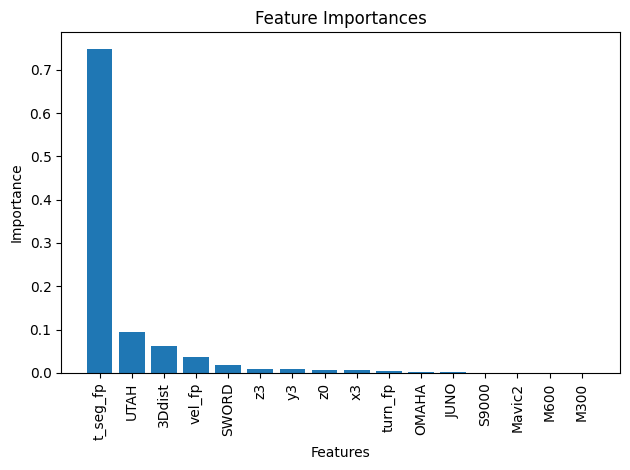

In [ ]:
importances = xgb.feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names
feature_names = X.columns[sorted_indices]

# Plot the feature importances
plt.bar(range(len(importances)), sorted_importances, tick_label=feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

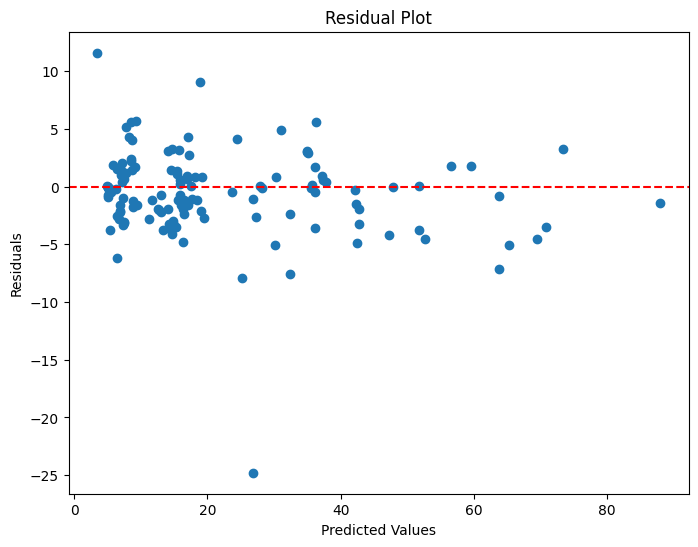

In [ ]:
# Residual Plot
y_pred = xgb.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
importance = xgb.feature_importances_
sns.barplot(x=importance, y=X_train.columns)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

NameError: ignored

<Figure size 1000x600 with 0 Axes>

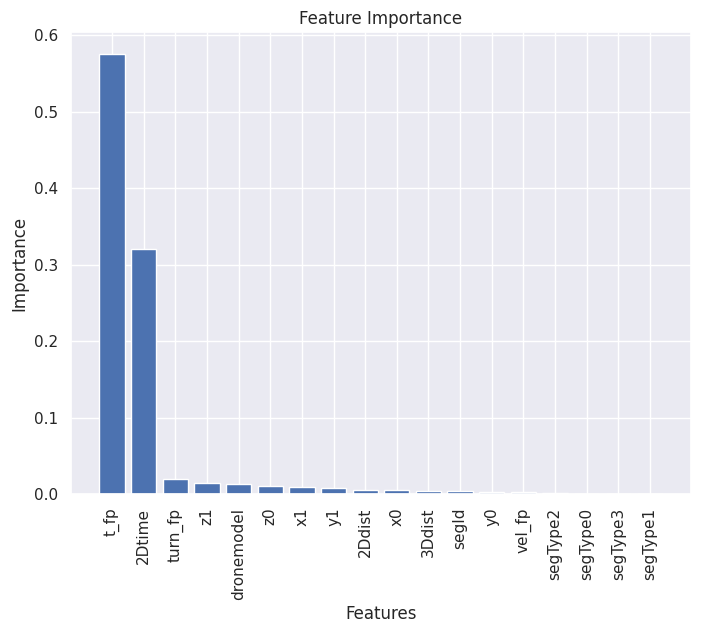

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the trained model stored in 'model' and the feature names in 'features'

# Get feature importances from the model
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(len(X_train.columns)), importances[indices])
plt.xticks(range(len(X_train.columns)), np.array(X_train.columns)[indices], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


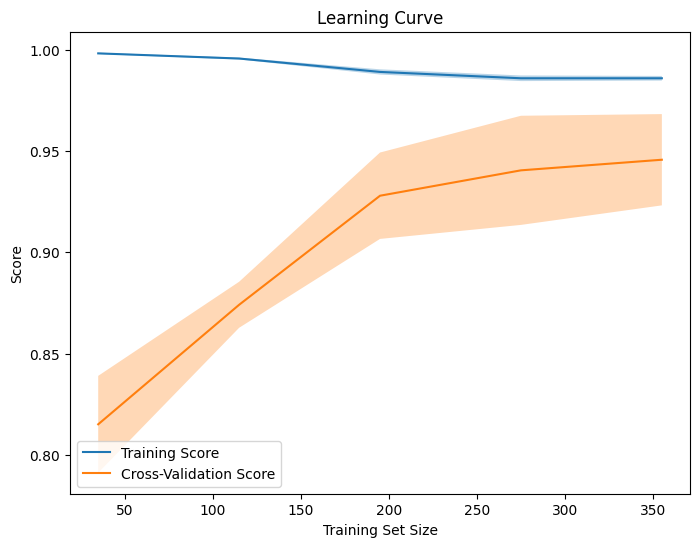

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming you have the trained model stored in 'model' and the training features and labels in 'X_train' and 'y_train'

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(xgb, X_train, y_train, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


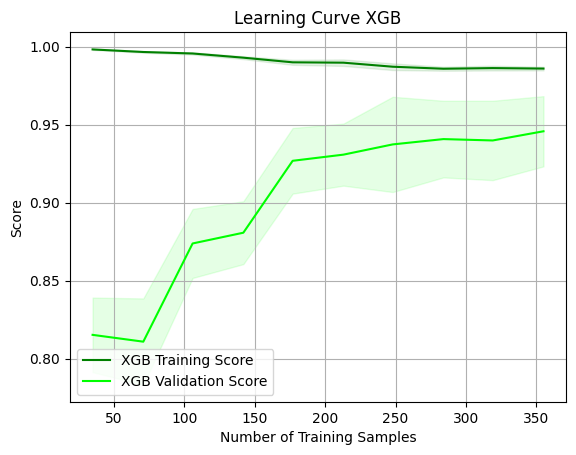

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming you have the trained models stored in 'model1' and 'model2' and the training data in 'X_train' and 'y_train'

# Define the number of training samples at which to evaluate the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curves for both models
train_sizes_abs, train_scores1, test_scores1 = learning_curve(rf, X_train, y_train, train_sizes=train_sizes)
train_sizes_abs, train_scores2, test_scores2 = learning_curve(xgb, X_train, y_train, train_sizes=train_sizes)
train_sizes_abs, train_scores3, test_scores3 = learning_curve(lr, X_train, y_train, train_sizes=train_sizes)

# Compute the mean and standard deviation of the training and test scores
train_scores_mean1 = np.mean(train_scores1, axis=1)
train_scores_std1 = np.std(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)
test_scores_std1 = np.std(test_scores1, axis=1)

train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

train_scores_mean3 = np.mean(train_scores3, axis=1)
train_scores_std3 = np.std(train_scores3, axis=1)
test_scores_mean3 = np.mean(test_scores3, axis=1)
test_scores_std3 = np.std(test_scores3, axis=1)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_scores_mean1, label='RF Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean1 - train_scores_std1, train_scores_mean1 + train_scores_std1, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, test_scores_mean1, label='RF Validation Score', color='deepskyblue')
plt.fill_between(train_sizes_abs, test_scores_mean1 - test_scores_std1, test_scores_mean1 + test_scores_std1, alpha=0.1, color='deepskyblue')

plt.plot(train_sizes_abs, train_scores_mean2, label='XGB Training Score', color='green')
plt.fill_between(train_sizes_abs, train_scores_mean2 - train_scores_std2, train_scores_mean2 + train_scores_std2, alpha=0.1, color='green')
plt.plot(train_sizes_abs, test_scores_mean2, label='XGB Validation Score', color='lime')
plt.fill_between(train_sizes_abs, test_scores_mean2 - test_scores_std2, test_scores_mean2 + test_scores_std2, alpha=0.1, color='lime')

plt.plot(train_sizes_abs, train_scores_mean3, label='LR Training Score', color='red')
plt.fill_between(train_sizes_abs, train_scores_mean3 - train_scores_std3, train_scores_mean3 + train_scores_std3, alpha=0.1, color='red')
plt.plot(train_sizes_abs, test_scores_mean3, label='LR Validation Score', color='orange')
plt.fill_between(train_sizes_abs, test_scores_mean3 - test_scores_std3, test_scores_mean3 + test_scores_std3, alpha=0.1, color='orange')

plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.title('Learning Curves Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.show()


(12, 16)
MSE for t_us: 1652.1666666666667
MSE for t_fp: 1078.6910553853738
MSE for t_ml: 578.4823064996417


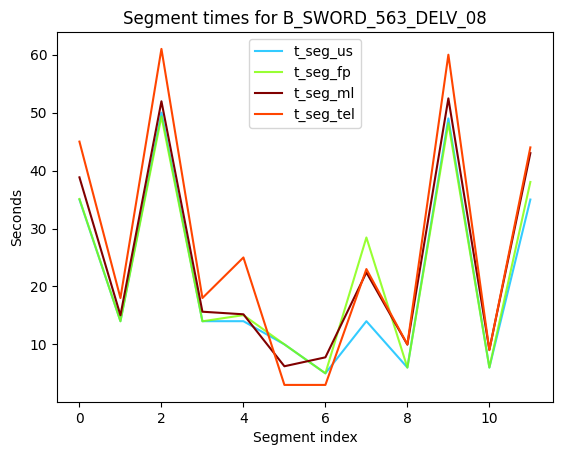

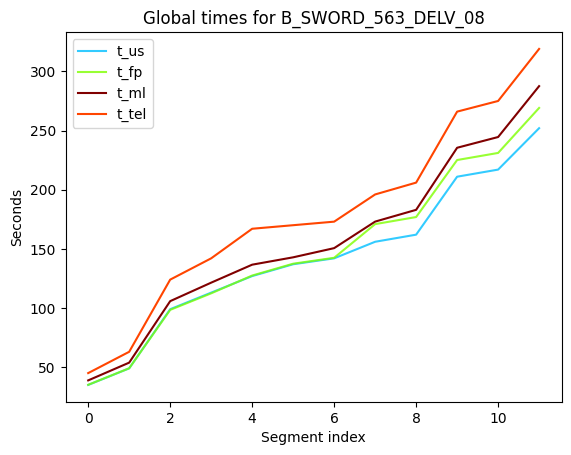

In [ ]:
''' VALIDATION '''
valname = validation.loc[2,'ID']
dfvalidation = general_df = mlmodel_time(valname)
real = dfvalidation[target_variable]
dfvalidation = dfvalidation[selected_features]
print(dfvalidation.shape)
# trained model to make predictions
y_pred = xgb.predict(dfvalidation)

uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + valname + '.csv')
uspace['t_seg_us'] = uspace['secs'].diff()

plt.figure()
results_df = pd.DataFrame({'t_seg_us':uspace['t_seg_us'][1:].reset_index(drop=True),'t_seg_fp': general_df['t_seg_fp'], 't_seg_ml': y_pred, 't_seg_tel':real.values})
plt.plot(results_df['t_seg_us'], c='deepskyblue', label='t_seg_us',  alpha=0.8)
plt.plot(results_df['t_seg_fp'], c='chartreuse', label='t_seg_fp',  alpha=0.8)
plt.plot(results_df['t_seg_ml'], c='maroon', label='t_seg_ml')
plt.plot(results_df['t_seg_tel'], c='orangered', label='t_seg_tel')
plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Segment times for '+ valname)
plt.legend()

results_df['t_us'] = results_df['t_seg_us'].cumsum()
results_df['t_fp'] = results_df['t_seg_fp'].cumsum()
results_df['t_ml'] = results_df['t_seg_ml'].cumsum()
results_df['t_tel'] = results_df['t_seg_tel'].cumsum()
# cumulative sum of the columns
plt.figure()

plt.plot(results_df['t_us'], c='deepskyblue', label='t_us',  alpha=0.8)
plt.plot(results_df['t_fp'], c='chartreuse', label='t_fp',  alpha=0.8)
plt.plot(results_df['t_ml'], c='maroon', label='t_ml')
plt.plot(results_df['t_tel'], c='orangered', label='t_tel')

plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Global times for '+ valname)
plt.legend()

mse_us = mean_squared_error(results_df['t_us'], results_df['t_tel'])
mse_fp = mean_squared_error(results_df['t_fp'], results_df['t_tel'])
mse_ml = mean_squared_error(results_df['t_ml'], results_df['t_tel'])

print("MSE for t_us:", mse_us)
print("MSE for t_fp:", mse_fp)
print("MSE for t_ml:", mse_ml)

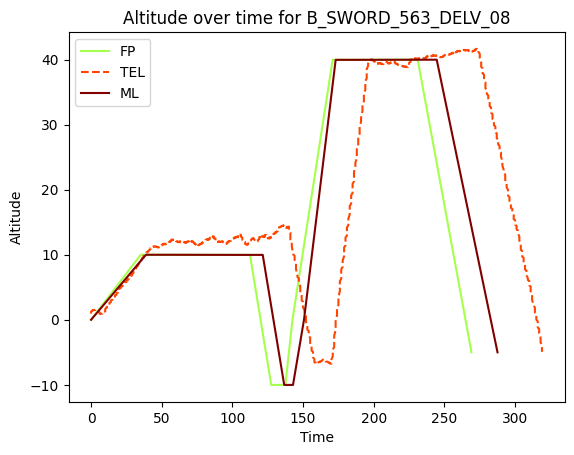

In [ ]:
telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + valname + ".csv")
flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + valname + ".csv")
lat0=flightplan['FPLlat'][0]
lon0=flightplan['FPLlon'][0]
h0=flightplan['FPLalt'][0]
sync = syncPlan(valname)
delayindex=1
t_tel_start_delay = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],delayindex))[0][0]][0]]['secs']
telemetry['secs']=telemetry['secs']-t_tel_start_delay

for i, row in telemetry.iterrows():
  telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

#plt.plot(results_df['t_tel'],general_df['y1'],label='sliced tel')

df = pd.DataFrame({'t_fp': results_df['t_fp'], 'z1': general_df['z1'],
                   't_ml': results_df['t_ml'], 'z2': general_df['z2']})
df.loc[-1] = [0, 0, 0, 0] # origins
df.index = df.index + 1
df = df.sort_index()

plt.plot(df['t_fp'], df['z1'], color='chartreuse', label='FP', alpha=0.7)
plt.plot(telemetry['secs'][(t_tel_start_delay*10).astype(int):], telemetry['z2'][(t_tel_start_delay*10).astype(int):], color='orangered', linestyle='dashed', label='TEL')
plt.plot(df['t_ml'], df['z1'], color='maroon', label='ML')

plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude over time for '+ valname)
plt.legend()
plt.show()

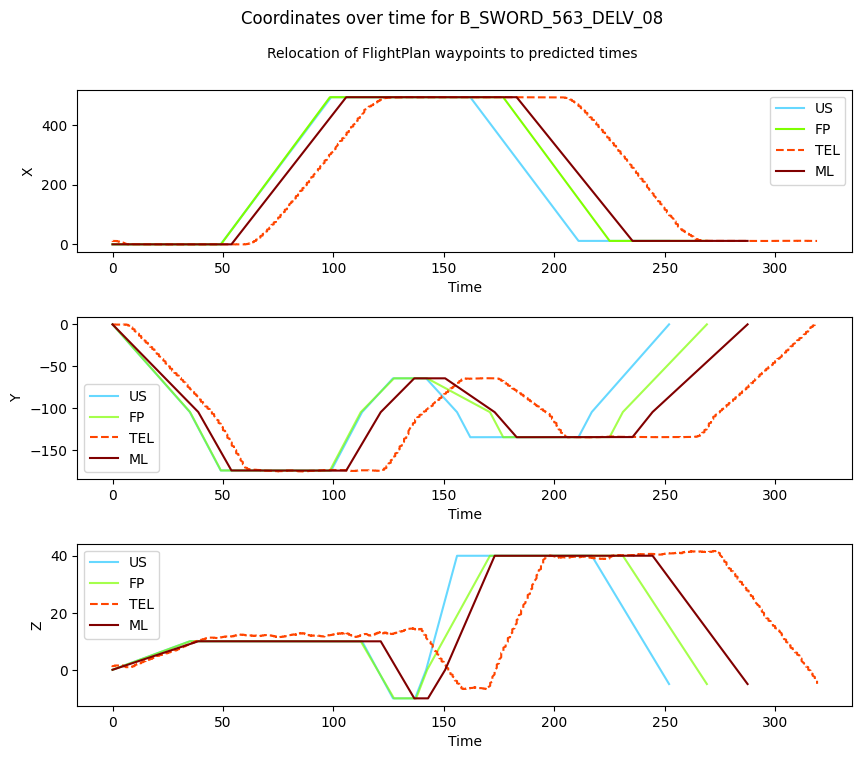

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame({'t_fp': results_df['t_fp'], 'z1': general_df['z1'],
                   't_ml': results_df['t_ml'], 'z2': general_df['z2'],
                   'x1':general_df['x1'],'x2':general_df['x2'],
                   'y1':general_df['y1'],'y2':general_df['y2'],
                   't_us':results_df['t_us']})
df.loc[-1] = [0, 0, 0, 0,0,0,0,0,0]
df.index = df.index + 1
df = df.sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

ax1.plot(df['t_us'], df['x1'], color='deepskyblue', label='US', alpha=0.6)
ax1.plot(df['t_fp'], df['x1'], color='chartreuse', label='FP', alpha=1)
ax1.plot(telemetry['secs'][(t_tel_start_delay*10).astype(int):], telemetry['x2'][(t_tel_start_delay*10).astype(int):], color='orangered', linestyle='dashed', label='TEL')
ax1.plot(df['t_ml'], df['x1'], color='maroon', label='ML')
ax1.set_xlabel('Time')
ax1.set_ylabel('X')
ax1.legend()

# y over time
ax2.plot(df['t_us'], df['y1'], color='deepskyblue', label='US', alpha=0.6)
ax2.plot(df['t_fp'], df['y1'], color='chartreuse', label='FP', alpha=0.7)
ax2.plot(telemetry['secs'][(t_tel_start_delay*10).astype(int):], telemetry['y2'][(t_tel_start_delay*10).astype(int):], color='orangered', linestyle='dashed', label='TEL')
ax2.plot(df['t_ml'], df['y1'], color='maroon', label='ML')

ax2.set_xlabel('Time')
ax2.set_ylabel('Y')
ax2.legend()

# Plot z over time
ax3.plot(df['t_us'], df['z1'], color='deepskyblue', label='US', alpha=0.6)
ax3.plot(df['t_fp'], df['z1'], color='chartreuse', label='FP', alpha=0.7)
ax3.plot(telemetry['secs'][(t_tel_start_delay*10).astype(int):], telemetry['z2'][(t_tel_start_delay*10).astype(int):], color='orangered', linestyle='dashed', label='TEL')
ax3.plot(df['t_ml'], df['z1'], color='maroon', label='ML')

ax3.set_xlabel('Time')
ax3.set_ylabel('Z')
ax3.legend()

plt.suptitle('Coordinates over time for '+ valname , fontsize=12)
fig.text(0.5, 0.92, 'Relocation of FlightPlan waypoints to predicted times', ha='center', fontsize=10)

plt.subplots_adjust(hspace=0.4)

plt.show()

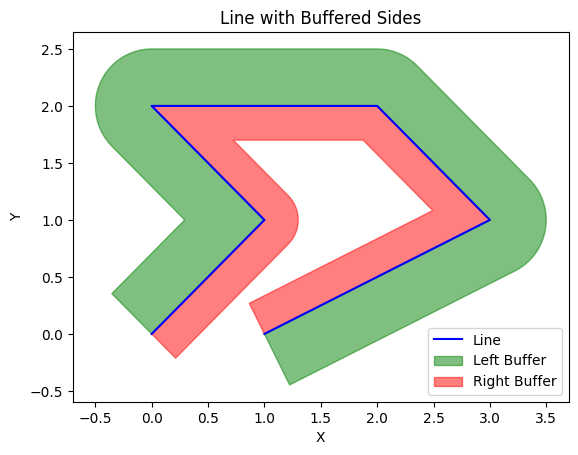

In [ ]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt

line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

left_hand_side = line.buffer(0.5, single_sided=True)

right_hand_side = line.buffer(-0.3, single_sided=True)

x_left, y_left = left_hand_side.exterior.coords.xy
x_right, y_right = right_hand_side.exterior.coords.xy

plt.plot(line.xy[0], line.xy[1], color='blue', label='Line')
plt.fill(x_left, y_left, color='green', alpha=0.5, label='Left Buffer')
plt.fill(x_right, y_right, color='red', alpha=0.5, label='Right Buffer')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line with Buffered Sides')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

validation_names = validation['ID'].tolist()
models = [rf, lr, svr, gbr, xgb, lgb, nb, logreg, knn]  # List of models to iterate through

avg_mae = {}
avg_rmse = {}
avg_r2 = {}

for model in models:
    avg_mae[model.__class__.__name__] = 0.0
    avg_rmse[model.__class__.__name__] = 0.0
    avg_r2[model.__class__.__name__] = 0.0

for valname in validation_names:
    dfvalidation =general= mlmodel_time(valname)
    real = dfvalidation[target_variable]
    dfvalidation = dfvalidation[selected_features]

    for model in models:
        y_pred = model.predict(dfvalidation)
        uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + valname + '.csv')
        uspace['t_seg_us'] = uspace['secs'].diff()
        results_df = pd.DataFrame({'t_seg_us':uspace['t_seg_us'][1:].reset_index(drop=True),'t_seg_fp': general['t_seg_fp'], 't_seg_ml': y_pred, 't_seg_tel':real.values})

        mae = mean_absolute_error(results_df['t_seg_tel'], results_df['t_seg_ml'])
        rmse = np.sqrt(mean_squared_error(results_df['t_seg_tel'], results_df['t_seg_ml']))
        r2 = r2_score(results_df['t_seg_tel'], results_df['t_seg_ml'])

        avg_mae[model.__class__.__name__] += mae
        avg_rmse[model.__class__.__name__] += rmse
        avg_r2[model.__class__.__name__] += r2

num_validations = len(validation_names)
for model in models:
    avg_mae[model.__class__.__name__] /= num_validations
    avg_rmse[model.__class__.__name__] /= num_validations
    avg_r2[model.__class__.__name__] /= num_validations

# Print average metrics
print('Average Performance Metrics across all Validations:')
for model in models:
    print('Model:', model.__class__.__name__)
    print('Average Mean Absolute Error:', avg_mae[model.__class__.__name__])
    print('Average Root Mean Squared Error:', avg_rmse[model.__class__.__name__])
    print('Average R-squared Score:', avg_r2[model.__class__.__name__])
    print('\n')


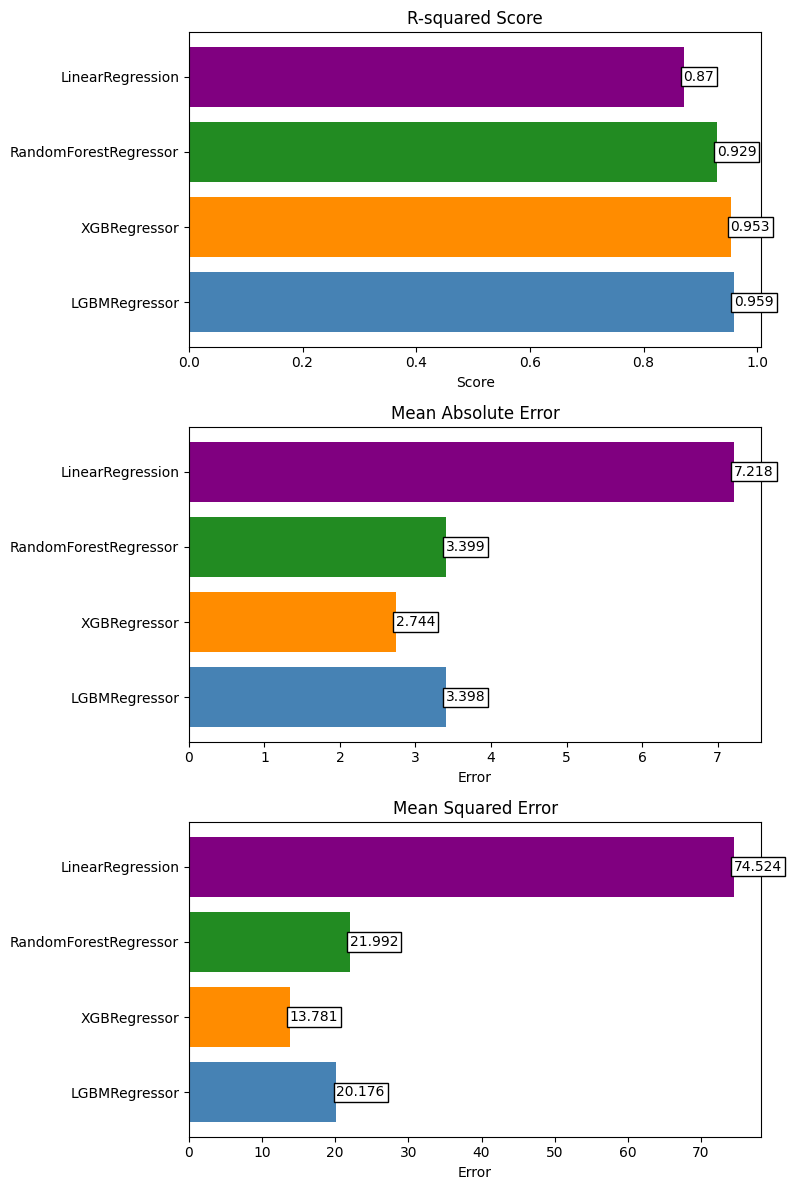

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sorted_models = sorted(models, key=lambda x: avg_r2[x.__class__.__name__], reverse=True)
top_models = sorted_models[:4]  # Select the top 4 models

r2_scores = [avg_r2[model.__class__.__name__] for model in top_models]
mae_scores = [avg_mae[model.__class__.__name__] for model in top_models]
mse_scores = [avg_rmse[model.__class__.__name__] ** 2 for model in top_models]  # Square the RMSE scores to get MSE

model_names = [model.__class__.__name__ for model in top_models]

colors = ['steelblue', 'darkorange', 'forestgreen', 'purple']

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].barh(np.arange(len(top_models)), r2_scores, color=colors)
axes[0].set_yticks(np.arange(len(top_models)))
axes[0].set_yticklabels(model_names)
axes[0].set_title('R-squared Score')
axes[0].set_xlabel('Score')

for i, v in enumerate(r2_scores):
    axes[0].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

# MAE plot
axes[1].barh(np.arange(len(top_models)), mae_scores, color=colors)
axes[1].set_yticks(np.arange(len(top_models)))
axes[1].set_yticklabels(model_names)
axes[1].set_title('Mean Absolute Error')
axes[1].set_xlabel('Error')

for i, v in enumerate(mae_scores):
    axes[1].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

# MSE plot
axes[2].barh(np.arange(len(top_models)), mse_scores, color=colors)
axes[2].set_yticks(np.arange(len(top_models)))
axes[2].set_yticklabels(model_names)
axes[2].set_title('Mean Squared Error')
axes[2].set_xlabel('Error')

for i, v in enumerate(mse_scores):
    axes[2].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

plt.tight_layout()
plt.show()


In [ ]:
plot_planVsTele(valname)
subplotPlanVsUspace(valname)

In [ ]:
telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + valname + ".csv")
fp = pd.read_csv(dataUnzip + 'FlightPlan_' + valname + ".csv")
pfval = planFixENU(valname)
for i, row in telemetry.iterrows():
  telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

Unnamed: 0      WPname           x           y          z  FPLvel  \
0            0   Waypoint1    0.000000    0.000000   0.000000     7.0   
1            1   Waypoint2   -0.062337 -130.929782   9.998653    10.0   
2            2   Waypoint3   -0.095624 -200.844605   9.996830    10.0   
3            3   Waypoint4  158.207656 -200.919397   9.994869    10.0   
4            4   Waypoint5  158.240949 -131.004574   9.996691     3.0   
5            5   Waypoint6  158.257279  -95.670870 -10.002680     0.0   
6            6    Hover10s  158.257279  -95.670870 -10.002680     2.0   
7            7   Waypoint7  158.257527  -95.671020  -0.002680     2.0   
8            8   Waypoint8  158.241692 -131.005192  39.996691    10.0   
9            9   Waypoint9  158.227424 -160.968830  39.996004    10.0   
10          10  Waypoint10   11.620728 -160.899564  39.997955    10.0   
11          11  Waypoint11   11.634994 -130.935926  39.998642     4.0   
12          12  Waypoint12   11.697261    0.017779  -5.000011     0.0   

    FPLturn           FPLwpt    timeSeg        time  
0      65.0  CurvaturePassed   0.000000    0.000000  
1      34.0  CurvaturePassed  18.758718   18.758718  
2      34.0  CurvaturePassed   6.991483   25.750201  
3      34.0  CurvaturePassed  15.830330   41.580530  
4      17.0  CurvaturePassed   6.991483   48.572013  
5       0.2         LineStop  13.533685   62.105699  
6       0.2         LineStop  10.000000   72.105699  
7       0.2  CurvaturePassed   5.000000   77.105699  
8      14.0  CurvaturePassed  26.685453  103.791152  
9      14.0  CurvaturePassed   2.996364  106.787516  
10     14.0  CurvaturePassed  14.660671  121.448187  
11     14.0  CurvaturePassed   2.996364  124.444551  
12     65.0  CurvaturePassed  34.617333  159.061884

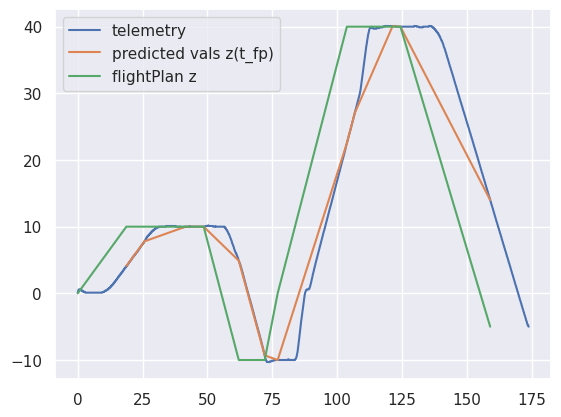

In [ ]:
plt.plot(telemetry['secs'],telemetry['z2'], label='telemetry')
plt.plot(pfval['time'][1:],y_pred[:,3], label='predicted vals z(t_fp)')
plt.plot(pfval['time'],pfval['z'], label='flightPlan z')

plt.legend()


In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_xgb_train_pred, c="#7CAE00" ,alpha=0.3)
plt.scatter(x=y_test, y=y_xgb_test_pred, c="#7CAE00" ,alpha=0.3)


z = np.polyfit(y_train, y_xgb_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_xgb_train_pred), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')
plt.title('Telemetry time prediction')

poly1d([0.98347514, 2.41662396])

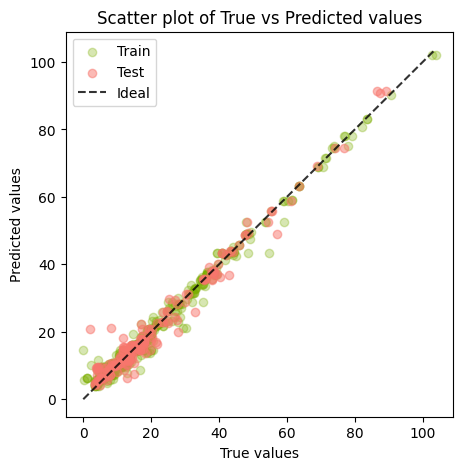

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_xgb_train_pred, c="#7CAE00", alpha=0.3, label="Train")
plt.scatter(y_test, y_xgb_test_pred, c="#F8766D", alpha=0.5, label="Test")

plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 'k--', label="Ideal", alpha=0.8)

plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of True vs Predicted values')
plt.legend()
plt.show()




---



# ML2 - predict dx, dy, dz (Segments)


In [ ]:
def mlmodel_time(name):
  #name='A_JUNO_142_DELV_06'
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")
  pf=planFixENU(name)
  segmentType = definePlanSegment(df_flightPlan)
  droneModel = defineDroneModel(name)
  droneOperator = definePlanOperator(name)
  pf = pf.rename(columns={'time': 't_fp', 'timeSeg': 't_seg_fp','x':'x0','y':'y0','z':'z0','FPLvel':'vel_fp','FPLturn':'turn_fp'})

  # find t_tel. We want the telemetry time at the end of each segment -> syncPlan()
  telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + name + ".csv")
  sync = syncPlan(name)
  fpi = planInfoENU(name)

  delayindex=1
  t_tel_start_delay = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],delayindex))[0][0]][0]]['secs']
  telemetry['secs']=telemetry['secs']-t_tel_start_delay
  #telemetry=telemetry[(t_tel_start_delay*10).astype('int'):].reset_index(drop=True)
  #crop_index = (t_tel_start_delay*10).astype('int')
  #cropped_data = sync[crop_index:]
  #sync = [(x[0] - sync[crop_index][0], x[1] - sync[crop_index][1]) for x in cropped_data]

  for (i, original), (j, shift) in zip(pf.iloc[:-1].iterrows(), pf.iloc[1:].iterrows()):
    pf.at[i,'x1'] = shift['x0']
    pf.at[i,'y1'] = shift['y0']
    pf.at[i,'z1'] = shift['z0']
    pf.at[i,'t_seg_fp'] = shift['t_seg_fp']
    pf.at[i,'t_fp'] = shift['t_fp']

  pf=pf[:-1]
  for i, row in pf.iterrows():
    pf.loc[i, "t_tel"] = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],(i+1)*50))[0][0]][0]]['secs']
    pf.loc[i, "segId"] = i
  ### one hot encoding
  pf['JUNO']=0
  pf['OMAHA']=0
  pf['UTAH']=0
  pf['SWORD']=0
  if droneOperator == 'JUNO':
    pf['JUNO']=1
  if droneOperator == 'OMAHA':
    pf['OMAHA']=1
  if droneOperator == 'UTAH':
    pf['UTAH']=1
  if droneOperator == 'SWORD':
    pf['SWORD']=1

  pf['M300']=0
  pf['M600']=0
  pf['Mavic2']=0
  pf['S9000']=0
  if droneOperator == '0':
    pf['M300']=1
  if droneOperator == '1':
    pf['M600']=1
  if droneOperator == '2':
    pf['Mavic2']=1
  if droneOperator == '3':
    pf['s9000']=1

  pf['climb']=0
  pf['cruise']=0
  pf['descent']=0
  pf['hover']=0
  for i, row in pf.iterrows():
    if segmentType[i] == 'Climb':
      pf.loc[i, "climb"] = 1
    if segmentType[i] == 'Cruise':
      pf.loc[i, "cruise"] = 1
    if segmentType[i] == 'Descent':
      pf.loc[i, "descent"] = 1
    if segmentType[i] == 'Hover':
      pf.loc[i, "hover"] = 1
  ### end of one hot encoding

  pf['3Ddist']=fpi['3Ddist']
  pf['2Ddist']=fpi['2Ddist']
  pf['2Dtime']=fpi['time2D']

  lat0,lon0,h0=[df_flightPlan.loc[0,'FPLlat'],df_flightPlan.loc[0,'FPLlon'],df_flightPlan.loc[0,'FPLalt']]
  for i, row in telemetry.iterrows():
    telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
  telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

  for i, row in pf.iterrows():
    close_tel = find_nearest(telemetry['secs'].values,row['t_fp'])
    pf.at[i, 'x2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'x2'].iloc[0])
    pf.at[i, 'y2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'y2'].iloc[0])
    pf.at[i, 'z2'] = (telemetry.loc[telemetry['secs'] == close_tel, 'z2'].iloc[0])
    pf.at[i, 'x3'] = row['x1'] -row['x0']
    pf.at[i, 'y3'] = row['y1'] -row['y0']
    pf.at[i, 'z3'] = row['z1'] -row['z0']
  for i, row in pf.iterrows():
    pf.at[i, 'dx'] = row['x2'] -row['x1']
    pf.at[i, 'dy'] = row['y2'] -row['y1']
    pf.at[i, 'dz'] = row['z2'] -row['z1']

  hoverindex = pf.loc[(pf.x3 ==0) & (pf.y3 == 0) & (pf.z3 == 0)].index.values
  t_tel_hover_start = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],((hoverindex)*50)-2))[0][0]][0]]['secs']
  t_tel_hover_end = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],((hoverindex+1)*50)+2))[0][0]][0]]['secs']
  pf.at[hoverindex[0]-1, 't_tel'] = t_tel_hover_start
  pf.at[hoverindex[0], 't_tel'] = t_tel_hover_end
  pf['t_seg_tel']=pf['t_tel'].diff()
  pf.loc[0, "t_seg_tel"] = pf.loc[0, "t_tel"]
  return pf


In [ ]:
mlmodel_time('A_JUNO_142_DELV_06')

In [ ]:
'''
dataset0 = pd.DataFrame({'ID': fileName})
#
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
print(dataset0.loc[dataset0['maxError']>=20])
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

validation=dataset0[-6:].reset_index(drop=True)
dataset0=dataset0[:-6] ## except the last ones, to try an unseen fligth
'''
dataset0 = pd.DataFrame({'ID': fileName})
dataset0['avgError']=dataset0.apply(lambda x: computeAvgError(x['ID'])[0], axis=1)
print(dataset0.loc[dataset0['avgError']>=8.5])
dataset0.drop(dataset0.loc[dataset0['avgError']>=8.5].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

# List of IDs to extract
ids_to_extract = ['A_OMAHA_371_DELV_06', 'A_UTAH_183_DELV_03', 'A_OMAHA_170_DELV_01', 'B_SWORD_563_DELV_08','B_JUNO_1422_DELV_10']

# Create a new dataframe to store the extracted rows
validation = dataset0[dataset0['ID'].isin(ids_to_extract)].reset_index(drop=True)

# Remove the extracted rows from the original dataframe
dataset0 = dataset0[~dataset0['ID'].isin(ids_to_extract)].reset_index(drop=True)


In [ ]:
dataset = pd.DataFrame()
for ind, row in dataset0.iterrows():
  model = mlmodel_time(row['ID'])
  model['id'] = ind
  dataset = pd.concat([dataset, model])
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(dataset[dataset['t_tel'] < 0.8].index)

dataset.head(2)
dataset.columns

Index(['Unnamed: 0', 'WPname', 'x0', 'y0', 'z0', 'vel_fp', 'turn_fp', 'FPLwpt',
       't_seg_fp', 't_fp', 'x1', 'y1', 'z1', 't_tel', 'segId', 'JUNO', 'OMAHA',
       'UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise',
       'descent', 'hover', '3Ddist', '2Ddist', '2Dtime', 'x2', 'y2', 'z2',
       'x3', 'y3', 'z3', 'dx', 'dy', 'dz', 't_seg_tel', 'id'],
      dtype='object')

In [ ]:
''' UNORDERDED '''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#selected_features = ['segId', 'JUNO', 'OMAHA','UTAH', 'SWORD', 'M300', 'M600', 'Mavic2', 'S9000', 'climb', 'cruise','descent', 'hover','x0', 'y0', 'z0', 'x1','y1','z1', 'vel_fp', 'turn_fp', 't_fp','3Ddist','2Ddist','2Dtime','t_tel']
selected_features = ['JUNO', 'OMAHA','UTAH', 'SWORD','x3','y3','z3', 'vel_fp', 'turn_fp','3Ddist' ,'t_seg_fp','2Ddist', 'climb', 'cruise','descent', 'hover']

target_variable = ['dx','dy','dz']
X = dataset[selected_features]
y = dataset[target_variable]
X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(max_depth=24)

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
print("Model Score:", score)
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


Model Score: 0.4657539826147609
Mean Squared Error (MSE): 2305.8301560467144
Mean Absolute Error (MAE): 18.23251610101797


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np

models = [rf, lr, svr, gbr, xgb, lgb, knn]
results_df = pd.DataFrame(columns=['Model', 'Mean CV Score'])

for model in models:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_score = np.mean(cv_scores)

    results_df = results_df.append({'Model': type(model).__name__, 'Mean CV Score': mean_score}, ignore_index=True)

results_df = results_df.sort_values(by='Mean CV Score', ascending=False).reset_index(drop=True)
(results_df)


In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train,y_train)
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_mae, rf_train_r2, rf_test_mse, rf_test_mae, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# linear
from sklearn.linear_model import LinearRegression, LogisticRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_mae, lr_train_r2, lr_test_mse, lr_test_mae, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
'''
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(kernel='poly', C=1.0, epsilon=0.05)
svr.fit(X_train, y_train)
y_svr_train_pred = svr.predict(X_train)
y_svr_test_pred = svr.predict(X_test)

svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_mae = mean_absolute_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)
svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_mae = mean_absolute_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)
svr_results = pd.DataFrame(['Support Vector Regression', svr_train_mse, svr_train_mae, svr_train_r2, svr_test_mse, svr_test_mae, svr_test_r2]).transpose()
svr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=5
)
gbr.fit(X_train, y_train)
y_gbr_train_pred = gbr.predict(X_train)
y_gbr_test_pred = gbr.predict(X_test)

gbr_train_mse = mean_squared_error(y_train, y_gbr_train_pred)
gbr_train_mae = mean_absolute_error(y_train, y_gbr_train_pred)
gbr_train_r2 = r2_score(y_train, y_gbr_train_pred)
gbr_test_mse = mean_squared_error(y_test, y_gbr_test_pred)
gbr_test_mae = mean_absolute_error(y_test, y_gbr_test_pred)
gbr_test_r2 = r2_score(y_test, y_gbr_test_pred)
gbr_results = pd.DataFrame(['Gradient Boosting Regressor', gbr_train_mse, gbr_train_mae, gbr_train_r2, gbr_test_mse, gbr_test_mae, gbr_test_r2]).transpose()
gbr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
'''
# XGB
import xgboost as xgb
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.08,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_xgb_train_pred = xgb.predict(X_train)
y_xgb_test_pred = xgb.predict(X_test)

xgb_train_mse = mean_squared_error(y_train, y_xgb_train_pred)
xgb_train_mae = mean_absolute_error(y_train, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train, y_xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_mae = mean_absolute_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)
xgb_results = pd.DataFrame(['Extreme Gradient Boosting', xgb_train_mse, xgb_train_mae, xgb_train_r2, xgb_test_mse, xgb_test_mae, xgb_test_r2]).transpose()
xgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
'''
# LGB
import lightgbm as lgb
lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4
)
lgb.fit(X_train, y_train)
y_lgb_train_pred = lgb.predict(X_train)
y_lgb_test_pred = lgb.predict(X_test)

lgb_train_mse = mean_squared_error(y_train, y_lgb_train_pred)
lgb_train_mae = mean_absolute_error(y_train, y_lgb_train_pred)
lgb_train_r2 = r2_score(y_train, y_lgb_train_pred)
lgb_test_mse = mean_squared_error(y_test, y_lgb_test_pred)
lgb_test_mae = mean_absolute_error(y_test, y_lgb_test_pred)
lgb_test_r2 = r2_score(y_test, y_lgb_test_pred)
lgb_results = pd.DataFrame(['Light Gradient Boosting', lgb_train_mse, lgb_train_mae, lgb_train_r2, lgb_test_mse, lgb_test_mae, lgb_test_r2]).transpose()
lgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train.astype('int'))
y_nb_train_pred = nb.predict(X_train)
y_nb_test_pred = nb.predict(X_test)

nb_train_mse = mean_squared_error(y_train, y_nb_train_pred)
nb_train_mae = mean_absolute_error(y_train, y_nb_train_pred)
nb_train_r2 = r2_score(y_train, y_nb_train_pred)
nb_test_mse = mean_squared_error(y_test, y_nb_test_pred)
nb_test_mae = mean_absolute_error(y_test, y_nb_test_pred)
nb_test_r2 = r2_score(y_test, y_nb_test_pred)
nb_results = pd.DataFrame(['Naive Bayes', nb_train_mse, nb_train_mae, nb_train_r2, nb_test_mse, nb_test_mae, nb_test_r2]).transpose()
nb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train.astype('int'))
y_logreg_train_pred = logreg.predict(X_train)
y_logreg_test_pred = logreg.predict(X_test)

logreg_train_mse = mean_squared_error(y_train, y_logreg_train_pred)
logreg_train_mae = mean_absolute_error(y_train, y_logreg_train_pred)
logreg_train_r2 = r2_score(y_train, y_logreg_train_pred)
logreg_test_mse = mean_squared_error(y_test, y_logreg_test_pred)
logreg_test_mae = mean_absolute_error(y_test, y_logreg_test_pred)
logreg_test_r2 = r2_score(y_test, y_logreg_test_pred)
logreg_results = pd.DataFrame(['Logistic Regression', logreg_train_mse, logreg_train_mae, logreg_train_r2, logreg_test_mse, logreg_test_mae, logreg_test_r2]).transpose()
logreg_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
'''

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_knn_train_pred = knn.predict(X_train)
y_knn_test_pred = knn.predict(X_test)

knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_mae = mean_absolute_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_mae = mean_absolute_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
knn_results = pd.DataFrame(['K-Nearest Neighbors', knn_train_mse, knn_train_mae, knn_train_r2, knn_test_mse, knn_test_mae, knn_test_r2]).transpose()
knn_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']

# Putting it all together
#results = pd.concat([rf_results, lr_results, svr_results, gbr_results, xgb_results, lgb_results, nb_results, logreg_results, knn_results], ignore_index=True)
results = pd.concat([rf_results, lr_results, xgb_results, knn_results], ignore_index=True)

results = results.sort_values('Test R2', ascending=False).reset_index(drop=True)
results


Method Training MSE Training MAE Training R2  \
0              Random forest   547.040426     9.652524    0.695739   
1  Extreme Gradient Boosting   610.698858     11.27271    0.669602   
2        K-Nearest Neighbors   987.749351    14.638424    0.504407   
3          Linear regression  1689.559409    20.745716    0.192929   

      Test MSE   Test MAE   Test R2  
0  2347.607407  18.483357  0.466371  
1  2527.688765  19.717998  0.442002  
2   2404.65631  20.558416  0.388015  
3  3819.406663  25.548813  0.162451

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 4, 6]
}

rf = RandomForestRegressor(random_state=100)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf = RandomForestRegressor(max_depth=best_params['max_depth'],
                                n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                random_state=100)
best_rf.fit(X_train, y_train)

y_rf_train_pred = best_rf.predict(X_train)
y_rf_test_pred = best_rf.predict(X_test)


Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 100}


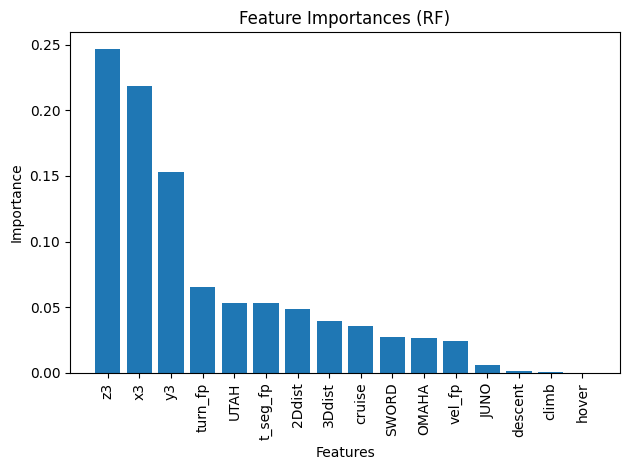

In [ ]:
importances = rf.feature_importances_
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

feature_names = X.columns[sorted_indices]
plt.bar(range(len(importances)), sorted_importances, tick_label=feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (RF)')
plt.tight_layout()
plt.show()

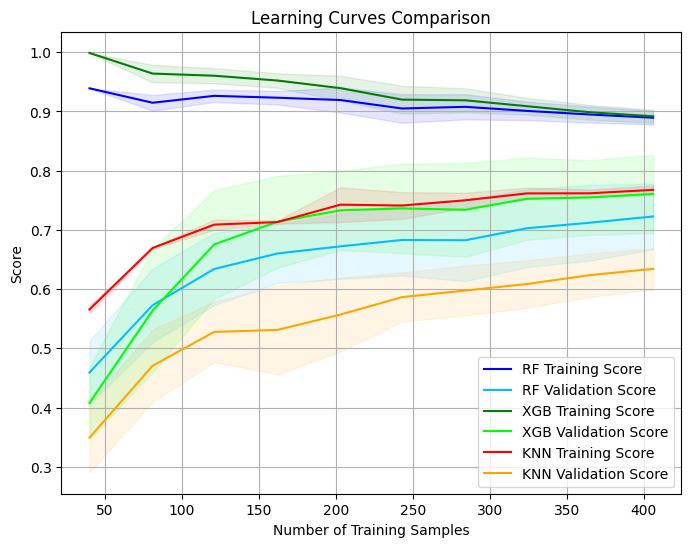

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming you have the trained models stored in 'model1' and 'model2' and the training data in 'X_train' and 'y_train'

# Define the number of training samples at which to evaluate the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curves for both models
train_sizes_abs, train_scores1, test_scores1 = learning_curve(rf, X_train, y_train, train_sizes=train_sizes)
train_sizes_abs, train_scores2, test_scores2 = learning_curve(xgb, X_train, y_train, train_sizes=train_sizes)
train_sizes_abs, train_scores3, test_scores3 = learning_curve(knn, X_train, y_train, train_sizes=train_sizes)

# Compute the mean and standard deviation of the training and test scores
train_scores_mean1 = np.mean(train_scores1, axis=1)
train_scores_std1 = np.std(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)
test_scores_std1 = np.std(test_scores1, axis=1)

train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

train_scores_mean3 = np.mean(train_scores3, axis=1)
train_scores_std3 = np.std(train_scores3, axis=1)
test_scores_mean3 = np.mean(test_scores3, axis=1)
test_scores_std3 = np.std(test_scores3, axis=1)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_scores_mean1, label='RF Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean1 - train_scores_std1, train_scores_mean1 + train_scores_std1, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, test_scores_mean1, label='RF Validation Score', color='deepskyblue')
plt.fill_between(train_sizes_abs, test_scores_mean1 - test_scores_std1, test_scores_mean1 + test_scores_std1, alpha=0.1, color='deepskyblue')

plt.plot(train_sizes_abs, train_scores_mean2, label='XGB Training Score', color='green')
plt.fill_between(train_sizes_abs, train_scores_mean2 - train_scores_std2, train_scores_mean2 + train_scores_std2, alpha=0.1, color='green')
plt.plot(train_sizes_abs, test_scores_mean2, label='XGB Validation Score', color='lime')
plt.fill_between(train_sizes_abs, test_scores_mean2 - test_scores_std2, test_scores_mean2 + test_scores_std2, alpha=0.1, color='lime')

plt.plot(train_sizes_abs, train_scores_mean3, label='KNN Training Score', color='red')
plt.fill_between(train_sizes_abs, train_scores_mean3 - train_scores_std3, train_scores_mean3 + train_scores_std3, alpha=0.1, color='red')
plt.plot(train_sizes_abs, test_scores_mean3, label='KNN Validation Score', color='orange')
plt.fill_between(train_sizes_abs, test_scores_mean3 - test_scores_std3, test_scores_mean3 + test_scores_std3, alpha=0.1, color='orange')

plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.title('Learning Curves Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

validation_names = validation['ID'].tolist()
models = [rf, lr, svr, gbr, xgb, lgb, nb, logreg, knn]  # List of models to iterate through

avg_mae = {}
avg_rmse = {}
avg_r2 = {}

for model in models:
    avg_mae[model.__class__.__name__] = 0.0
    avg_rmse[model.__class__.__name__] = 0.0
    avg_r2[model.__class__.__name__] = 0.0

for valname in validation_names:
    dfvalidation =general= mlmodel_time(valname)
    real = dfvalidation[target_variable]
    dfvalidation = dfvalidation[selected_features]

    for model in models:
        y_pred = model.predict(dfvalidation)

        uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + valname + '.csv')
        uspace['t_seg_us'] = uspace['secs'].diff()
        results_df = pd.DataFrame({'t_seg_us':uspace['t_seg_us'][1:].reset_index(drop=True),'t_seg_fp': general['t_seg_fp'], 't_seg_ml': y_pred, 't_seg_tel':real.values})

        mae = mean_absolute_error(results_df['t_seg_tel'], results_df['t_seg_ml'])
        rmse = np.sqrt(mean_squared_error(results_df['t_seg_tel'], results_df['t_seg_ml']))
        r2 = r2_score(results_df['t_seg_tel'], results_df['t_seg_ml'])
        avg_mae[model.__class__.__name__] += mae
        avg_rmse[model.__class__.__name__] += rmse
        avg_r2[model.__class__.__name__] += r2

num_validations = len(validation_names)
for model in models:
    avg_mae[model.__class__.__name__] /= num_validations
    avg_rmse[model.__class__.__name__] /= num_validations
    avg_r2[model.__class__.__name__] /= num_validations


import matplotlib.pyplot as plt
import numpy as np

sorted_models = sorted(models, key=lambda x: avg_r2[x.__class__.__name__], reverse=True)
top_models = sorted_models[:4]  # Select the top 4 models
r2_scores = [avg_r2[model.__class__.__name__] for model in top_models]
mae_scores = [avg_mae[model.__class__.__name__] for model in top_models]
mse_scores = [avg_rmse[model.__class__.__name__] ** 2 for model in top_models]  # Square the RMSE scores to get MSE
model_names = [model.__class__.__name__ for model in top_models]
colors = ['steelblue', 'darkorange', 'forestgreen', 'purple']

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].barh(np.arange(len(top_models)), r2_scores, color=colors)
axes[0].set_yticks(np.arange(len(top_models)))
axes[0].set_yticklabels(model_names)
axes[0].set_title('R-squared Score')
axes[0].set_xlabel('Score')

for i, v in enumerate(r2_scores):
    axes[0].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

# MAE plot
axes[1].barh(np.arange(len(top_models)), mae_scores, color=colors)
axes[1].set_yticks(np.arange(len(top_models)))
axes[1].set_yticklabels(model_names)
axes[1].set_title('Mean Absolute Error')
axes[1].set_xlabel('Error')

for i, v in enumerate(mae_scores):
    axes[1].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

# MSE plot
axes[2].barh(np.arange(len(top_models)), mse_scores, color=colors)
axes[2].set_yticks(np.arange(len(top_models)))
axes[2].set_yticklabels(model_names)
axes[2].set_title('Mean Squared Error')
axes[2].set_xlabel('Error')

for i, v in enumerate(mse_scores):
    axes[2].text(v, i, str(round(v, 3)), va='center', ha='left', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=2))

plt.tight_layout()
plt.show()


ValueError: ignored

(12, 17)
MSE for x2: 409.743393148721


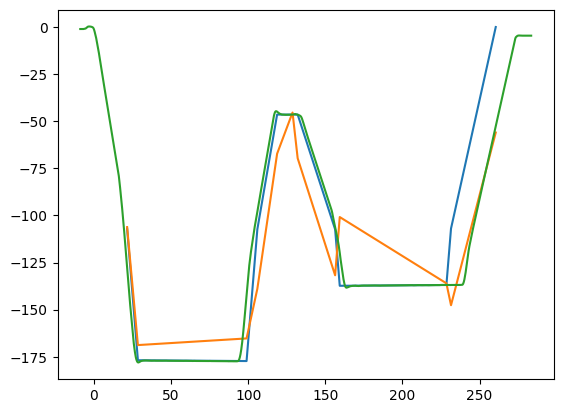

In [ ]:
''' VALIDATION '''
valname = validation.loc[4,'ID']
dfvalidation = general_df = mlmodel_time(valname)
real = dfvalidation[target_variable]
dfvalidation = dfvalidation[selected_features]
print(dfvalidation.shape)
# Use the trained model to make predictions
y_pred = lgb.predict(dfvalidation)

# Alternatively, create a new dataframe with the predicted values
uspace = pd.read_csv(dataUnzip + 'UsPrediction_' + valname + '.csv')
uspace['t_seg_us'] = uspace['secs'].diff()


plt.plot(general_df['t_fp'],general_df['y1'])
plt.plot(general_df['t_fp'],general_df['y1']+y_pred)

telemetry = pd.read_csv(dataUnzip + 'Telemetry_' + valname + ".csv")
flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + valname + ".csv")
lat0=flightplan['FPLlat'][0]
lon0=flightplan['FPLlon'][0]
h0=flightplan['FPLalt'][0]
sync = syncPlan(valname)
delayindex=1
t_tel_start_delay = telemetry.iloc[sync[np.where(np.array(sync)[:,1] == find_nearest(np.array(sync)[:,1],delayindex))[0][0]][0]]['secs']
telemetry['secs']=telemetry['secs']-t_tel_start_delay

for i, row in telemetry.iterrows():
  telemetry.at[i,'lat'],telemetry.at[i,'lon'],telemetry.at[i,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)
telemetry = telemetry.rename(columns={'lat': 'x2', 'lon': 'y2', 'alt':'z2'})

plt.plot(telemetry['secs'],telemetry['y2'])

'''
plt.figure()
results_df = pd.DataFrame({'t_seg_us':uspace['t_seg_us'][1:].reset_index(drop=True),'t_seg_fp': general_df['t_seg_fp'], 't_seg_ml': y_pred, 't_seg_tel':real.values})
plt.plot(results_df['t_seg_us'], c='deepskyblue', label='t_seg_us',  alpha=0.8)
plt.plot(results_df['t_seg_fp'], c='chartreuse', label='t_seg_fp',  alpha=0.8)
plt.plot(results_df['t_seg_ml'], c='maroon', label='t_seg_ml')
plt.plot(results_df['t_seg_tel'], c='orangered', label='t_seg_tel')
plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Segment times for '+ valname)
plt.legend()

results_df['t_us'] = results_df['t_seg_us'].cumsum()
results_df['t_fp'] = results_df['t_seg_fp'].cumsum()
results_df['t_ml'] = results_df['t_seg_ml'].cumsum()
results_df['t_tel'] = results_df['t_seg_tel'].cumsum()
# Calculate the cumulative sum of the columns
plt.figure()

# Rename the columns
plt.plot(results_df['t_us'], c='deepskyblue', label='t_us',  alpha=0.8)
plt.plot(results_df['t_fp'], c='chartreuse', label='t_fp',  alpha=0.8)
plt.plot(results_df['t_ml'], c='maroon', label='t_ml')
plt.plot(results_df['t_tel'], c='orangered', label='t_tel')

plt.xlabel('Segment index')
plt.ylabel('Seconds')
plt.title('Global times for '+ valname)
plt.legend()
'''
mse_x2 = mean_squared_error(y_pred, real)


print("MSE for x2:", mse_x2)



# New model test

In [ ]:
pm = extendedPlan('A_JUNO_142_DELV_06',1)
pm.head()

dronemodel  segId  type          x0          y0          z0          x1  \
0           0    0.0   0.0         0.0         0.0         0.0   93.815988   
1           0    1.0   1.0   93.815988    3.179164  -91.820684  139.900295   
2           0    2.0   1.0  139.900295    4.738166 -144.374368  134.481675   
3           0    3.0   1.0  134.481675  162.948688 -144.431881   88.397368   
4           0    4.0   2.0   88.397368  161.389692  -91.878197   50.082657   

           y1          z1  FPLvel  FPLturn       time  e_horizontal  \
0    3.179164  -91.820684     7.0     65.0  18.758718     38.249360   
1    4.738166 -144.374368    10.0     34.0  25.750201     20.620090   
2  162.948688 -144.431881    10.0     34.0  41.580530     62.826232   
3  161.389692  -91.878197    10.0     34.0  48.572013     25.688155   
4  160.082178  -78.509611     3.0     17.0  62.105699      9.444319   

     e_along    e_cross  
0  38.249346  -0.032929  
1 -20.620078  -0.021683  
2  62.826177   0.082674  
3   0.067943 -25.688066  
4   9.444122   0.061129

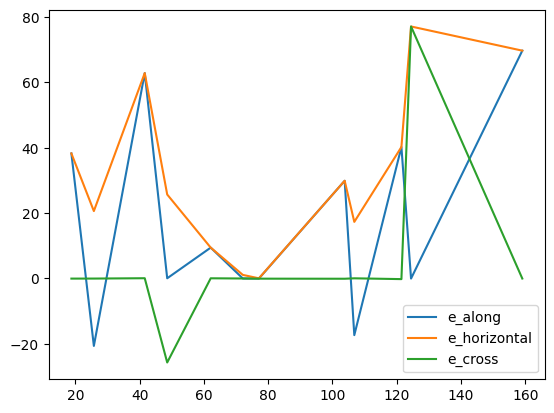

In [ ]:
plt.plot(pm['time'],pm['e_along'], label='e_along')
plt.plot(pm['time'],pm['e_horizontal'],label='e_horizontal')
plt.plot(pm['time'],pm['e_cross'], label='e_cross')
plt.legend()

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})[:-4] ## except the last one, to try an unseen fligth
dataset0['maxError']=dataset0.apply(lambda x: computeMaxError(x['ID']), axis=1)
dataset0.drop(dataset0.loc[dataset0['maxError']>=20].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

In [ ]:
dataset = pd.DataFrame()
n=4
for ind, row in dataset0.iterrows():
  model = extendedPlan(row['ID'],n)
  error = model.loc[model['e_horizontal']>=300]
  if len(error) == 0:
    dataset = pd.concat([dataset, model])

dataset = dataset.reset_index(drop=True)
#dataset.loc[dataset['e_horizontal']>=600].index
#plt.plot(dataset.reset_index(drop=True)['e_cross'])
dataset.head(2)

dronemodel  segId  type          x0         y0         z0         x1  \
0              1    0.0   1.0         0.0        0.0        0.0  84.888381   
1              1    0.0   1.0         0.0        0.0        0.0  84.888381   
2              1    0.0   1.0         0.0        0.0        0.0  84.888381   
3              1    0.0   1.0         0.0        0.0        0.0  84.888381   
4              1    1.0   1.0   84.888381    2.87162 -96.802687  91.836243   
...          ...    ...   ...         ...        ...        ...        ...   
1803           0    9.0   1.0  139.500006  16.428591 -144.37853  93.415699   
1804           0   10.0   2.0   93.415699   14.86959 -91.824846  -4.171731   
1805           0   10.0   2.0   93.415699   14.86959 -91.824846  -4.171731   
1806           0   10.0   2.0   93.415699   14.86959 -91.824846  -4.171731   
1807           0   10.0   2.0   93.415699   14.86959 -91.824846  -4.171731   

              y1         z1  FPLvel  FPLturn        time  e_horizontal  \
0       2.871620 -96.802687     5.0     64.0    6.439147      0.830448   
1       2.871620 -96.802687     5.0     64.0   12.878293     18.128735   
2       2.871620 -96.802687     5.0     64.0   19.317440     59.737554   
3       2.871620 -96.802687     5.0     64.0   25.756586     84.569339   
4    -199.092481 -96.702522    10.0     64.0   30.808676      3.580725   
...          ...        ...     ...      ...         ...           ...   
1803   14.869590 -91.824846     5.0     34.0  127.529966     25.724463   
1804   11.560099  -3.284372     3.0     34.0  138.514069      2.234863   
1805   11.560099  -3.284372     3.0     34.0  149.498172     26.057123   
1806   11.560099  -3.284372     3.0     34.0  160.482275     50.413038   
1807   11.560099  -3.284372     3.0     34.0  171.466378     74.847232   

        e_along   e_cross  
0      0.571373  0.602641  
1     18.123821  0.422087  
2     59.737159 -0.217226  
3     84.569266 -0.111665  
4      3.530862  0.595488  
...         ...       ...  
1803  25.724281  0.096725  
1804   2.233827  0.068035  
1805  26.057121  0.008758  
1806  50.413036 -0.012913  
1807  74.847215  0.051221  

[1808 rows x 15 columns]

In [ ]:
datasetcopy = dataset
1808/4

452.0

In [ ]:
y = datasetcopy[['e_horizontal','e_along','e_cross']]
#y = datasetcopy[['e_horizontal']]

y.head()

e_horizontal    e_along   e_cross
0      0.830448   0.571373  0.602641
1     18.128735  18.123821  0.422087
2     59.737554  59.737159 -0.217226
3     84.569339  84.569266 -0.111665
4      3.580725   3.530862  0.595488

In [ ]:
X = datasetcopy.drop(y.columns, axis=1)
#X=X.drop(['time','e_along','e_cross'], axis=1)

X.head(3)

dronemodel  segId  type   x0   y0   z0         x1       y1         z1  \
0           1    0.0   1.0  0.0  0.0  0.0  84.888381  2.87162 -96.802687   
1           1    0.0   1.0  0.0  0.0  0.0  84.888381  2.87162 -96.802687   
2           1    0.0   1.0  0.0  0.0  0.0  84.888381  2.87162 -96.802687   

   FPLvel  FPLturn       time  
0     5.0     64.0   6.439147  
1     5.0     64.0  12.878293  
2     5.0     64.0  19.317440

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.shape, X_test.shape


NameError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [ ]:
print('LR MSE (Train): ', lr_train_mse)
print('LR R2 (Train): ', lr_train_r2)
print('LR MSE (Test): ', lr_test_mse)
print('LR R2 (Test): ', lr_test_r2)

LR MSE (Train):  2798.8137858820705
LR R2 (Train):  0.2051204959033133
LR MSE (Test):  2465.219183580288
LR R2 (Test):  0.19016190056626717


In [ ]:
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
lr_results

Method Training MSE Training R2     Test MSE   Test R2
0  Linear regression  2798.813786     0.20512  2465.219184  0.190162

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=24, random_state=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=24, random_state=100)

In [ ]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

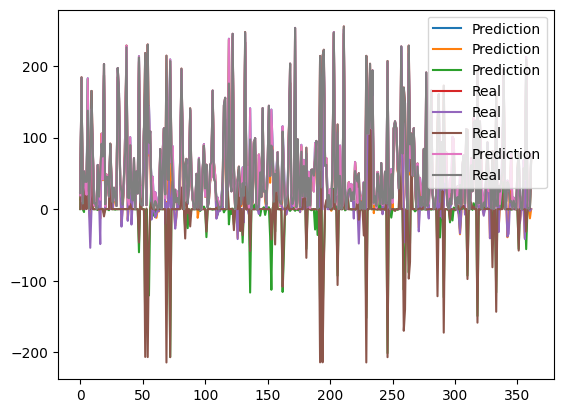

In [ ]:
plt.plot(y_rf_test_pred, label='Prediction' )
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.legend()

plt.plot(y_rf_test_pred[:,0], label='Prediction' )
plt.plot(y_test['e_horizontal'].reset_index(drop=True), label='Real')
plt.legend()


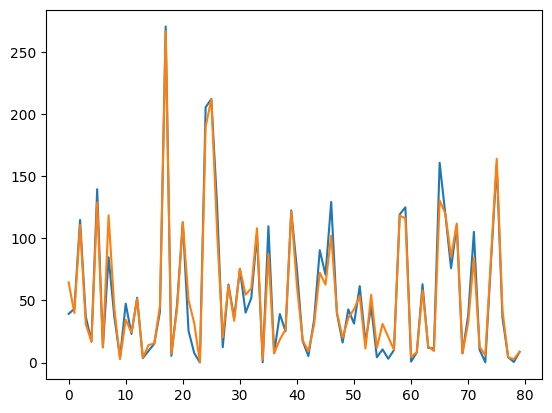

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

plt.plot(y_train['e_horizontal'].reset_index(drop=True)[:80])
plt.plot(y_rf_train_pred[:,0][:80])
mean_squared_error(y_train['e_horizontal'].reset_index(drop=True), y_rf_train_pred[:,0])
mean_squared_error(y_train['e_along'].reset_index(drop=True), y_rf_train_pred[:,1])
mean_squared_error(y_train['e_cross'].reset_index(drop=True), y_rf_train_pred[:,2])

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [ ]:
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
rf_results

Method Training MSE Training R2    Test MSE   Test R2
0  Random forest    68.085902    0.981464  349.405569  0.886024

In [ ]:
df_models = pd.concat([lr_results, rf_results], axis=0)
df_models

Method Training MSE Training R2     Test MSE   Test R2
0  Linear regression  2798.813786     0.20512  2465.219184  0.190162
0      Random forest    68.085902    0.981464   349.405569  0.886024

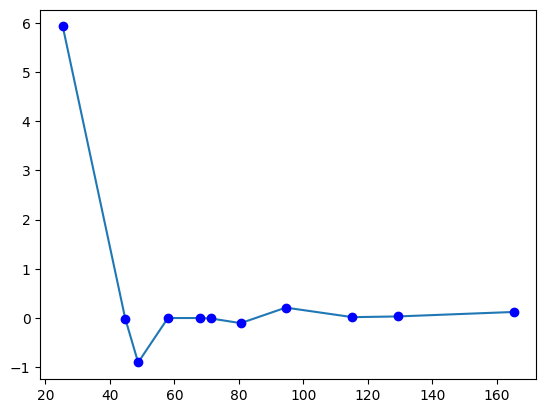

In [ ]:
## for a flightplan
pm = extendedPlan('C_OMAHA_1092_DELV_03',1)
plt.plot(pm['time'],pm['e_cross'])
plt.plot(pm['time'],pm['e_cross'], 'bo')

y_rf_flightplan= rf.predict(pm.drop(['e_along','e_cross','e_horizontal'], axis=1))

In [ ]:
def subplotModel(extendedPlan_real,y_predict):
  ### subplots of errors and predictions
  pm=extendedPlan_real
  pmreal = pm[['e_horizontal','e_along','e_cross']]
  pm=pm.drop(['e_along','e_cross','e_horizontal'], axis=1)

  ## create figure: 3 rows, one column
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

  ## subplot 1: longitude versus time
  ax1.plot(y_predict[:,0], color='green')
  ax1.plot(pmreal['e_horizontal'], color='red')
  ax1.set_xlabel('i')
  ax1.set_ylabel('e_horizontal')
  ax1.legend(["Predict", "Real"])
  ax1.set_title('e_horiz')

  # subplot 2: latitude versus time
  ax2.plot(y_predict[:,1], color='green')
  ax2.plot(pmreal['e_along'], color='red')
  ax2.set_xlabel('i')
  ax2.set_ylabel('e_along')
  ax2.set_title('e_along')

  # subplot 3: altitude versus time
  ax3.plot(y_predict[:,2], color='green')
  ax3.plot(pmreal['e_cross'], color='red')
  ax3.set_xlabel('i')
  ax3.set_ylabel('e_cross')
  ax3.set_title('e_cross')

  plt.tight_layout()
  plt.show()

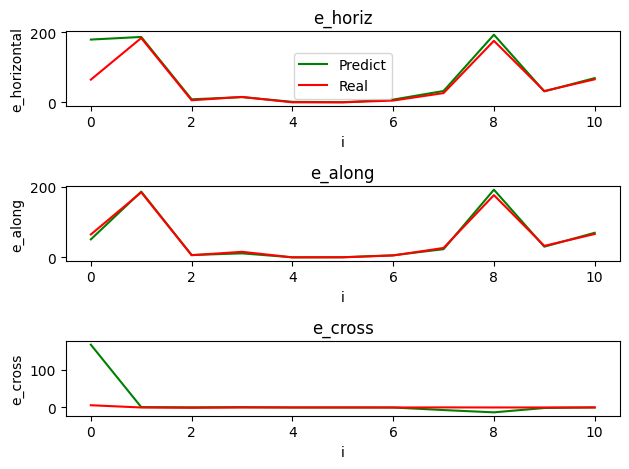

In [ ]:
subplotModel(pm,y_rf_flightplan)

In [ ]:
print('R2 e_horizontal train: ' + str(round(r2_score(y_train['e_horizontal'].reset_index(drop=True), y_rf_train_pred[:,0]),4)*100)+'%')
print('R2 e_along train: ' + str(round(r2_score(y_train['e_along'].reset_index(drop=True), y_rf_train_pred[:,1]),4)*100)+'%')
print('R2 e_cross train: ' + str(round(r2_score(y_train['e_cross'].reset_index(drop=True), y_rf_train_pred[:,2]),4)*100)+'%')
print('')
print('R2 e_horizontal test: ' + str(round(r2_score(y_test['e_horizontal'].reset_index(drop=True), y_rf_test_pred[:,0]),4)*100)+'%')
print('R2 e_along test: ' + str(round(r2_score(y_test['e_along'].reset_index(drop=True), y_rf_test_pred[:,1]),4)*100)+'%')
print('R2 e_cross test: ' + str(round(r2_score(y_test['e_cross'].reset_index(drop=True), y_rf_test_pred[:,2]),4)*100)+'%')

R2 e_horizontal train: 94.89%
R2 e_along train: 96.56%
R2 e_cross train: 91.77%

R2 e_horizontal test: 10.51%
R2 e_along test: 20.68%
R2 e_cross test: 5.08%


Text(0.5, 0.98, 'e_horizontal (first 100 values) from TRAIN data')

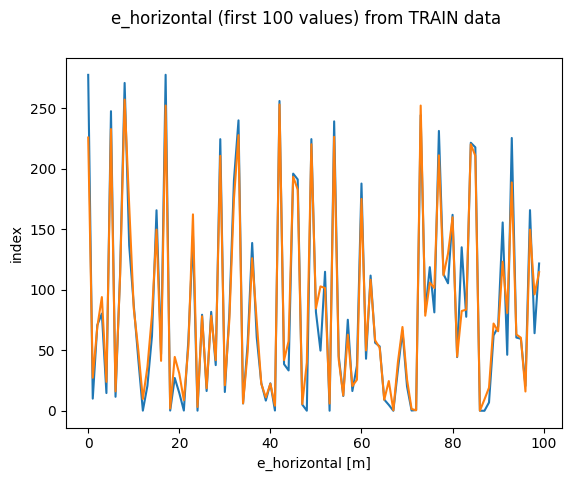

In [ ]:
plt.plot(y_train['e_horizontal'].reset_index(drop=True)[:100])
plt.plot(y_rf_train_pred[:,0][:100])
plt.ylabel('index')
plt.xlabel('e_horizontal [m]')
plt.suptitle('e_horizontal (first 100 values) from TRAIN data')

Text(0.5, 0.98, 'e_horizontal (first 100 values) from TEST data')

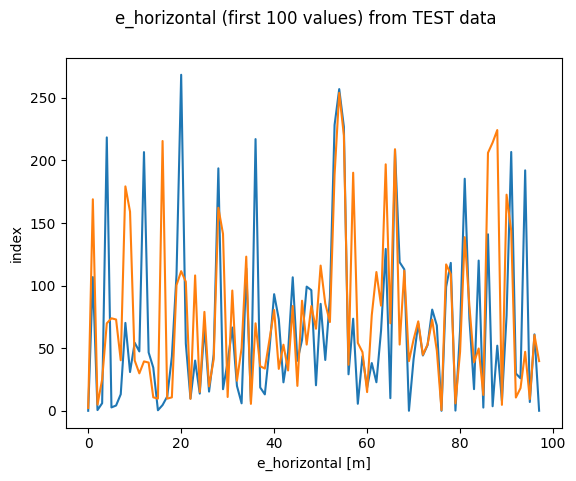

In [ ]:
plt.plot(y_test['e_horizontal'].reset_index(drop=True)[:100])
plt.plot(y_rf_test_pred[:,0][:100])
plt.ylabel('index')
plt.xlabel('e_horizontal [m]')
plt.suptitle('e_horizontal (first 100 values) from TEST data')

# Model

In [ ]:
dataset = pd.DataFrame({'FlightID': fileName})
dataset['FPlon'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "FlightPlan_" + x['FlightID'] + ".csv")['FPLlon'].values, axis=1)
dataset['FPlat'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "FlightPlan_" + x['FlightID'] + ".csv")['FPLlat'].values, axis=1)
dataset['FPlalt'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "FlightPlan_" + x['FlightID'] + ".csv")['FPLalt'].values, axis=1)

dataset['TELlon'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "Telemetry_" + x['FlightID'] + ".csv")['lon'][::50].values, axis=1)
dataset['TELlat'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "Telemetry_" + x['FlightID'] + ".csv")['lat'][::50].values, axis=1)
dataset['TELalt'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "Telemetry_" + x['FlightID'] + ".csv")['alt'][::50].values, axis=1)
dataset['time'] = dataset.apply(lambda x: pd.read_csv(dataUnzip + "Telemetry_" + x['FlightID'] + ".csv")['secs'][::50].values, axis=1)

dataset['TEL']= dataset.apply(lambda x: (geodetic2ecef_v2(x['TELlat'],x['TELlon'],x['TELalt'])), axis=1)
dataset['TELlon'] =dataset.apply(lambda x: (x['TEL'][0]),axis=1)
dataset['TELlat'] =dataset.apply(lambda x: (x['TEL'][1]),axis=1)
#dataset['TELalt'] =dataset.apply(lambda x: (x['TEL'][2]),axis=1)
dataset = dataset.drop(['TEL'], axis=1)



for (_, original), (_, shift) in zip(dataset['time'].iloc[:-1].iterrows(), dataset['time'].iloc[1:].iterrows()):
  subtracted = list()
  for item1, item2 in zip(original[0], shift[0]):
      item = item1 - item2
      subtracted.append(item)
  print(subtracted)



print(subtracted)
#dataset['MaxError']=dataset.apply(lambda x: computeMaxError(x['FlightID']), axis=1)


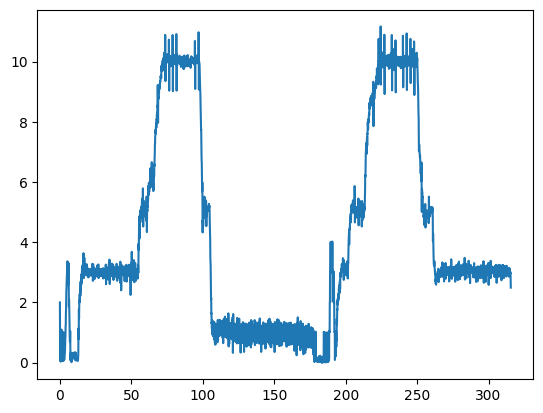

In [ ]:
#plotPlanTele3D('B_OMAHA_643_DELV_06')
flightPlan = pd.read_csv(dataUnzip + "FlightPlan_A_JUNO_142_DELV_06.csv")

df_telemetry = pd.read_csv(dataUnzip + "Telemetry_A_JUNO_142_DELV_06.csv")
df_telemetry['vel'] = [[]] * df_telemetry.shape[0]
df_telemetry.loc[df_telemetry.index[-1], 'vel'] = 0

for index, row in df_telemetry.iterrows():
  df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],df_telemetry.at[index,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

for (index, original), (_, shift) in zip(df_telemetry.iloc[:-1].iterrows(), df_telemetry.iloc[1:].iterrows()):
  dist=math.sqrt((shift['lon']-original['lon'])**2+(shift['lat']-original['lat'])**2+(shift['alt']-original['alt'])**2)
  df_telemetry.at[index, 'vel']=dist/(shift['secs']-original['secs'])

plt.plot(df_telemetry['secs'][:-1].values,df_telemetry['vel'][:-1].values)
for index, row in flightPlan.iterrows():
  flightPlan.at[index,'FPLlat'],flightPlan.at[index,'FPLlon'],flightPlan.at[index,'FPLalt']=geodetic2ecef(row['FPLlat'],row['FPLlon'],row['FPLalt'])
for (_, original), (_, shift) in zip(flightPlan.iloc[:-1].iterrows(), flightPlan.iloc[1:].iterrows()):
  dist=math.sqrt((shift['FPLlon']-original['FPLlon'])**2+(shift['FPLlat']-original['FPLlat'])**2+(shift['FPLalt']-original['FPLalt'])**2)


In [ ]:
PlanVsTele3D('B_OMAHA_626_DELV_03')


<ipython-input-79-7bc400deb08c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = flightPlan.append(telemetry, ignore_index=True)


In [ ]:
dataset = pd.DataFrame({'FlightID': fileName})
dataset['FPvel']= [[]] * dataset.shape[0]
dataset['FPlat']= [[]] * dataset.shape[0]
dataset['FPlon']= [[]] * dataset.shape[0]
dataset['FPalt']= [[]] * dataset.shape[0]

dataset['TELlat'] = [[]] * dataset.shape[0]
dataset['TELlon'] = [[]] * dataset.shape[0]
dataset['TELalt'] = [[]] * dataset.shape[0]
dataset['time'] = [[]] * dataset.shape[0]


for index, row in dataset.iterrows():
  flightplan = pd.read_csv(dataUnzip + "FlightPlan_" + row['FlightID'] + ".csv")
  dataset.at[index,'FPlat']=flightplan['FPLlat'].values
  dataset.at[index,'FPlon']=flightplan['FPLlon'].values
  dataset.at[index,'FPalt']=flightplan['FPLalt'].values
  dataset.at[index,'FPvel']=flightplan['FPLvel'].values

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + row['FlightID'] + ".csv")[::5]
  dataset.at[index,'TELlat'] = df_telemetry['lat'].values
  dataset.at[index,'TELlon'] = df_telemetry['lon'].values
  dataset.at[index,'TELalt'] = df_telemetry['alt'].values
  dataset.at[index,'time'] = df_telemetry['secs'].values

  df_telemetry['vel'] = [[]] * df_telemetry.shape[0]
  df_telemetry.loc[df_telemetry.index[-1], 'vel'] = 0

  for i, row in df_telemetry.iterrows():
    df_telemetry.at[i,'lat'],df_telemetry.at[i,'lon'],df_telemetry.at[i,'alt']=geodetic2ecef(row['lat'],row['lon'],row['alt'])

  for (i, original), (_, shift) in zip(df_telemetry.iloc[:-1].iterrows(), df_telemetry.iloc[1:].iterrows()):
    dist=math.sqrt((shift['lon']-original['lon'])**2+(shift['lat']-original['lat'])**2+(shift['alt']-original['alt'])**2)
    df_telemetry.at[i, 'vel']=dist/(shift['secs']-original['secs'])

  dataset.at[index,'vel'] = df_telemetry['vel'].values

dataset['maxError']=dataset.apply(lambda x: computeMaxError(x['FlightID']), axis=1)
#plt.plot(dataset['time'][0],dataset['vel'][0])
dataset.drop(dataset.loc[dataset['maxError']>=20].index, inplace=True)
#plt.plot(dataset['maxError'])
dataset.shape #rows, cols


FlightID                                              FPvel  \
0    C_JUNO_1755_DELV_10  [5.0, 10.0, 5.0, 3.0, 0.0, 2.0, 2.0, 5.0, 10.0...   
1     B_UTAH_980_DELV_02  [3.0, 5.0, 10.0, 5.0, 1.0, 0.0, 2.0, 2.0, 5.0,...   
3    B_UTAH_1093_DELV_01  [3.0, 5.0, 10.0, 5.0, 3.0, 0.0, 3.0, 3.0, 5.0,...   
4    C_JUNO_1625_DELV_08  [3.0, 5.0, 10.0, 5.0, 1.0, 0.0, 2.0, 2.0, 5.0,...   
5     A_UTAH_148_DELV_01  [5.0, 10.0, 10.0, 10.0, 5.0, 0.0, 9.0, 9.0, 10...   
..                   ...                                                ...   
66    A_JUNO_142_DELV_06  [7.0, 10.0, 10.0, 10.0, 3.0, 0.0, 2.0, 2.0, 10...   
67   C_UTAH_1720_DELV_02  [5.0, 10.0, 5.0, 3.0, 0.0, 2.0, 2.0, 5.0, 10.0...   
68   B_OMAHA_643_DELV_06  [3.0, 5.0, 10.0, 5.0, 1.0, 0.0, 1.0, 1.0, 5.0,...   
70  B_SWORD_1455_DELV_10  [5.0, 10.0, 5.0, 3.0, 0.0, 2.0, 2.0, 5.0, 10.0...   
71   A_OMAHA_371_DELV_06  [3.0, 10.0, 10.0, 10.0, 1.0, 0.0, 7.0, 7.0, 10...   

                                                FPlat  \
0   [41.26524176, 41.263882981706296, 41.263886708...   
1   [41.265035, 41.26405527947164, 41.263785483050...   
3   [41.265035, 41.26405527947164, 41.263425754489...   
4   [41.26524176, 41.26406284600235, 41.2637930495...   
5   [41.265035, 41.26405527947164, 41.263425754489...   
..                                                ...   
66  [41.26524176, 41.26406284600235, 41.2634333209...   
67  [41.265035, 41.26387541519116, 41.263876615038...   
68  [41.26502089, 41.26405786756837, 41.2637880711...   
70  [41.26500991, 41.26388615658965, 41.2638867082...   
71  [41.26502089, 41.26405786756837, 41.2637880711...   

                                                FPlon  \
0   [1.97890135, 1.9789004926228129, 1.96661684950...   
1   [1.99640653, 1.996405649170509, 1.996405406611...   
3   [1.99640653, 1.996405649170509, 1.996405083202...   
4   [1.97890135, 1.9789006061137056, 1.97890043587...   
5   [1.99640653, 1.996405649170509, 1.996405083202...   
..                                                ...   
66  [1.97890135, 1.9789006061137056, 1.97890020889...   
67  [1.99640653, 1.996405487464239, 1.993993963182...   
68  [1.99106893, 1.9910681428990675, 1.99106792239...   
70  [1.96874383, 1.9687432957198792, 1.96661684950...   
71  [1.99106893, 1.9910681428990675, 1.99106792239...   

                                                FPalt  \
0   [26.0, 26.0, 26.0, 26.0, 16.0, 16.0, 26.0, 76....   
1   [27.0, 67.0, 67.0, 67.0, 67.0, 17.0, 17.0, 27....   
3   [27.0, 37.0, 37.0, 37.0, 37.0, 17.0, 17.0, 27....   
4   [26.0, 66.0, 66.0, 66.0, 66.0, 16.0, 16.0, 26....   
5   [27.0, 37.0, 37.0, 37.0, 37.0, 17.0, 17.0, 27....   
..                                                ...   
66  [26.0, 36.0, 36.0, 36.0, 36.0, 16.0, 16.0, 26....   
67  [27.0, 27.0, 27.0, 27.0, 17.0, 17.0, 27.0, 77....   
68  [27.0, 67.0, 67.0, 67.0, 67.0, 17.0, 17.0, 27....   
70  [26.0, 26.0, 26.0, 26.0, 16.0, 16.0, 26.0, 76....   
71  [27.0, 67.0, 67.0, 67.0, 67.0, 17.0, 17.0, 27....   

                                               TELlat  \
0   [4798365.715426331, 4798366.025889712, 4798365...   
1   [4798331.414993862, 4798332.108409279, 4798332...   
3   [4798334.762047388, 4798335.478125128, 4798335...   
4   [4798365.4315452045, 4798365.807381758, 479836...   
5   [4798342.468641628, 4798344.365875241, 4798346...   
..                                                ...   
66  [4798372.103706083, 4798372.497505036, 4798372...   
67  [4798335.171016023, 4798336.139579971, 4798336...   
68  [4798353.024575881, 4798353.305042678, 4798353...   
70  [4798416.78538391, 4798416.972172138, 4798416....   
71  [4798351.186522875, 4798351.435432336, 4798351...   

                                               TELlon  \
0   [165795.7581141103, 165795.78845563595, 165795...   
1   [167273.99976181306, 167270.6285674821, 167266...   
3   [167260.8201872636, 167260.14829912572, 167260...   
4   [165796.47030155355, 165796.4897904381, 165796...   
5   [167260.5171669817, 167260.5793223638,

# Airways size

In [ ]:
def computeAvgError2(name):
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")


  import scipy
  import numpy as np
  import matplotlib.pyplot as plt

  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 120)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)
  #a=df_flightPlan.iloc[:-1].iterrows()
  #print(list(a)[0])

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  lat0=df_flightPlan['FPLlat'][0]
  lon0=df_flightPlan['FPLlon'][0]
  h0=df_flightPlan['FPLalt'][0]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],df_flightPlanExpanded.at[index,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],df_telemetry.at[index,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)

  ##
  import tslearn.metrics

  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  df_pairs = pd.DataFrame(dtw_output[0])
  '''
  fig = plt.figure()
  plt.plot(df_pairs[0], df_pairs[1])

  fig = plt.figure()
  plt.plot(
      np.diag(
          scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          )
      )
  )
  '''
  df_pairs['dist']=np.diag(scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          ))

  df_pairs_threshold=(df_pairs[(df_pairs[['dist']]>3).all(axis=1)])
  e_max=df_pairs['dist'].nlargest(3).mean()
  return df_pairs['dist'].mean(), e_max

In [ ]:
dataset0 = pd.DataFrame({'ID': fileName})
dataset0['avgError']=dataset0.apply(lambda x: computeAvgError2(x['ID'])[0], axis=1)
print(dataset0.loc[dataset0['avgError']>=7.9])
dataset0.drop(dataset0.loc[dataset0['avgError']>=7.9].index, inplace=True)
dataset0=dataset0.reset_index(drop=True)

ID  avgError
0    B_JUNO_1359_DELV_07  0.917656
1     A_UTAH_183_DELV_03  1.020643
2     A_JUNO_409_DELV_08  1.192797
3    A_OMAHA_371_DELV_06  1.252242
4    C_JUNO_1083_DELV_05  1.037630
5   B_OMAHA_1054_DELV_05  1.238716
6   C_OMAHA_1038_DELV_04  0.534582
7   B_SWORD_1538_DELV_11  2.056569
8    B_JUNO_1434_DELV_06  0.912642
9   B_SWORD_1455_DELV_10  1.799712
10  C_OMAHA_1779_DELV_04  0.510349
11  C_OMAHA_1733_DELV_04  1.056172
12   B_UTAH_1365_DELV_01  0.514146
13  C_OMAHA_1092_DELV_03  1.025890
14  B_OMAHA_1444_DELV_02  0.401748
15   C_JUNO_1625_DELV_08  0.919013
16   B_OMAHA_965_DELV_04  1.085548
17   B_OMAHA_745_DELV_02  0.395225
18   B_JUNO_1321_DELV_06  0.756158
19   B_UTAH_1414_DELV_02  0.749733
20    C_JUNO_634_DELV_08  0.794700
21   B_SWORD_563_DELV_08  1.890346
22   B_JUNO_1422_DELV_10  1.714268
23  B_OMAHA_1526_DELV_03  0.990697
24   B_OMAHA_643_DELV_06  2.592419
25    C_UTAH_747_DELV_01  0.651373
26  B_OMAHA_1396_DELV_03  0.763413
27    C_UTAH_945_DELV_02  1.498250
28    C_JUNO_959_DELV_08  0.830925
29    B_UTAH_980_DELV_02  0.530953
30  B_OMAHA_1479_DELV_05  1.263841
31   C_JUNO_1693_DELV_07  1.315017
32   A_OMAHA_170_DELV_01  1.512816
33   C_JUNO_1755_DELV_10  1.753788
34  B_OMAHA_1347_DELV_06  0.957050
35  B_OMAHA_1577_DELV_03  0.808419
36   C_UTAH_1112_DELV_04  1.239558
37  B_SWORD_1582_DELV_09  1.311706
38    A_UTAH_405_DELV_04  2.592972
39    B_UTAH_529_DELV_02  0.539369
40    C_JUNO_891_DELV_08  1.072284
41   B_OMAHA_561_DELV_04  0.411785
42   C_UTAH_1720_DELV_02  0.493719
43  B_OMAHA_1331_DELV_02  0.744521
44   B_UTAH_1514_DELV_01  0.470523
45   C_UTAH_1005_DELV_04  1.152824
46   B_UTAH_1565_DELV_02  0.445614
47   C_OMAHA_970_DELV_02  0.949912
48    A_JUNO_372_DELV_08  0.828695
49    A_JUNO_142_DELV_06  0.819291
50   B_OMAHA_701_DELV_03  0.741604
51    C_JUNO_926_DELV_06  0.773168
52   B_OMAHA_545_DELV_05  1.049684
53   B_OMAHA_677_DELV_05  0.787245
54    B_JUNO_527_DELV_07  0.968718
55    A_UTAH_148_DELV_01  1.295136
56   C_OMAHA_547_DELV_04  0.973091
57   C_UTAH_1492_DELV_01  0.647998
58   B_UTAH_1093_DELV_01  0.527100

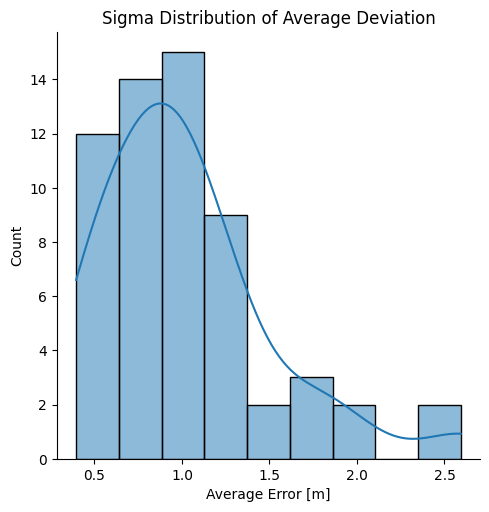

In [ ]:
df = dataset0
sns.displot(data=df, x='avgError', kde=True)
plt.title('Sigma Distribution of Average Deviation')
plt.xlabel('Average Error [m]')

plt.show()

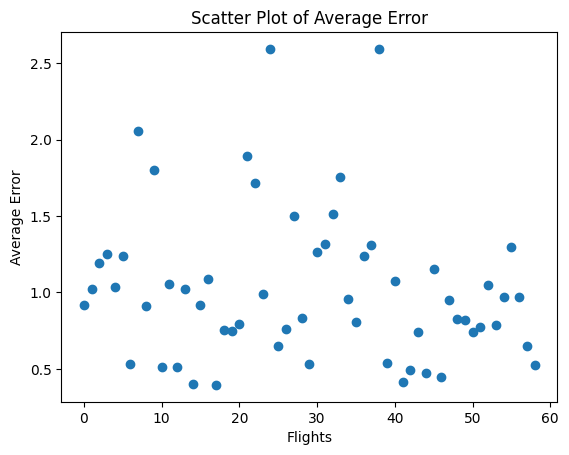

In [ ]:
plt.scatter(range(len(df)), df['avgError'])
plt.title('Scatter Plot of Average Error')
plt.xlabel('Flights')
plt.ylabel('Average Error')
plt.show()


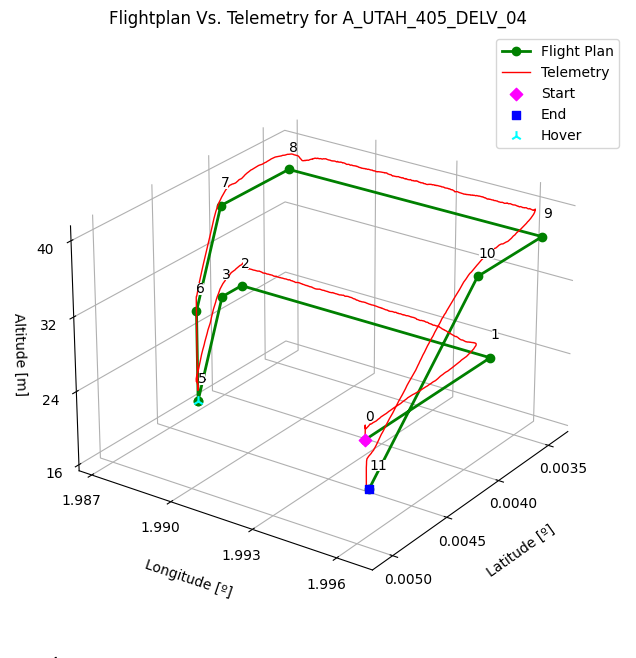

In [ ]:
plot_planVsTele('A_UTAH_405_DELV_04')

In [ ]:
subplotPlanVsUspace('C_JUNO_1755_DELV_10')

In [ ]:
def computeMaxErrorPlots2(name):
  #name='A_JUNO_142_DELV_06'
  #pip install -U https://github.com/tslearn-team/tslearn/archive/main.zip
  df_flightPlan = pd.read_csv(dataUnzip + "FlightPlan_" + name + ".csv")

  df_telemetry = pd.read_csv(dataUnzip + "Telemetry_" + name + ".csv")


  import scipy
  import numpy as np
  import matplotlib.pyplot as plt

  df_flightPlanExpanded = pd.concat(
      [
          pd.DataFrame(
              scipy.interpolate.interp1d([0, 1],[[original["FPLlat"], original["FPLlon"], original["FPLalt"]],[shift["FPLlat"], shift["FPLlon"], shift["FPLalt"]]],
                                        axis=0, bounds_error=False,fill_value=[0, 0, 0])(np.linspace(0, 1, 120)), columns=["FPLlat", "FPLlon", "FPLalt"] )
          for (_, original), (_, shift) in zip(df_flightPlan.iloc[:-1].iterrows(), df_flightPlan.iloc[1:].iterrows())
      ]
  )
  df_flightPlanExpanded = df_flightPlanExpanded.reset_index(drop=True)
  #a=df_flightPlan.iloc[:-1].iterrows()
  #print(list(a)[0])

  ## Lat, Lon, Alt to x, y, z with geodetic2ecef
  lat0=df_flightPlan['FPLlat'][0]
  lon0=df_flightPlan['FPLlon'][0]
  h0=df_flightPlan['FPLalt'][0]

  for index, row in df_flightPlanExpanded.iterrows():
    df_flightPlanExpanded.at[index,'FPLlat'],df_flightPlanExpanded.at[index,'FPLlon'],df_flightPlanExpanded.at[index,'FPLalt']=geodetic_to_enu(row['FPLlat'],row['FPLlon'],row['FPLalt'],lat0,lon0,h0)

  for index, row in df_telemetry.iterrows():
    df_telemetry.at[index,'lat'],df_telemetry.at[index,'lon'],df_telemetry.at[index,'alt']=geodetic_to_enu(row['lat'],row['lon'],row['alt'],lat0,lon0,h0)

  ## Plot

  fig = plt.figure()
  ax = plt.axes(projection="3d")

  # Data for a three-dimensional line
  zline = df_flightPlanExpanded["FPLalt"]
  xline = df_flightPlanExpanded["FPLlon"]
  yline = df_flightPlanExpanded["FPLlat"]
  ax.plot3D(xline, yline, zline, "green", alpha=0.5)
  zline = df_telemetry["alt"]
  xline = df_telemetry["lon"]
  yline = df_telemetry["lat"]
  ax.plot3D(xline, yline, zline, "red", alpha=0.5)
  ##
  import tslearn.metrics

  dtw_output = tslearn.metrics.dtw_path(
      df_telemetry[["lat", "lon", "alt"]].values, df_flightPlanExpanded[["FPLlat", "FPLlon", "FPLalt"]].values
  )

  df_pairs = pd.DataFrame(dtw_output[0])

  fig = plt.figure()
  plt.plot(df_pairs[0], df_pairs[1])

  fig = plt.figure()
  plt.plot(
      np.diag(
          scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          )
      )
  )
  df_pairs['dist']=np.diag(scipy.spatial.distance.cdist(
              df_telemetry.loc[df_pairs[0]][["lon", "lat", "alt"]],
              df_flightPlanExpanded.loc[df_pairs[1]][["FPLlon", "FPLlat", "FPLalt"]],
          ))

  df_pairs_threshold=(df_pairs[(df_pairs[['dist']]>3).all(axis=1)])
  e_max=df_pairs['dist'].nlargest(5).mean()

  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  df=df_flightPlanExpanded
  # Create a 3D plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the 3D trajectory
  ax.plot(df['FPLlat'], df['FPLlon'], df['FPLalt'], c='green', label='Trajectory')
  ax.plot3D(df_telemetry['lat'], df_telemetry['lon'], df_telemetry['alt'], "red", alpha=0.5)

  # Highlight a specific index
  highlight_index = 120
  highlight_point = df.loc[highlight_index]
  ax.scatter(highlight_point['FPLlat'], highlight_point['FPLlon'], highlight_point['FPLalt'], c='orange', label='Plan point')

  #telemetry index
  highlight_index2=375
  highlight_point2 = df_telemetry.loc[highlight_index2]
  ax.scatter(highlight_point2['lat'], highlight_point2['lon'], highlight_point2['alt'], c='orange', label='TEl point')

  # Set labels and title
  ax.set_xlabel('FPLlat')
  ax.set_ylabel('FPLlon')
  ax.set_zlabel('FPLalt')
  ax.set_title('3D Trajectory with Highlight')

  # Add legend
  ax.legend()

  # Show the plot
  plt.show()
  return df_pairs

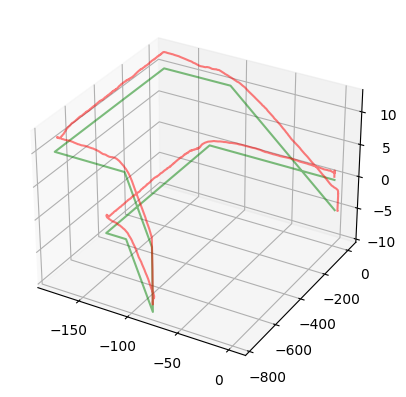

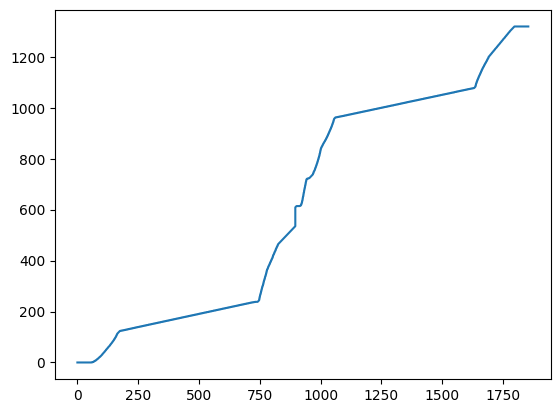

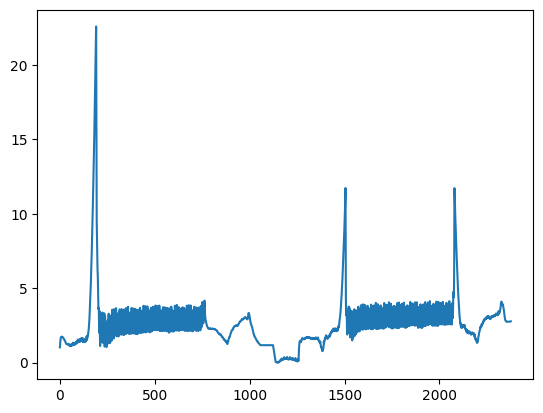

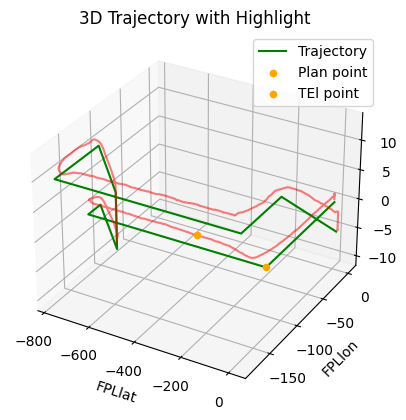

In [ ]:
hi=computeMaxErrorPlots2('A_UTAH_405_DELV_04')

In [ ]:
hi.head(193)
plt.plot(hi['dist'][:195])

0    1       dist
0      0    0   1.028864
1      1    0   1.147746
2      2    0   1.401013
3      3    0   1.499544
4      4    0   1.576981
..   ...  ...        ...
188  168  117  20.348801
189  169  118  21.173181
190  170  119  22.263188
191  171  120  22.579965
192  172  121  17.520412

[193 rows x 3 columns]